# Assignment

# 1

In [3]:
import torch.nn as nn
from torch.autograd import Variable
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.utils import resample
import torch.utils.data as data_utils

In [4]:
filename = 'train_data.txt'
raw_traindata = pd.read_csv(filename)
print(raw_traindata.Occupancy.value_counts())

0    6414
1    1729
Name: Occupancy, dtype: int64


### Note : I tried downsampling initially to remove the bias, but the model woks without this too

In [5]:
train_data = raw_traindata.drop(['date', 'Occupancy'], axis  = 1, inplace = False)
train_label = raw_traindata.Occupancy
print(train_data.head())

   Temperature  Humidity  Light     CO2  HumidityRatio
1        23.18   27.2720  426.0  721.25       0.004793
2        23.15   27.2675  429.5  714.00       0.004783
3        23.15   27.2450  426.0  713.50       0.004779
4        23.15   27.2000  426.0  708.25       0.004772
5        23.10   27.2000  426.0  704.50       0.004757


In [6]:
filename1 = 'test_data.txt'
raw_testdata = pd.read_csv(filename1)
test_data = raw_testdata.drop(['date','Occupancy'], axis = 1,inplace = False)
test_label = raw_testdata.Occupancy
print(test_data.head())


   Temperature   Humidity       Light          CO2  HumidityRatio
1      21.7600  31.133333  437.333333  1029.666667       0.005021
2      21.7900  31.000000  437.333333  1000.000000       0.005009
3      21.7675  31.122500  434.000000  1003.750000       0.005022
4      21.7675  31.122500  439.000000  1009.500000       0.005022
5      21.7900  31.133333  437.333333  1005.666667       0.005030


In [7]:
x_train = train_data.as_matrix()  # convert pandas dataframe to numpy nd-array
y_train = train_label.as_matrix()
x_test = test_data.as_matrix()
y_test = test_label.as_matrix()

x_train_tense = torch.from_numpy(x_train)
y_train_tense = torch.from_numpy(y_train)
x_test_tense = torch.from_numpy(x_test)
y_test_tense = torch.from_numpy(y_test)

train_util = data_utils.TensorDataset(x_train_tense, y_train_tense)
test_util = data_utils.TensorDataset(x_test_tense, y_test_tense)

In [8]:

test_loader = data_utils.DataLoader(test_util, batch_size = 9752, shuffle=True)

## 1a

In [9]:
class Net(nn.Module):                  # define a neural network with 1 hidden layer with H neurons
    
    def __init__(self, H):
        seed = 17
        torch.manual_seed(seed)
        super(Net, self).__init__()
        self.linear1 = nn.Linear(5, H)
        self.linear2 = nn.Linear(H, 1)
#         nn.init.xavier_uniform(self.linear1.weight)
#         nn.init.xavier_uniform(self.linear2.weight)
        
        
    def forward(self, x):                           # forward method
        x = self.linear1(x)
        n = nn.LeakyReLU(0.2)
        x = n(x)
        x = self.linear2(x)
        x = n(x)
        m = nn.Sigmoid()
#         print (list(self.linear1.parameters()))
        x = m(x)
        return x 



## Note :

The evaluation of the model as described in 1a is done in 1d

## Methods for training and testing the net and 1b

In [10]:
def train(epoch):
    model.train()                                             # put the model in training mode
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optim.zero_grad()                                         # zero the gradients
        output = model(data.type(torch.FloatTensor))                                   # feedforward the input
        loss = criterion(output, target.type(torch.FloatTensor))                         # determine the loss
        train_loss += (loss.data[0])*len(target)
#         pred = output.data.max(1, keepdim = True)[1]             # number of correctly classifies points
        pred = (output.data > 0.5).long()
        correct += pred.eq((target.type(torch.LongTensor)).data.view_as(pred)).cpu().sum()
        loss.backward()                                           # evaluate the backward gradients        
        
#         for param in model.parameters():
#             print(param.grad.data.sum())

        # start debugger
#         import pdb; pdb.set_trace()
        
        optim.step()                                              # apply the backward gradients
        
#         if batch_idx % log_interval == 0 :
#             print('Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.data[0]/len(data)))
            
    train_loss /= len(train_loader.dataset)
    
    print('\nTrain set {}: Average loss: {:.4f}, Training Accuracy : {}/{} ({:.0f}%)\n'.format( 
        epoch, train_loss, correct, len(train_loader.dataset),
          (100.0*correct) / len(train_loader.dataset) ) ) 
    
    return train_loss, (100.0*correct) / len(train_loader.dataset)

def test(epoch):
    model.eval()                                          # toggle to evaluation mode
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        output = model(data.type(torch.FloatTensor))                               # feedforward the test point
        loss = criterion(output, target.type(torch.FloatTensor))                     # determine the loss
        test_loss += loss.data[0]*len(target)
#         pred = output.data.max(1, keepdim = True)[1]         # predict the number of correctly classifies test points
        pred = (output.data > 0.5).long()
        correct += pred.eq(target.type(torch.LongTensor).data.view_as(pred)).cpu().sum()
    
    test_loss /= len(test_loader.dataset)  # taking the average of the test_loss
    
    print('\nTest set {}: Average loss: {:.4f}, Test Accuracy : {}/{} ({:.0f}%)\n'.format(  # classification error
        epoch, test_loss, correct, len(test_loader.dataset),
        (100.0*correct) / len(test_loader.dataset) ) ) 
    
    return test_loss, (100.0*correct) / len(test_loader.dataset)
    
    
# 1b

def baseline(base):                                       # method to get the base error as defined in the question
    y_temp = []
    for i in range(len(base)):
        random = np.random.choice(range(2), 5, replace = True)
        counts = np.bincount(random)
        y_temp += [np.argmax(counts)]
        
    y_temp = np.array(y_temp)
    y_temp = torch.from_numpy(y_temp)
    targets = torch.from_numpy(base)
    y_temp = y_temp.type(torch.FloatTensor)
    targets = targets.type(torch.FloatTensor)
    y_temp = Variable(y_temp)
    targets = Variable(targets)
    
    return criterion(y_temp, targets).data[0]

def graph(toplot, labels, title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    for i in range(len(toplot)):
        plt.plot(no_epoch, toplot[i], label = labels[i])

    plt.legend(loc = 'best')
    plt.show()

## 1c

In [11]:
log_interval = 100
train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle = True)

model = Net(H = 5)
optim = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0)
criterion = torch.nn.BCELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_sgd = []
testacc_sgd = []

epoch = 0
while epoch != 1000 :

    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_sgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_sgd += [test_acc]
    
    basetrainerror += [base_trainerror]
    basetesterror += [base_testerror]
    
    no_epoch += [epoch]


print ('Train accuracy is {} % \nTest Accuracy is {} %\n'.format(train_acc, test_acc )) 

/home/abhi/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/abhi/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))



Train set 1: Average loss: 0.8363, Training Accuracy : 6177/8143 (76%)


Test set 1: Average loss: 0.7699, Test Accuracy : 7703/9752 (79%)



/home/abhi/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([9752])) that is different to the input size (torch.Size([9752, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))



Train set 2: Average loss: 0.7009, Training Accuracy : 6516/8143 (80%)


Test set 2: Average loss: 0.4896, Test Accuracy : 9261/9752 (95%)


Train set 3: Average loss: 0.4898, Training Accuracy : 7507/8143 (92%)


Test set 3: Average loss: 0.3484, Test Accuracy : 9265/9752 (95%)


Train set 4: Average loss: 0.4300, Training Accuracy : 7516/8143 (92%)


Test set 4: Average loss: 0.2982, Test Accuracy : 9221/9752 (95%)


Train set 5: Average loss: 0.4055, Training Accuracy : 7474/8143 (92%)


Test set 5: Average loss: 0.2614, Test Accuracy : 9248/9752 (95%)


Train set 6: Average loss: 0.3910, Training Accuracy : 7422/8143 (91%)


Test set 6: Average loss: 0.2406, Test Accuracy : 9248/9752 (95%)


Train set 7: Average loss: 0.3814, Training Accuracy : 7402/8143 (91%)


Test set 7: Average loss: 0.2280, Test Accuracy : 9251/9752 (95%)


Train set 8: Average loss: 0.3755, Training Accuracy : 7388/8143 (91%)


Test set 8: Average loss: 0.2296, Test Accuracy : 9206/9752 (94%)


Train set 9:


Test set 60: Average loss: 0.1639, Test Accuracy : 9278/9752 (95%)


Train set 61: Average loss: 0.2156, Training Accuracy : 7580/8143 (93%)


Test set 61: Average loss: 0.1588, Test Accuracy : 9243/9752 (95%)


Train set 62: Average loss: 0.2133, Training Accuracy : 7595/8143 (93%)


Test set 62: Average loss: 0.1521, Test Accuracy : 9161/9752 (94%)


Train set 63: Average loss: 0.2111, Training Accuracy : 7597/8143 (93%)


Test set 63: Average loss: 0.1549, Test Accuracy : 9219/9752 (95%)


Train set 64: Average loss: 0.2087, Training Accuracy : 7601/8143 (93%)


Test set 64: Average loss: 0.1522, Test Accuracy : 9177/9752 (94%)


Train set 65: Average loss: 0.2074, Training Accuracy : 7609/8143 (93%)


Test set 65: Average loss: 0.1529, Test Accuracy : 9206/9752 (94%)


Train set 66: Average loss: 0.2055, Training Accuracy : 7609/8143 (93%)


Test set 66: Average loss: 0.1527, Test Accuracy : 9198/9752 (94%)


Train set 67: Average loss: 0.2030, Training Accuracy : 7615/8143 (94%)



Train set 118: Average loss: 0.1366, Training Accuracy : 7787/8143 (96%)


Test set 118: Average loss: 0.1491, Test Accuracy : 9201/9752 (94%)


Train set 119: Average loss: 0.1356, Training Accuracy : 7780/8143 (96%)


Test set 119: Average loss: 0.1479, Test Accuracy : 9128/9752 (94%)


Train set 120: Average loss: 0.1349, Training Accuracy : 7773/8143 (95%)


Test set 120: Average loss: 0.1542, Test Accuracy : 9252/9752 (95%)


Train set 121: Average loss: 0.1347, Training Accuracy : 7787/8143 (96%)


Test set 121: Average loss: 0.1499, Test Accuracy : 9197/9752 (94%)


Train set 122: Average loss: 0.1337, Training Accuracy : 7784/8143 (96%)


Test set 122: Average loss: 0.1486, Test Accuracy : 9200/9752 (94%)


Train set 123: Average loss: 0.1332, Training Accuracy : 7786/8143 (96%)


Test set 123: Average loss: 0.1468, Test Accuracy : 9165/9752 (94%)


Train set 124: Average loss: 0.1324, Training Accuracy : 7789/8143 (96%)


Test set 124: Average loss: 0.1475, Test Accuracy : 91


Test set 175: Average loss: 0.1462, Test Accuracy : 9192/9752 (94%)


Train set 176: Average loss: 0.1120, Training Accuracy : 7837/8143 (96%)


Test set 176: Average loss: 0.1513, Test Accuracy : 9086/9752 (93%)


Train set 177: Average loss: 0.1117, Training Accuracy : 7843/8143 (96%)


Test set 177: Average loss: 0.1481, Test Accuracy : 9156/9752 (94%)


Train set 178: Average loss: 0.1115, Training Accuracy : 7845/8143 (96%)


Test set 178: Average loss: 0.1470, Test Accuracy : 9204/9752 (94%)


Train set 179: Average loss: 0.1111, Training Accuracy : 7856/8143 (96%)


Test set 179: Average loss: 0.1438, Test Accuracy : 9170/9752 (94%)


Train set 180: Average loss: 0.1114, Training Accuracy : 7837/8143 (96%)


Test set 180: Average loss: 0.1446, Test Accuracy : 9133/9752 (94%)


Train set 181: Average loss: 0.1107, Training Accuracy : 7849/8143 (96%)


Test set 181: Average loss: 0.1444, Test Accuracy : 9156/9752 (94%)


Train set 182: Average loss: 0.1110, Training Accuracy : 78


Train set 233: Average loss: 0.1034, Training Accuracy : 7886/8143 (97%)


Test set 233: Average loss: 0.1371, Test Accuracy : 9130/9752 (94%)


Train set 234: Average loss: 0.1033, Training Accuracy : 7898/8143 (97%)


Test set 234: Average loss: 0.1350, Test Accuracy : 9222/9752 (95%)


Train set 235: Average loss: 0.1024, Training Accuracy : 7885/8143 (97%)


Test set 235: Average loss: 0.1545, Test Accuracy : 8982/9752 (92%)


Train set 236: Average loss: 0.1030, Training Accuracy : 7895/8143 (97%)


Test set 236: Average loss: 0.1334, Test Accuracy : 9214/9752 (94%)


Train set 237: Average loss: 0.1030, Training Accuracy : 7885/8143 (97%)


Test set 237: Average loss: 0.1369, Test Accuracy : 9127/9752 (94%)


Train set 238: Average loss: 0.1028, Training Accuracy : 7904/8143 (97%)


Test set 238: Average loss: 0.1349, Test Accuracy : 9201/9752 (94%)


Train set 239: Average loss: 0.1029, Training Accuracy : 7899/8143 (97%)


Test set 239: Average loss: 0.1362, Test Accuracy : 91


Test set 290: Average loss: 0.1318, Test Accuracy : 9235/9752 (95%)


Train set 291: Average loss: 0.0989, Training Accuracy : 7929/8143 (97%)


Test set 291: Average loss: 0.1299, Test Accuracy : 9242/9752 (95%)


Train set 292: Average loss: 0.0989, Training Accuracy : 7922/8143 (97%)


Test set 292: Average loss: 0.1308, Test Accuracy : 9256/9752 (95%)


Train set 293: Average loss: 0.0988, Training Accuracy : 7918/8143 (97%)


Test set 293: Average loss: 0.1330, Test Accuracy : 9145/9752 (94%)


Train set 294: Average loss: 0.0993, Training Accuracy : 7919/8143 (97%)


Test set 294: Average loss: 0.1298, Test Accuracy : 9258/9752 (95%)


Train set 295: Average loss: 0.0990, Training Accuracy : 7912/8143 (97%)


Test set 295: Average loss: 0.1346, Test Accuracy : 9105/9752 (93%)


Train set 296: Average loss: 0.0985, Training Accuracy : 7917/8143 (97%)


Test set 296: Average loss: 0.1328, Test Accuracy : 9163/9752 (94%)


Train set 297: Average loss: 0.0988, Training Accuracy : 79


Train set 348: Average loss: 0.0964, Training Accuracy : 7939/8143 (97%)


Test set 348: Average loss: 0.1308, Test Accuracy : 9226/9752 (95%)


Train set 349: Average loss: 0.0969, Training Accuracy : 7933/8143 (97%)


Test set 349: Average loss: 0.1307, Test Accuracy : 9239/9752 (95%)


Train set 350: Average loss: 0.0968, Training Accuracy : 7933/8143 (97%)


Test set 350: Average loss: 0.1298, Test Accuracy : 9266/9752 (95%)


Train set 351: Average loss: 0.0964, Training Accuracy : 7933/8143 (97%)


Test set 351: Average loss: 0.1288, Test Accuracy : 9267/9752 (95%)


Train set 352: Average loss: 0.0967, Training Accuracy : 7926/8143 (97%)


Test set 352: Average loss: 0.1290, Test Accuracy : 9265/9752 (95%)


Train set 353: Average loss: 0.0962, Training Accuracy : 7924/8143 (97%)


Test set 353: Average loss: 0.1322, Test Accuracy : 9189/9752 (94%)


Train set 354: Average loss: 0.0963, Training Accuracy : 7940/8143 (98%)


Test set 354: Average loss: 0.1288, Test Accuracy : 92


Test set 405: Average loss: 0.1289, Test Accuracy : 9270/9752 (95%)


Train set 406: Average loss: 0.0950, Training Accuracy : 7941/8143 (98%)


Test set 406: Average loss: 0.1314, Test Accuracy : 9196/9752 (94%)


Train set 407: Average loss: 0.0947, Training Accuracy : 7955/8143 (98%)


Test set 407: Average loss: 0.1281, Test Accuracy : 9274/9752 (95%)


Train set 408: Average loss: 0.0952, Training Accuracy : 7945/8143 (98%)


Test set 408: Average loss: 0.1291, Test Accuracy : 9263/9752 (95%)


Train set 409: Average loss: 0.0947, Training Accuracy : 7949/8143 (98%)


Test set 409: Average loss: 0.1291, Test Accuracy : 9267/9752 (95%)


Train set 410: Average loss: 0.0948, Training Accuracy : 7937/8143 (97%)


Test set 410: Average loss: 0.1394, Test Accuracy : 9071/9752 (93%)


Train set 411: Average loss: 0.0950, Training Accuracy : 7952/8143 (98%)


Test set 411: Average loss: 0.1323, Test Accuracy : 9182/9752 (94%)


Train set 412: Average loss: 0.0945, Training Accuracy : 79


Train set 463: Average loss: 0.0934, Training Accuracy : 7943/8143 (98%)


Test set 463: Average loss: 0.1305, Test Accuracy : 9212/9752 (94%)


Train set 464: Average loss: 0.0933, Training Accuracy : 7945/8143 (98%)


Test set 464: Average loss: 0.1336, Test Accuracy : 9153/9752 (94%)


Train set 465: Average loss: 0.0936, Training Accuracy : 7948/8143 (98%)


Test set 465: Average loss: 0.1309, Test Accuracy : 9208/9752 (94%)


Train set 466: Average loss: 0.0938, Training Accuracy : 7958/8143 (98%)


Test set 466: Average loss: 0.1283, Test Accuracy : 9273/9752 (95%)


Train set 467: Average loss: 0.0932, Training Accuracy : 7950/8143 (98%)


Test set 467: Average loss: 0.1284, Test Accuracy : 9275/9752 (95%)


Train set 468: Average loss: 0.0928, Training Accuracy : 7950/8143 (98%)


Test set 468: Average loss: 0.1396, Test Accuracy : 9068/9752 (93%)


Train set 469: Average loss: 0.0933, Training Accuracy : 7944/8143 (98%)


Test set 469: Average loss: 0.1379, Test Accuracy : 90


Test set 520: Average loss: 0.1322, Test Accuracy : 9203/9752 (94%)


Train set 521: Average loss: 0.0928, Training Accuracy : 7961/8143 (98%)


Test set 521: Average loss: 0.1284, Test Accuracy : 9264/9752 (95%)


Train set 522: Average loss: 0.0927, Training Accuracy : 7958/8143 (98%)


Test set 522: Average loss: 0.1413, Test Accuracy : 9080/9752 (93%)


Train set 523: Average loss: 0.0925, Training Accuracy : 7963/8143 (98%)


Test set 523: Average loss: 0.1438, Test Accuracy : 9080/9752 (93%)


Train set 524: Average loss: 0.0928, Training Accuracy : 7959/8143 (98%)


Test set 524: Average loss: 0.1383, Test Accuracy : 9073/9752 (93%)


Train set 525: Average loss: 0.0924, Training Accuracy : 7950/8143 (98%)


Test set 525: Average loss: 0.1340, Test Accuracy : 9163/9752 (94%)


Train set 526: Average loss: 0.0927, Training Accuracy : 7964/8143 (98%)


Test set 526: Average loss: 0.1321, Test Accuracy : 9205/9752 (94%)


Train set 527: Average loss: 0.0922, Training Accuracy : 79


Train set 578: Average loss: 0.0920, Training Accuracy : 7968/8143 (98%)


Test set 578: Average loss: 0.1303, Test Accuracy : 9254/9752 (95%)


Train set 579: Average loss: 0.0917, Training Accuracy : 7951/8143 (98%)


Test set 579: Average loss: 0.1537, Test Accuracy : 9015/9752 (92%)


Train set 580: Average loss: 0.0919, Training Accuracy : 7971/8143 (98%)


Test set 580: Average loss: 0.1288, Test Accuracy : 9277/9752 (95%)


Train set 581: Average loss: 0.0916, Training Accuracy : 7971/8143 (98%)


Test set 581: Average loss: 0.1426, Test Accuracy : 9077/9752 (93%)


Train set 582: Average loss: 0.0923, Training Accuracy : 7971/8143 (98%)


Test set 582: Average loss: 0.1427, Test Accuracy : 9078/9752 (93%)


Train set 583: Average loss: 0.0914, Training Accuracy : 7963/8143 (98%)


Test set 583: Average loss: 0.1319, Test Accuracy : 9230/9752 (95%)


Train set 584: Average loss: 0.0916, Training Accuracy : 7966/8143 (98%)


Test set 584: Average loss: 0.1286, Test Accuracy : 92


Test set 635: Average loss: 0.1410, Test Accuracy : 9138/9752 (94%)


Train set 636: Average loss: 0.0908, Training Accuracy : 7960/8143 (98%)


Test set 636: Average loss: 0.1356, Test Accuracy : 9238/9752 (95%)


Train set 637: Average loss: 0.0912, Training Accuracy : 7975/8143 (98%)


Test set 637: Average loss: 0.1368, Test Accuracy : 9211/9752 (94%)


Train set 638: Average loss: 0.0911, Training Accuracy : 7975/8143 (98%)


Test set 638: Average loss: 0.1400, Test Accuracy : 9155/9752 (94%)


Train set 639: Average loss: 0.0909, Training Accuracy : 7967/8143 (98%)


Test set 639: Average loss: 0.1556, Test Accuracy : 9059/9752 (93%)


Train set 640: Average loss: 0.0910, Training Accuracy : 7959/8143 (98%)


Test set 640: Average loss: 0.1461, Test Accuracy : 9060/9752 (93%)


Train set 641: Average loss: 0.0910, Training Accuracy : 7966/8143 (98%)


Test set 641: Average loss: 0.1691, Test Accuracy : 8948/9752 (92%)


Train set 642: Average loss: 0.0913, Training Accuracy : 79


Train set 693: Average loss: 0.0907, Training Accuracy : 7966/8143 (98%)


Test set 693: Average loss: 0.1348, Test Accuracy : 9263/9752 (95%)


Train set 694: Average loss: 0.0906, Training Accuracy : 7971/8143 (98%)


Test set 694: Average loss: 0.1364, Test Accuracy : 9211/9752 (94%)


Train set 695: Average loss: 0.0904, Training Accuracy : 7974/8143 (98%)


Test set 695: Average loss: 0.1362, Test Accuracy : 9214/9752 (94%)


Train set 696: Average loss: 0.0906, Training Accuracy : 7969/8143 (98%)


Test set 696: Average loss: 0.1329, Test Accuracy : 9275/9752 (95%)


Train set 697: Average loss: 0.0906, Training Accuracy : 7967/8143 (98%)


Test set 697: Average loss: 0.1405, Test Accuracy : 9162/9752 (94%)


Train set 698: Average loss: 0.0904, Training Accuracy : 7962/8143 (98%)


Test set 698: Average loss: 0.1463, Test Accuracy : 9066/9752 (93%)


Train set 699: Average loss: 0.0905, Training Accuracy : 7972/8143 (98%)


Test set 699: Average loss: 0.1414, Test Accuracy : 91


Test set 750: Average loss: 0.1386, Test Accuracy : 9251/9752 (95%)


Train set 751: Average loss: 0.0897, Training Accuracy : 7963/8143 (98%)


Test set 751: Average loss: 0.1354, Test Accuracy : 9272/9752 (95%)


Train set 752: Average loss: 0.0900, Training Accuracy : 7969/8143 (98%)


Test set 752: Average loss: 0.1393, Test Accuracy : 9251/9752 (95%)


Train set 753: Average loss: 0.0901, Training Accuracy : 7962/8143 (98%)


Test set 753: Average loss: 0.1466, Test Accuracy : 9127/9752 (94%)


Train set 754: Average loss: 0.0901, Training Accuracy : 7971/8143 (98%)


Test set 754: Average loss: 0.1621, Test Accuracy : 9043/9752 (93%)


Train set 755: Average loss: 0.0905, Training Accuracy : 7965/8143 (98%)


Test set 755: Average loss: 0.1469, Test Accuracy : 9143/9752 (94%)


Train set 756: Average loss: 0.0900, Training Accuracy : 7979/8143 (98%)


Test set 756: Average loss: 0.1480, Test Accuracy : 9117/9752 (93%)


Train set 757: Average loss: 0.0899, Training Accuracy : 79


Train set 808: Average loss: 0.0889, Training Accuracy : 7971/8143 (98%)


Test set 808: Average loss: 0.1493, Test Accuracy : 9275/9752 (95%)


Train set 809: Average loss: 0.0892, Training Accuracy : 7980/8143 (98%)


Test set 809: Average loss: 0.1601, Test Accuracy : 9100/9752 (93%)


Train set 810: Average loss: 0.0893, Training Accuracy : 7975/8143 (98%)


Test set 810: Average loss: 0.1483, Test Accuracy : 9273/9752 (95%)


Train set 811: Average loss: 0.0897, Training Accuracy : 7975/8143 (98%)


Test set 811: Average loss: 0.1525, Test Accuracy : 9209/9752 (94%)


Train set 812: Average loss: 0.0896, Training Accuracy : 7985/8143 (98%)


Test set 812: Average loss: 0.1584, Test Accuracy : 9139/9752 (94%)


Train set 813: Average loss: 0.0893, Training Accuracy : 7980/8143 (98%)


Test set 813: Average loss: 0.1674, Test Accuracy : 9077/9752 (93%)


Train set 814: Average loss: 0.0892, Training Accuracy : 7978/8143 (98%)


Test set 814: Average loss: 0.1513, Test Accuracy : 92


Test set 865: Average loss: 0.1618, Test Accuracy : 9083/9752 (93%)


Train set 866: Average loss: 0.0895, Training Accuracy : 7968/8143 (98%)


Test set 866: Average loss: 0.1550, Test Accuracy : 9161/9752 (94%)


Train set 867: Average loss: 0.0897, Training Accuracy : 7965/8143 (98%)


Test set 867: Average loss: 0.1590, Test Accuracy : 9078/9752 (93%)


Train set 868: Average loss: 0.0892, Training Accuracy : 7987/8143 (98%)


Test set 868: Average loss: 0.1510, Test Accuracy : 9211/9752 (94%)


Train set 869: Average loss: 0.0892, Training Accuracy : 7973/8143 (98%)


Test set 869: Average loss: 0.1473, Test Accuracy : 9279/9752 (95%)


Train set 870: Average loss: 0.0884, Training Accuracy : 7964/8143 (98%)


Test set 870: Average loss: 0.1830, Test Accuracy : 8939/9752 (92%)


Train set 871: Average loss: 0.0900, Training Accuracy : 7974/8143 (98%)


Test set 871: Average loss: 0.1554, Test Accuracy : 9139/9752 (94%)


Train set 872: Average loss: 0.0893, Training Accuracy : 79


Train set 923: Average loss: 0.0894, Training Accuracy : 7967/8143 (98%)


Test set 923: Average loss: 0.1507, Test Accuracy : 9182/9752 (94%)


Train set 924: Average loss: 0.0890, Training Accuracy : 7982/8143 (98%)


Test set 924: Average loss: 0.1467, Test Accuracy : 9223/9752 (95%)


Train set 925: Average loss: 0.0891, Training Accuracy : 7981/8143 (98%)


Test set 925: Average loss: 0.1539, Test Accuracy : 9118/9752 (93%)


Train set 926: Average loss: 0.0889, Training Accuracy : 7969/8143 (98%)


Test set 926: Average loss: 0.1550, Test Accuracy : 9088/9752 (93%)


Train set 927: Average loss: 0.0893, Training Accuracy : 7976/8143 (98%)


Test set 927: Average loss: 0.1472, Test Accuracy : 9221/9752 (95%)


Train set 928: Average loss: 0.0887, Training Accuracy : 7983/8143 (98%)


Test set 928: Average loss: 0.1639, Test Accuracy : 9071/9752 (93%)


Train set 929: Average loss: 0.0892, Training Accuracy : 7982/8143 (98%)


Test set 929: Average loss: 0.1462, Test Accuracy : 92


Train set 980: Average loss: 0.0887, Training Accuracy : 7986/8143 (98%)


Test set 980: Average loss: 0.1435, Test Accuracy : 9226/9752 (95%)


Train set 981: Average loss: 0.0880, Training Accuracy : 7981/8143 (98%)


Test set 981: Average loss: 0.1501, Test Accuracy : 9123/9752 (94%)


Train set 982: Average loss: 0.0886, Training Accuracy : 7972/8143 (98%)


Test set 982: Average loss: 0.1434, Test Accuracy : 9235/9752 (95%)


Train set 983: Average loss: 0.0886, Training Accuracy : 7975/8143 (98%)


Test set 983: Average loss: 0.1435, Test Accuracy : 9225/9752 (95%)


Train set 984: Average loss: 0.0884, Training Accuracy : 7977/8143 (98%)


Test set 984: Average loss: 0.1442, Test Accuracy : 9222/9752 (95%)


Train set 985: Average loss: 0.0885, Training Accuracy : 7979/8143 (98%)


Test set 985: Average loss: 0.1400, Test Accuracy : 9296/9752 (95%)


Train set 986: Average loss: 0.0884, Training Accuracy : 7979/8143 (98%)


Test set 986: Average loss: 0.1448, Test Accuracy : 92

In [12]:
print base_trainerror
print base_testerror

13.6142148972
14.0625143051


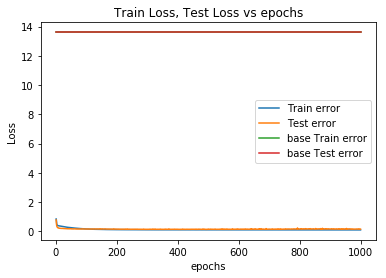

In [13]:
toplot = [trainerror, testerror, basetrainerror, basetrainerror]
labels = ['Train error', 'Test error', 'base Train error', 'base Test error']
graph(toplot, labels, 'Train Loss, Test Loss vs epochs', 'epochs', 'Loss')

## Report

Learning rate used : 0.0001

## Observations

Train Accuracy : 97.8%

Test Accuracy : 94.9%

## 1d

In [14]:
train_loader = data_utils.DataLoader(train_util, batch_size = 8143, shuffle=True)  # batch gradient descent

model = Net(H = 5) # batch gd

optim = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0)
criterion = torch.nn.BCELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_bgd = []
testacc_bgd = []

epoch = 0
while epoch != 1000:

    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_bgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_bgd += [test_acc]

    no_epoch += [epoch]




/home/abhi/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))



Train set 1: Average loss: 1.2902, Training Accuracy : 645/8143 (8%)


Test set 1: Average loss: 1.3418, Test Accuracy : 1029/9752 (11%)


Train set 2: Average loss: 1.0916, Training Accuracy : 775/8143 (10%)


Test set 2: Average loss: 1.0901, Test Accuracy : 1629/9752 (17%)


Train set 3: Average loss: 0.9516, Training Accuracy : 1110/8143 (14%)


Test set 3: Average loss: 0.9465, Test Accuracy : 4819/9752 (49%)


Train set 4: Average loss: 0.8796, Training Accuracy : 4410/8143 (54%)


Test set 4: Average loss: 0.9173, Test Accuracy : 6730/9752 (69%)


Train set 5: Average loss: 0.8683, Training Accuracy : 6285/8143 (77%)


Test set 5: Average loss: 0.9126, Test Accuracy : 7006/9752 (72%)


Train set 6: Average loss: 0.8669, Training Accuracy : 6366/8143 (78%)


Test set 6: Average loss: 0.9094, Test Accuracy : 7169/9752 (74%)


Train set 7: Average loss: 0.8657, Training Accuracy : 6391/8143 (78%)


Test set 7: Average loss: 0.9068, Test Accuracy : 7241/9752 (74%)


Train set 8: Av


Train set 60: Average loss: 0.8059, Training Accuracy : 6414/8143 (79%)


Test set 60: Average loss: 0.8101, Test Accuracy : 7703/9752 (79%)


Train set 61: Average loss: 0.8047, Training Accuracy : 6414/8143 (79%)


Test set 61: Average loss: 0.8083, Test Accuracy : 7703/9752 (79%)


Train set 62: Average loss: 0.8036, Training Accuracy : 6414/8143 (79%)


Test set 62: Average loss: 0.8065, Test Accuracy : 7703/9752 (79%)


Train set 63: Average loss: 0.8025, Training Accuracy : 6414/8143 (79%)


Test set 63: Average loss: 0.8047, Test Accuracy : 7703/9752 (79%)


Train set 64: Average loss: 0.8013, Training Accuracy : 6414/8143 (79%)


Test set 64: Average loss: 0.8029, Test Accuracy : 7703/9752 (79%)


Train set 65: Average loss: 0.8002, Training Accuracy : 6414/8143 (79%)


Test set 65: Average loss: 0.8011, Test Accuracy : 7703/9752 (79%)


Train set 66: Average loss: 0.7990, Training Accuracy : 6414/8143 (79%)


Test set 66: Average loss: 0.7993, Test Accuracy : 7703/9752 (79%)



Train set 118: Average loss: 0.7284, Training Accuracy : 6414/8143 (79%)


Test set 118: Average loss: 0.6973, Test Accuracy : 7703/9752 (79%)


Train set 119: Average loss: 0.7265, Training Accuracy : 6414/8143 (79%)


Test set 119: Average loss: 0.6947, Test Accuracy : 7703/9752 (79%)


Train set 120: Average loss: 0.7246, Training Accuracy : 6414/8143 (79%)


Test set 120: Average loss: 0.6921, Test Accuracy : 7703/9752 (79%)


Train set 121: Average loss: 0.7226, Training Accuracy : 6414/8143 (79%)


Test set 121: Average loss: 0.6895, Test Accuracy : 7703/9752 (79%)


Train set 122: Average loss: 0.7206, Training Accuracy : 6414/8143 (79%)


Test set 122: Average loss: 0.6868, Test Accuracy : 7703/9752 (79%)


Train set 123: Average loss: 0.7185, Training Accuracy : 6414/8143 (79%)


Test set 123: Average loss: 0.6840, Test Accuracy : 7703/9752 (79%)


Train set 124: Average loss: 0.7163, Training Accuracy : 6414/8143 (79%)


Test set 124: Average loss: 0.6811, Test Accuracy : 77


Train set 175: Average loss: 0.5315, Training Accuracy : 7533/8143 (93%)


Test set 175: Average loss: 0.4624, Test Accuracy : 9250/9752 (95%)


Train set 176: Average loss: 0.5298, Training Accuracy : 7528/8143 (92%)


Test set 176: Average loss: 0.4599, Test Accuracy : 9251/9752 (95%)


Train set 177: Average loss: 0.5281, Training Accuracy : 7527/8143 (92%)


Test set 177: Average loss: 0.4575, Test Accuracy : 9251/9752 (95%)


Train set 178: Average loss: 0.5264, Training Accuracy : 7522/8143 (92%)


Test set 178: Average loss: 0.4551, Test Accuracy : 9251/9752 (95%)


Train set 179: Average loss: 0.5247, Training Accuracy : 7520/8143 (92%)


Test set 179: Average loss: 0.4527, Test Accuracy : 9252/9752 (95%)


Train set 180: Average loss: 0.5230, Training Accuracy : 7518/8143 (92%)


Test set 180: Average loss: 0.4504, Test Accuracy : 9250/9752 (95%)


Train set 181: Average loss: 0.5213, Training Accuracy : 7516/8143 (92%)


Test set 181: Average loss: 0.4481, Test Accuracy : 92


Train set 232: Average loss: 0.4579, Training Accuracy : 7504/8143 (92%)


Test set 232: Average loss: 0.3640, Test Accuracy : 9256/9752 (95%)


Train set 233: Average loss: 0.4572, Training Accuracy : 7504/8143 (92%)


Test set 233: Average loss: 0.3630, Test Accuracy : 9258/9752 (95%)


Train set 234: Average loss: 0.4565, Training Accuracy : 7504/8143 (92%)


Test set 234: Average loss: 0.3620, Test Accuracy : 9258/9752 (95%)


Train set 235: Average loss: 0.4558, Training Accuracy : 7505/8143 (92%)


Test set 235: Average loss: 0.3610, Test Accuracy : 9260/9752 (95%)


Train set 236: Average loss: 0.4551, Training Accuracy : 7505/8143 (92%)


Test set 236: Average loss: 0.3600, Test Accuracy : 9262/9752 (95%)


Train set 237: Average loss: 0.4544, Training Accuracy : 7506/8143 (92%)


Test set 237: Average loss: 0.3590, Test Accuracy : 9263/9752 (95%)


Train set 238: Average loss: 0.4537, Training Accuracy : 7504/8143 (92%)


Test set 238: Average loss: 0.3580, Test Accuracy : 92


Train set 289: Average loss: 0.4276, Training Accuracy : 7523/8143 (92%)


Test set 289: Average loss: 0.3155, Test Accuracy : 9255/9752 (95%)


Train set 290: Average loss: 0.4272, Training Accuracy : 7523/8143 (92%)


Test set 290: Average loss: 0.3148, Test Accuracy : 9255/9752 (95%)


Train set 291: Average loss: 0.4268, Training Accuracy : 7522/8143 (92%)


Test set 291: Average loss: 0.3141, Test Accuracy : 9256/9752 (95%)


Train set 292: Average loss: 0.4264, Training Accuracy : 7522/8143 (92%)


Test set 292: Average loss: 0.3135, Test Accuracy : 9255/9752 (95%)


Train set 293: Average loss: 0.4261, Training Accuracy : 7522/8143 (92%)


Test set 293: Average loss: 0.3128, Test Accuracy : 9256/9752 (95%)


Train set 294: Average loss: 0.4257, Training Accuracy : 7522/8143 (92%)


Test set 294: Average loss: 0.3122, Test Accuracy : 9256/9752 (95%)


Train set 295: Average loss: 0.4253, Training Accuracy : 7522/8143 (92%)


Test set 295: Average loss: 0.3115, Test Accuracy : 92


Train set 346: Average loss: 0.4100, Training Accuracy : 7500/8143 (92%)


Test set 346: Average loss: 0.2847, Test Accuracy : 9250/9752 (95%)


Train set 347: Average loss: 0.4097, Training Accuracy : 7501/8143 (92%)


Test set 347: Average loss: 0.2842, Test Accuracy : 9252/9752 (95%)


Train set 348: Average loss: 0.4095, Training Accuracy : 7500/8143 (92%)


Test set 348: Average loss: 0.2838, Test Accuracy : 9253/9752 (95%)


Train set 349: Average loss: 0.4092, Training Accuracy : 7498/8143 (92%)


Test set 349: Average loss: 0.2834, Test Accuracy : 9254/9752 (95%)


Train set 350: Average loss: 0.4090, Training Accuracy : 7498/8143 (92%)


Test set 350: Average loss: 0.2830, Test Accuracy : 9253/9752 (95%)


Train set 351: Average loss: 0.4087, Training Accuracy : 7497/8143 (92%)


Test set 351: Average loss: 0.2825, Test Accuracy : 9253/9752 (95%)


Train set 352: Average loss: 0.4085, Training Accuracy : 7496/8143 (92%)


Test set 352: Average loss: 0.2821, Test Accuracy : 92


Train set 403: Average loss: 0.3977, Training Accuracy : 7459/8143 (92%)


Test set 403: Average loss: 0.2637, Test Accuracy : 9266/9752 (95%)


Train set 404: Average loss: 0.3976, Training Accuracy : 7458/8143 (92%)


Test set 404: Average loss: 0.2634, Test Accuracy : 9267/9752 (95%)


Train set 405: Average loss: 0.3974, Training Accuracy : 7458/8143 (92%)


Test set 405: Average loss: 0.2631, Test Accuracy : 9268/9752 (95%)


Train set 406: Average loss: 0.3972, Training Accuracy : 7458/8143 (92%)


Test set 406: Average loss: 0.2628, Test Accuracy : 9267/9752 (95%)


Train set 407: Average loss: 0.3970, Training Accuracy : 7457/8143 (92%)


Test set 407: Average loss: 0.2625, Test Accuracy : 9267/9752 (95%)


Train set 408: Average loss: 0.3968, Training Accuracy : 7455/8143 (92%)


Test set 408: Average loss: 0.2622, Test Accuracy : 9266/9752 (95%)


Train set 409: Average loss: 0.3967, Training Accuracy : 7455/8143 (92%)


Test set 409: Average loss: 0.2619, Test Accuracy : 92


Test set 459: Average loss: 0.2488, Test Accuracy : 9247/9752 (95%)


Train set 460: Average loss: 0.3888, Training Accuracy : 7439/8143 (91%)


Test set 460: Average loss: 0.2486, Test Accuracy : 9246/9752 (95%)


Train set 461: Average loss: 0.3886, Training Accuracy : 7438/8143 (91%)


Test set 461: Average loss: 0.2484, Test Accuracy : 9246/9752 (95%)


Train set 462: Average loss: 0.3885, Training Accuracy : 7436/8143 (91%)


Test set 462: Average loss: 0.2482, Test Accuracy : 9247/9752 (95%)


Train set 463: Average loss: 0.3884, Training Accuracy : 7432/8143 (91%)


Test set 463: Average loss: 0.2480, Test Accuracy : 9247/9752 (95%)


Train set 464: Average loss: 0.3882, Training Accuracy : 7431/8143 (91%)


Test set 464: Average loss: 0.2478, Test Accuracy : 9247/9752 (95%)


Train set 465: Average loss: 0.3881, Training Accuracy : 7430/8143 (91%)


Test set 465: Average loss: 0.2476, Test Accuracy : 9246/9752 (95%)


Train set 466: Average loss: 0.3880, Training Accuracy : 74


Test set 516: Average loss: 0.2377, Test Accuracy : 9251/9752 (95%)


Train set 517: Average loss: 0.3821, Training Accuracy : 7425/8143 (91%)


Test set 517: Average loss: 0.2375, Test Accuracy : 9250/9752 (95%)


Train set 518: Average loss: 0.3820, Training Accuracy : 7425/8143 (91%)


Test set 518: Average loss: 0.2374, Test Accuracy : 9249/9752 (95%)


Train set 519: Average loss: 0.3819, Training Accuracy : 7423/8143 (91%)


Test set 519: Average loss: 0.2372, Test Accuracy : 9249/9752 (95%)


Train set 520: Average loss: 0.3818, Training Accuracy : 7421/8143 (91%)


Test set 520: Average loss: 0.2371, Test Accuracy : 9248/9752 (95%)


Train set 521: Average loss: 0.3817, Training Accuracy : 7421/8143 (91%)


Test set 521: Average loss: 0.2369, Test Accuracy : 9247/9752 (95%)


Train set 522: Average loss: 0.3816, Training Accuracy : 7419/8143 (91%)


Test set 522: Average loss: 0.2368, Test Accuracy : 9247/9752 (95%)


Train set 523: Average loss: 0.3815, Training Accuracy : 74


Test set 573: Average loss: 0.2294, Test Accuracy : 9248/9752 (95%)


Train set 574: Average loss: 0.3769, Training Accuracy : 7409/8143 (91%)


Test set 574: Average loss: 0.2293, Test Accuracy : 9248/9752 (95%)


Train set 575: Average loss: 0.3768, Training Accuracy : 7409/8143 (91%)


Test set 575: Average loss: 0.2291, Test Accuracy : 9248/9752 (95%)


Train set 576: Average loss: 0.3768, Training Accuracy : 7409/8143 (91%)


Test set 576: Average loss: 0.2290, Test Accuracy : 9248/9752 (95%)


Train set 577: Average loss: 0.3767, Training Accuracy : 7409/8143 (91%)


Test set 577: Average loss: 0.2289, Test Accuracy : 9248/9752 (95%)


Train set 578: Average loss: 0.3766, Training Accuracy : 7409/8143 (91%)


Test set 578: Average loss: 0.2287, Test Accuracy : 9248/9752 (95%)


Train set 579: Average loss: 0.3765, Training Accuracy : 7409/8143 (91%)


Test set 579: Average loss: 0.2286, Test Accuracy : 9248/9752 (95%)


Train set 580: Average loss: 0.3765, Training Accuracy : 74


Test set 630: Average loss: 0.2228, Test Accuracy : 9253/9752 (95%)


Train set 631: Average loss: 0.3729, Training Accuracy : 7405/8143 (91%)


Test set 631: Average loss: 0.2227, Test Accuracy : 9253/9752 (95%)


Train set 632: Average loss: 0.3728, Training Accuracy : 7405/8143 (91%)


Test set 632: Average loss: 0.2226, Test Accuracy : 9253/9752 (95%)


Train set 633: Average loss: 0.3727, Training Accuracy : 7405/8143 (91%)


Test set 633: Average loss: 0.2225, Test Accuracy : 9252/9752 (95%)


Train set 634: Average loss: 0.3727, Training Accuracy : 7405/8143 (91%)


Test set 634: Average loss: 0.2224, Test Accuracy : 9252/9752 (95%)


Train set 635: Average loss: 0.3726, Training Accuracy : 7405/8143 (91%)


Test set 635: Average loss: 0.2223, Test Accuracy : 9252/9752 (95%)


Train set 636: Average loss: 0.3725, Training Accuracy : 7405/8143 (91%)


Test set 636: Average loss: 0.2222, Test Accuracy : 9252/9752 (95%)


Train set 637: Average loss: 0.3725, Training Accuracy : 74


Train set 688: Average loss: 0.3695, Training Accuracy : 7404/8143 (91%)


Test set 688: Average loss: 0.2175, Test Accuracy : 9254/9752 (95%)


Train set 689: Average loss: 0.3694, Training Accuracy : 7404/8143 (91%)


Test set 689: Average loss: 0.2175, Test Accuracy : 9254/9752 (95%)


Train set 690: Average loss: 0.3694, Training Accuracy : 7404/8143 (91%)


Test set 690: Average loss: 0.2174, Test Accuracy : 9254/9752 (95%)


Train set 691: Average loss: 0.3693, Training Accuracy : 7404/8143 (91%)


Test set 691: Average loss: 0.2173, Test Accuracy : 9254/9752 (95%)


Train set 692: Average loss: 0.3692, Training Accuracy : 7404/8143 (91%)


Test set 692: Average loss: 0.2172, Test Accuracy : 9254/9752 (95%)


Train set 693: Average loss: 0.3692, Training Accuracy : 7403/8143 (91%)


Test set 693: Average loss: 0.2171, Test Accuracy : 9254/9752 (95%)


Train set 694: Average loss: 0.3691, Training Accuracy : 7403/8143 (91%)


Test set 694: Average loss: 0.2171, Test Accuracy : 92


Test set 744: Average loss: 0.2136, Test Accuracy : 9256/9752 (95%)


Train set 745: Average loss: 0.3665, Training Accuracy : 7402/8143 (91%)


Test set 745: Average loss: 0.2135, Test Accuracy : 9256/9752 (95%)


Train set 746: Average loss: 0.3664, Training Accuracy : 7402/8143 (91%)


Test set 746: Average loss: 0.2135, Test Accuracy : 9256/9752 (95%)


Train set 747: Average loss: 0.3664, Training Accuracy : 7402/8143 (91%)


Test set 747: Average loss: 0.2134, Test Accuracy : 9256/9752 (95%)


Train set 748: Average loss: 0.3663, Training Accuracy : 7402/8143 (91%)


Test set 748: Average loss: 0.2133, Test Accuracy : 9256/9752 (95%)


Train set 749: Average loss: 0.3663, Training Accuracy : 7402/8143 (91%)


Test set 749: Average loss: 0.2133, Test Accuracy : 9256/9752 (95%)


Train set 750: Average loss: 0.3662, Training Accuracy : 7402/8143 (91%)


Test set 750: Average loss: 0.2132, Test Accuracy : 9256/9752 (95%)


Train set 751: Average loss: 0.3662, Training Accuracy : 74


Train set 802: Average loss: 0.3637, Training Accuracy : 7402/8143 (91%)


Test set 802: Average loss: 0.2103, Test Accuracy : 9257/9752 (95%)


Train set 803: Average loss: 0.3637, Training Accuracy : 7402/8143 (91%)


Test set 803: Average loss: 0.2103, Test Accuracy : 9257/9752 (95%)


Train set 804: Average loss: 0.3636, Training Accuracy : 7402/8143 (91%)


Test set 804: Average loss: 0.2102, Test Accuracy : 9257/9752 (95%)


Train set 805: Average loss: 0.3636, Training Accuracy : 7402/8143 (91%)


Test set 805: Average loss: 0.2102, Test Accuracy : 9257/9752 (95%)


Train set 806: Average loss: 0.3635, Training Accuracy : 7402/8143 (91%)


Test set 806: Average loss: 0.2101, Test Accuracy : 9257/9752 (95%)


Train set 807: Average loss: 0.3635, Training Accuracy : 7402/8143 (91%)


Test set 807: Average loss: 0.2101, Test Accuracy : 9257/9752 (95%)


Train set 808: Average loss: 0.3634, Training Accuracy : 7402/8143 (91%)


Test set 808: Average loss: 0.2100, Test Accuracy : 92


Test set 859: Average loss: 0.2077, Test Accuracy : 9257/9752 (95%)


Train set 860: Average loss: 0.3610, Training Accuracy : 7402/8143 (91%)


Test set 860: Average loss: 0.2077, Test Accuracy : 9258/9752 (95%)


Train set 861: Average loss: 0.3610, Training Accuracy : 7402/8143 (91%)


Test set 861: Average loss: 0.2076, Test Accuracy : 9258/9752 (95%)


Train set 862: Average loss: 0.3609, Training Accuracy : 7402/8143 (91%)


Test set 862: Average loss: 0.2076, Test Accuracy : 9258/9752 (95%)


Train set 863: Average loss: 0.3609, Training Accuracy : 7402/8143 (91%)


Test set 863: Average loss: 0.2076, Test Accuracy : 9257/9752 (95%)


Train set 864: Average loss: 0.3608, Training Accuracy : 7402/8143 (91%)


Test set 864: Average loss: 0.2075, Test Accuracy : 9257/9752 (95%)


Train set 865: Average loss: 0.3608, Training Accuracy : 7402/8143 (91%)


Test set 865: Average loss: 0.2075, Test Accuracy : 9257/9752 (95%)


Train set 866: Average loss: 0.3607, Training Accuracy : 74


Test set 917: Average loss: 0.2054, Test Accuracy : 9259/9752 (95%)


Train set 918: Average loss: 0.3584, Training Accuracy : 7405/8143 (91%)


Test set 918: Average loss: 0.2054, Test Accuracy : 9259/9752 (95%)


Train set 919: Average loss: 0.3584, Training Accuracy : 7405/8143 (91%)


Test set 919: Average loss: 0.2054, Test Accuracy : 9259/9752 (95%)


Train set 920: Average loss: 0.3583, Training Accuracy : 7405/8143 (91%)


Test set 920: Average loss: 0.2053, Test Accuracy : 9259/9752 (95%)


Train set 921: Average loss: 0.3583, Training Accuracy : 7405/8143 (91%)


Test set 921: Average loss: 0.2053, Test Accuracy : 9259/9752 (95%)


Train set 922: Average loss: 0.3582, Training Accuracy : 7405/8143 (91%)


Test set 922: Average loss: 0.2053, Test Accuracy : 9258/9752 (95%)


Train set 923: Average loss: 0.3582, Training Accuracy : 7405/8143 (91%)


Test set 923: Average loss: 0.2052, Test Accuracy : 9258/9752 (95%)


Train set 924: Average loss: 0.3581, Training Accuracy : 74


Train set 975: Average loss: 0.3559, Training Accuracy : 7406/8143 (91%)


Test set 975: Average loss: 0.2035, Test Accuracy : 9255/9752 (95%)


Train set 976: Average loss: 0.3558, Training Accuracy : 7406/8143 (91%)


Test set 976: Average loss: 0.2035, Test Accuracy : 9256/9752 (95%)


Train set 977: Average loss: 0.3558, Training Accuracy : 7406/8143 (91%)


Test set 977: Average loss: 0.2034, Test Accuracy : 9256/9752 (95%)


Train set 978: Average loss: 0.3557, Training Accuracy : 7406/8143 (91%)


Test set 978: Average loss: 0.2034, Test Accuracy : 9256/9752 (95%)


Train set 979: Average loss: 0.3557, Training Accuracy : 7407/8143 (91%)


Test set 979: Average loss: 0.2034, Test Accuracy : 9256/9752 (95%)


Train set 980: Average loss: 0.3557, Training Accuracy : 7406/8143 (91%)


Test set 980: Average loss: 0.2033, Test Accuracy : 9256/9752 (95%)


Train set 981: Average loss: 0.3556, Training Accuracy : 7407/8143 (91%)


Test set 981: Average loss: 0.2033, Test Accuracy : 92

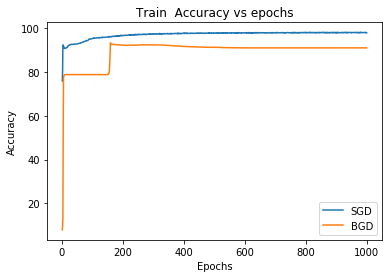

In [15]:
toplot = [trainacc_sgd, trainacc_bgd]
labels = ['SGD', 'BGD']
graph(toplot, labels, 'Train  Accuracy vs epochs', 'Epochs', 'Accuracy')

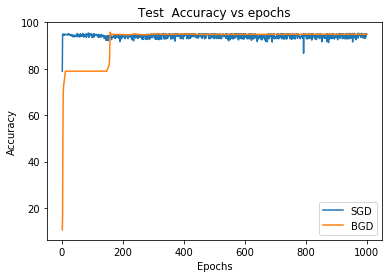

In [16]:
toplot = [testacc_sgd, testacc_bgd]
labels = ['SGD', 'BGD']
graph(toplot, labels, 'Test  Accuracy vs epochs', 'Epochs', 'Accuracy')

## Report

SGD clearly outperforms Batch Gradient descent in terms of train set performance, performs as good as batch gd in terms of test set performance for the particular initial weights.

## Observations

The training heavily depends on the initial weight initialization.

By default the neural network assigns random weights to the neurons, but for the purpose of fairness of comparision I have controlled it using a seed while initializaing the model.

A few initial weights lead to the backward gradent to become 0 and thus no learning happens for those initial weights (run the code with seed = 10 or 7 to observe these results)

## 1e

In [14]:
hidden = [1, 2, 5, 10, 20]

trainaccuracy = []
testaccuracy = []


for H in hidden:
    
    train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle=True)

    model = Net(H) 

    optim = torch.optim.Adam(model.parameters(), lr = 0.0001)
    criterion = torch.nn.BCELoss(size_average = True)

    base_trainerror = baseline(y_train)
    base_testerror = baseline(y_test)
    basetesterror = []
    basetrainerror = []
    trainerror = []
    testerror = []
    no_epoch = []
    trainacc = []
    testacc = []

    epoch = 0

    while epoch != 1000:

        epoch = epoch + 1

        train_error, train_acc = train(epoch) 
        trainerror += [train_error]
        trainacc += [train_acc]

        test_error, test_acc = test(epoch)
        testerror += [test_error]
        testacc += [test_acc]


        no_epoch += [epoch]

    trainaccuracy += [trainacc]
    testaccuracy += [testacc]
    

    




Train set 1: Average loss: 5.8181, Training Accuracy : 1733/8143 (21%)


Test set 1: Average loss: 8.7965, Test Accuracy : 1842/9752 (19%)


Train set 2: Average loss: 5.4519, Training Accuracy : 1733/8143 (21%)


Test set 2: Average loss: 8.3759, Test Accuracy : 1827/9752 (19%)


Train set 3: Average loss: 5.0869, Training Accuracy : 1733/8143 (21%)


Test set 3: Average loss: 7.8810, Test Accuracy : 1793/9752 (18%)


Train set 4: Average loss: 4.7399, Training Accuracy : 1735/8143 (21%)


Test set 4: Average loss: 7.4308, Test Accuracy : 1769/9752 (18%)


Train set 5: Average loss: 4.4193, Training Accuracy : 1732/8143 (21%)


Test set 5: Average loss: 6.8918, Test Accuracy : 1721/9752 (18%)


Train set 6: Average loss: 4.1183, Training Accuracy : 1723/8143 (21%)


Test set 6: Average loss: 6.0863, Test Accuracy : 1697/9752 (17%)


Train set 7: Average loss: 3.8324, Training Accuracy : 1710/8143 (21%)


Test set 7: Average loss: 5.5876, Test Accuracy : 1664/9752 (17%)


Train set 8:


Train set 60: Average loss: 0.6729, Training Accuracy : 6416/8143 (79%)


Test set 60: Average loss: 0.6554, Test Accuracy : 8066/9752 (83%)


Train set 61: Average loss: 0.6717, Training Accuracy : 6426/8143 (79%)


Test set 61: Average loss: 0.6519, Test Accuracy : 8081/9752 (83%)


Train set 62: Average loss: 0.6704, Training Accuracy : 6442/8143 (79%)


Test set 62: Average loss: 0.6481, Test Accuracy : 8092/9752 (83%)


Train set 63: Average loss: 0.6690, Training Accuracy : 6449/8143 (79%)


Test set 63: Average loss: 0.6441, Test Accuracy : 8107/9752 (83%)


Train set 64: Average loss: 0.6675, Training Accuracy : 6466/8143 (79%)


Test set 64: Average loss: 0.6396, Test Accuracy : 8122/9752 (83%)


Train set 65: Average loss: 0.6658, Training Accuracy : 6478/8143 (80%)


Test set 65: Average loss: 0.6350, Test Accuracy : 8145/9752 (84%)


Train set 66: Average loss: 0.6640, Training Accuracy : 6487/8143 (80%)


Test set 66: Average loss: 0.6300, Test Accuracy : 8201/9752 (84%)



Test set 118: Average loss: 0.4239, Test Accuracy : 8209/9752 (84%)


Train set 119: Average loss: 0.5457, Training Accuracy : 6489/8143 (80%)


Test set 119: Average loss: 0.4242, Test Accuracy : 8207/9752 (84%)


Train set 120: Average loss: 0.5445, Training Accuracy : 6488/8143 (80%)


Test set 120: Average loss: 0.4245, Test Accuracy : 8205/9752 (84%)


Train set 121: Average loss: 0.5434, Training Accuracy : 6487/8143 (80%)


Test set 121: Average loss: 0.4226, Test Accuracy : 8202/9752 (84%)


Train set 122: Average loss: 0.5423, Training Accuracy : 6490/8143 (80%)


Test set 122: Average loss: 0.4222, Test Accuracy : 8197/9752 (84%)


Train set 123: Average loss: 0.5413, Training Accuracy : 6491/8143 (80%)


Test set 123: Average loss: 0.4203, Test Accuracy : 8203/9752 (84%)


Train set 124: Average loss: 0.5404, Training Accuracy : 6490/8143 (80%)


Test set 124: Average loss: 0.4187, Test Accuracy : 8203/9752 (84%)


Train set 125: Average loss: 0.5395, Training Accuracy : 64


Train set 177: Average loss: 0.5102, Training Accuracy : 6505/8143 (80%)


Test set 177: Average loss: 0.3872, Test Accuracy : 8203/9752 (84%)


Train set 178: Average loss: 0.5097, Training Accuracy : 6505/8143 (80%)


Test set 178: Average loss: 0.3865, Test Accuracy : 8205/9752 (84%)


Train set 179: Average loss: 0.5092, Training Accuracy : 6505/8143 (80%)


Test set 179: Average loss: 0.3861, Test Accuracy : 8206/9752 (84%)


Train set 180: Average loss: 0.5087, Training Accuracy : 6506/8143 (80%)


Test set 180: Average loss: 0.3865, Test Accuracy : 8199/9752 (84%)


Train set 181: Average loss: 0.5081, Training Accuracy : 6506/8143 (80%)


Test set 181: Average loss: 0.3858, Test Accuracy : 8204/9752 (84%)


Train set 182: Average loss: 0.5076, Training Accuracy : 6507/8143 (80%)


Test set 182: Average loss: 0.3856, Test Accuracy : 8202/9752 (84%)


Train set 183: Average loss: 0.5071, Training Accuracy : 6506/8143 (80%)


Test set 183: Average loss: 0.3851, Test Accuracy : 82


Train set 234: Average loss: 0.4778, Training Accuracy : 6549/8143 (80%)


Test set 234: Average loss: 0.3645, Test Accuracy : 8257/9752 (85%)


Train set 235: Average loss: 0.4772, Training Accuracy : 6558/8143 (81%)


Test set 235: Average loss: 0.3643, Test Accuracy : 8251/9752 (85%)


Train set 236: Average loss: 0.4765, Training Accuracy : 6560/8143 (81%)


Test set 236: Average loss: 0.3638, Test Accuracy : 8255/9752 (85%)


Train set 237: Average loss: 0.4758, Training Accuracy : 6561/8143 (81%)


Test set 237: Average loss: 0.3629, Test Accuracy : 8267/9752 (85%)


Train set 238: Average loss: 0.4752, Training Accuracy : 6559/8143 (81%)


Test set 238: Average loss: 0.3619, Test Accuracy : 8281/9752 (85%)


Train set 239: Average loss: 0.4746, Training Accuracy : 6560/8143 (81%)


Test set 239: Average loss: 0.3615, Test Accuracy : 8283/9752 (85%)


Train set 240: Average loss: 0.4738, Training Accuracy : 6562/8143 (81%)


Test set 240: Average loss: 0.3613, Test Accuracy : 82


Train set 291: Average loss: 0.4363, Training Accuracy : 6639/8143 (82%)


Test set 291: Average loss: 0.3386, Test Accuracy : 8287/9752 (85%)


Train set 292: Average loss: 0.4354, Training Accuracy : 6645/8143 (82%)


Test set 292: Average loss: 0.3379, Test Accuracy : 8290/9752 (85%)


Train set 293: Average loss: 0.4346, Training Accuracy : 6645/8143 (82%)


Test set 293: Average loss: 0.3371, Test Accuracy : 8297/9752 (85%)


Train set 294: Average loss: 0.4338, Training Accuracy : 6642/8143 (82%)


Test set 294: Average loss: 0.3366, Test Accuracy : 8295/9752 (85%)


Train set 295: Average loss: 0.4329, Training Accuracy : 6644/8143 (82%)


Test set 295: Average loss: 0.3356, Test Accuracy : 8303/9752 (85%)


Train set 296: Average loss: 0.4319, Training Accuracy : 6649/8143 (82%)


Test set 296: Average loss: 0.3362, Test Accuracy : 8284/9752 (85%)


Train set 297: Average loss: 0.4312, Training Accuracy : 6647/8143 (82%)


Test set 297: Average loss: 0.3354, Test Accuracy : 82


Train set 348: Average loss: 0.3759, Training Accuracy : 6949/8143 (85%)


Test set 348: Average loss: 0.2964, Test Accuracy : 8392/9752 (86%)


Train set 349: Average loss: 0.3746, Training Accuracy : 6950/8143 (85%)


Test set 349: Average loss: 0.2955, Test Accuracy : 8395/9752 (86%)


Train set 350: Average loss: 0.3733, Training Accuracy : 6953/8143 (85%)


Test set 350: Average loss: 0.2959, Test Accuracy : 8385/9752 (86%)


Train set 351: Average loss: 0.3722, Training Accuracy : 6953/8143 (85%)


Test set 351: Average loss: 0.2949, Test Accuracy : 8389/9752 (86%)


Train set 352: Average loss: 0.3709, Training Accuracy : 6952/8143 (85%)


Test set 352: Average loss: 0.2944, Test Accuracy : 8387/9752 (86%)


Train set 353: Average loss: 0.3697, Training Accuracy : 6957/8143 (85%)


Test set 353: Average loss: 0.2938, Test Accuracy : 8387/9752 (86%)


Train set 354: Average loss: 0.3683, Training Accuracy : 6957/8143 (85%)


Test set 354: Average loss: 0.2927, Test Accuracy : 83


Train set 405: Average loss: 0.3199, Training Accuracy : 7092/8143 (87%)


Test set 405: Average loss: 0.2715, Test Accuracy : 8277/9752 (85%)


Train set 406: Average loss: 0.3190, Training Accuracy : 7086/8143 (87%)


Test set 406: Average loss: 0.2683, Test Accuracy : 8295/9752 (85%)


Train set 407: Average loss: 0.3185, Training Accuracy : 7096/8143 (87%)


Test set 407: Average loss: 0.2657, Test Accuracy : 8323/9752 (85%)


Train set 408: Average loss: 0.3176, Training Accuracy : 7101/8143 (87%)


Test set 408: Average loss: 0.2686, Test Accuracy : 8284/9752 (85%)


Train set 409: Average loss: 0.3169, Training Accuracy : 7103/8143 (87%)


Test set 409: Average loss: 0.2676, Test Accuracy : 8290/9752 (85%)


Train set 410: Average loss: 0.3163, Training Accuracy : 7108/8143 (87%)


Test set 410: Average loss: 0.2667, Test Accuracy : 8293/9752 (85%)


Train set 411: Average loss: 0.3157, Training Accuracy : 7108/8143 (87%)


Test set 411: Average loss: 0.2649, Test Accuracy : 83


Train set 462: Average loss: 0.2292, Training Accuracy : 7865/8143 (97%)


Test set 462: Average loss: 0.2180, Test Accuracy : 8803/9752 (90%)


Train set 463: Average loss: 0.2256, Training Accuracy : 7849/8143 (96%)


Test set 463: Average loss: 0.2129, Test Accuracy : 8848/9752 (91%)


Train set 464: Average loss: 0.2263, Training Accuracy : 7858/8143 (97%)


Test set 464: Average loss: 0.2176, Test Accuracy : 8804/9752 (90%)


Train set 465: Average loss: 0.2239, Training Accuracy : 7838/8143 (96%)


Test set 465: Average loss: 0.2176, Test Accuracy : 8803/9752 (90%)


Train set 466: Average loss: 0.2233, Training Accuracy : 7839/8143 (96%)


Test set 466: Average loss: 0.2127, Test Accuracy : 8840/9752 (91%)


Train set 467: Average loss: 0.2224, Training Accuracy : 7849/8143 (96%)


Test set 467: Average loss: 0.2158, Test Accuracy : 8820/9752 (90%)


Train set 468: Average loss: 0.2209, Training Accuracy : 7831/8143 (96%)


Test set 468: Average loss: 0.2158, Test Accuracy : 88


Train set 519: Average loss: 0.2139, Training Accuracy : 7814/8143 (96%)


Test set 519: Average loss: 0.2051, Test Accuracy : 8722/9752 (89%)


Train set 520: Average loss: 0.2113, Training Accuracy : 7802/8143 (96%)


Test set 520: Average loss: 0.2013, Test Accuracy : 8755/9752 (90%)


Train set 521: Average loss: 0.2123, Training Accuracy : 7813/8143 (96%)


Test set 521: Average loss: 0.2043, Test Accuracy : 8726/9752 (89%)


Train set 522: Average loss: 0.2107, Training Accuracy : 7800/8143 (96%)


Test set 522: Average loss: 0.2009, Test Accuracy : 8753/9752 (90%)


Train set 523: Average loss: 0.2134, Training Accuracy : 7806/8143 (96%)


Test set 523: Average loss: 0.2023, Test Accuracy : 8738/9752 (90%)


Train set 524: Average loss: 0.2134, Training Accuracy : 7812/8143 (96%)


Test set 524: Average loss: 0.2073, Test Accuracy : 8705/9752 (89%)


Train set 525: Average loss: 0.2100, Training Accuracy : 7789/8143 (96%)


Test set 525: Average loss: 0.1984, Test Accuracy : 87


Test set 575: Average loss: 0.1925, Test Accuracy : 8755/9752 (90%)


Train set 576: Average loss: 0.2119, Training Accuracy : 7814/8143 (96%)


Test set 576: Average loss: 0.1920, Test Accuracy : 8759/9752 (90%)


Train set 577: Average loss: 0.2117, Training Accuracy : 7817/8143 (96%)


Test set 577: Average loss: 0.1986, Test Accuracy : 8713/9752 (89%)


Train set 578: Average loss: 0.2121, Training Accuracy : 7801/8143 (96%)


Test set 578: Average loss: 0.1934, Test Accuracy : 8745/9752 (90%)


Train set 579: Average loss: 0.2115, Training Accuracy : 7822/8143 (96%)


Test set 579: Average loss: 0.1953, Test Accuracy : 8730/9752 (90%)


Train set 580: Average loss: 0.2116, Training Accuracy : 7816/8143 (96%)


Test set 580: Average loss: 0.1936, Test Accuracy : 8742/9752 (90%)


Train set 581: Average loss: 0.2118, Training Accuracy : 7821/8143 (96%)


Test set 581: Average loss: 0.1932, Test Accuracy : 8744/9752 (90%)


Train set 582: Average loss: 0.2114, Training Accuracy : 78


Test set 632: Average loss: 0.1956, Test Accuracy : 8721/9752 (89%)


Train set 633: Average loss: 0.2089, Training Accuracy : 7808/8143 (96%)


Test set 633: Average loss: 0.1951, Test Accuracy : 8727/9752 (89%)


Train set 634: Average loss: 0.2099, Training Accuracy : 7803/8143 (96%)


Test set 634: Average loss: 0.1888, Test Accuracy : 8771/9752 (90%)


Train set 635: Average loss: 0.2114, Training Accuracy : 7815/8143 (96%)


Test set 635: Average loss: 0.1923, Test Accuracy : 8739/9752 (90%)


Train set 636: Average loss: 0.2099, Training Accuracy : 7809/8143 (96%)


Test set 636: Average loss: 0.1915, Test Accuracy : 8748/9752 (90%)


Train set 637: Average loss: 0.2101, Training Accuracy : 7807/8143 (96%)


Test set 637: Average loss: 0.1905, Test Accuracy : 8755/9752 (90%)


Train set 638: Average loss: 0.2098, Training Accuracy : 7806/8143 (96%)


Test set 638: Average loss: 0.1911, Test Accuracy : 8750/9752 (90%)


Train set 639: Average loss: 0.2100, Training Accuracy : 78


Train set 690: Average loss: 0.2084, Training Accuracy : 7801/8143 (96%)


Test set 690: Average loss: 0.1943, Test Accuracy : 8727/9752 (89%)


Train set 691: Average loss: 0.2084, Training Accuracy : 7810/8143 (96%)


Test set 691: Average loss: 0.1924, Test Accuracy : 8738/9752 (90%)


Train set 692: Average loss: 0.2116, Training Accuracy : 7808/8143 (96%)


Test set 692: Average loss: 0.1924, Test Accuracy : 8738/9752 (90%)


Train set 693: Average loss: 0.2099, Training Accuracy : 7813/8143 (96%)


Test set 693: Average loss: 0.2005, Test Accuracy : 8685/9752 (89%)


Train set 694: Average loss: 0.2086, Training Accuracy : 7801/8143 (96%)


Test set 694: Average loss: 0.1931, Test Accuracy : 8736/9752 (90%)


Train set 695: Average loss: 0.2088, Training Accuracy : 7805/8143 (96%)


Test set 695: Average loss: 0.1871, Test Accuracy : 8783/9752 (90%)


Train set 696: Average loss: 0.2100, Training Accuracy : 7806/8143 (96%)


Test set 696: Average loss: 0.1909, Test Accuracy : 87


Train set 747: Average loss: 0.2096, Training Accuracy : 7802/8143 (96%)


Test set 747: Average loss: 0.1918, Test Accuracy : 8738/9752 (90%)


Train set 748: Average loss: 0.2092, Training Accuracy : 7802/8143 (96%)


Test set 748: Average loss: 0.2048, Test Accuracy : 8650/9752 (89%)


Train set 749: Average loss: 0.2111, Training Accuracy : 7793/8143 (96%)


Test set 749: Average loss: 0.1940, Test Accuracy : 8724/9752 (89%)


Train set 750: Average loss: 0.2104, Training Accuracy : 7810/8143 (96%)


Test set 750: Average loss: 0.1935, Test Accuracy : 8727/9752 (89%)


Train set 751: Average loss: 0.2088, Training Accuracy : 7805/8143 (96%)


Test set 751: Average loss: 0.1886, Test Accuracy : 8750/9752 (90%)


Train set 752: Average loss: 0.2092, Training Accuracy : 7806/8143 (96%)


Test set 752: Average loss: 0.1909, Test Accuracy : 8741/9752 (90%)


Train set 753: Average loss: 0.2104, Training Accuracy : 7810/8143 (96%)


Test set 753: Average loss: 0.1913, Test Accuracy : 87


Test set 803: Average loss: 0.1931, Test Accuracy : 8724/9752 (89%)


Train set 804: Average loss: 0.2104, Training Accuracy : 7808/8143 (96%)


Test set 804: Average loss: 0.1872, Test Accuracy : 8756/9752 (90%)


Train set 805: Average loss: 0.2103, Training Accuracy : 7810/8143 (96%)


Test set 805: Average loss: 0.1889, Test Accuracy : 8744/9752 (90%)


Train set 806: Average loss: 0.2100, Training Accuracy : 7807/8143 (96%)


Test set 806: Average loss: 0.1921, Test Accuracy : 8728/9752 (89%)


Train set 807: Average loss: 0.2100, Training Accuracy : 7812/8143 (96%)


Test set 807: Average loss: 0.1963, Test Accuracy : 8702/9752 (89%)


Train set 808: Average loss: 0.2115, Training Accuracy : 7805/8143 (96%)


Test set 808: Average loss: 0.1953, Test Accuracy : 8712/9752 (89%)


Train set 809: Average loss: 0.2101, Training Accuracy : 7802/8143 (96%)


Test set 809: Average loss: 0.1903, Test Accuracy : 8738/9752 (90%)


Train set 810: Average loss: 0.2098, Training Accuracy : 78


Train set 862: Average loss: 0.2096, Training Accuracy : 7805/8143 (96%)


Test set 862: Average loss: 0.1885, Test Accuracy : 8746/9752 (90%)


Train set 863: Average loss: 0.2099, Training Accuracy : 7810/8143 (96%)


Test set 863: Average loss: 0.1923, Test Accuracy : 8726/9752 (89%)


Train set 864: Average loss: 0.2096, Training Accuracy : 7806/8143 (96%)


Test set 864: Average loss: 0.1918, Test Accuracy : 8727/9752 (89%)


Train set 865: Average loss: 0.2093, Training Accuracy : 7802/8143 (96%)


Test set 865: Average loss: 0.1863, Test Accuracy : 8757/9752 (90%)


Train set 866: Average loss: 0.2100, Training Accuracy : 7807/8143 (96%)


Test set 866: Average loss: 0.1901, Test Accuracy : 8735/9752 (90%)


Train set 867: Average loss: 0.2094, Training Accuracy : 7811/8143 (96%)


Test set 867: Average loss: 0.1881, Test Accuracy : 8746/9752 (90%)


Train set 868: Average loss: 0.2095, Training Accuracy : 7808/8143 (96%)


Test set 868: Average loss: 0.1879, Test Accuracy : 87


Test set 919: Average loss: 0.1882, Test Accuracy : 8739/9752 (90%)


Train set 920: Average loss: 0.2095, Training Accuracy : 7804/8143 (96%)


Test set 920: Average loss: 0.1919, Test Accuracy : 8721/9752 (89%)


Train set 921: Average loss: 0.2093, Training Accuracy : 7805/8143 (96%)


Test set 921: Average loss: 0.1914, Test Accuracy : 8724/9752 (89%)


Train set 922: Average loss: 0.2097, Training Accuracy : 7806/8143 (96%)


Test set 922: Average loss: 0.1955, Test Accuracy : 8692/9752 (89%)


Train set 923: Average loss: 0.2105, Training Accuracy : 7809/8143 (96%)


Test set 923: Average loss: 0.1867, Test Accuracy : 8748/9752 (90%)


Train set 924: Average loss: 0.2094, Training Accuracy : 7811/8143 (96%)


Test set 924: Average loss: 0.1905, Test Accuracy : 8727/9752 (89%)


Train set 925: Average loss: 0.2095, Training Accuracy : 7808/8143 (96%)


Test set 925: Average loss: 0.1912, Test Accuracy : 8725/9752 (89%)


Train set 926: Average loss: 0.2108, Training Accuracy : 78


Train set 977: Average loss: 0.2104, Training Accuracy : 7804/8143 (96%)


Test set 977: Average loss: 0.1946, Test Accuracy : 8690/9752 (89%)


Train set 978: Average loss: 0.2091, Training Accuracy : 7803/8143 (96%)


Test set 978: Average loss: 0.1899, Test Accuracy : 8727/9752 (89%)


Train set 979: Average loss: 0.2102, Training Accuracy : 7809/8143 (96%)


Test set 979: Average loss: 0.1900, Test Accuracy : 8726/9752 (89%)


Train set 980: Average loss: 0.2088, Training Accuracy : 7806/8143 (96%)


Test set 980: Average loss: 0.1866, Test Accuracy : 8741/9752 (90%)


Train set 981: Average loss: 0.2088, Training Accuracy : 7803/8143 (96%)


Test set 981: Average loss: 0.1843, Test Accuracy : 8757/9752 (90%)


Train set 982: Average loss: 0.2090, Training Accuracy : 7807/8143 (96%)


Test set 982: Average loss: 0.1868, Test Accuracy : 8739/9752 (90%)


Train set 983: Average loss: 0.2103, Training Accuracy : 7814/8143 (96%)


Test set 983: Average loss: 0.1902, Test Accuracy : 87


Train set 36: Average loss: 0.3710, Training Accuracy : 7213/8143 (89%)


Test set 36: Average loss: 0.2385, Test Accuracy : 9171/9752 (94%)


Train set 37: Average loss: 0.3674, Training Accuracy : 7258/8143 (89%)


Test set 37: Average loss: 0.2357, Test Accuracy : 9163/9752 (94%)


Train set 38: Average loss: 0.3641, Training Accuracy : 7257/8143 (89%)


Test set 38: Average loss: 0.2301, Test Accuracy : 9182/9752 (94%)


Train set 39: Average loss: 0.3612, Training Accuracy : 7265/8143 (89%)


Test set 39: Average loss: 0.2249, Test Accuracy : 9230/9752 (95%)


Train set 40: Average loss: 0.3581, Training Accuracy : 7229/8143 (89%)


Test set 40: Average loss: 0.2260, Test Accuracy : 9152/9752 (94%)


Train set 41: Average loss: 0.3552, Training Accuracy : 7308/8143 (90%)


Test set 41: Average loss: 0.2186, Test Accuracy : 9230/9752 (95%)


Train set 42: Average loss: 0.3521, Training Accuracy : 7337/8143 (90%)


Test set 42: Average loss: 0.2152, Test Accuracy : 9240/9752 (95%)



Train set 95: Average loss: 0.1431, Training Accuracy : 7774/8143 (95%)


Test set 95: Average loss: 0.2515, Test Accuracy : 8958/9752 (92%)


Train set 96: Average loss: 0.1411, Training Accuracy : 7775/8143 (95%)


Test set 96: Average loss: 0.2513, Test Accuracy : 8956/9752 (92%)


Train set 97: Average loss: 0.1390, Training Accuracy : 7783/8143 (96%)


Test set 97: Average loss: 0.2446, Test Accuracy : 8957/9752 (92%)


Train set 98: Average loss: 0.1369, Training Accuracy : 7785/8143 (96%)


Test set 98: Average loss: 0.2390, Test Accuracy : 8967/9752 (92%)


Train set 99: Average loss: 0.1352, Training Accuracy : 7784/8143 (96%)


Test set 99: Average loss: 0.2365, Test Accuracy : 8967/9752 (92%)


Train set 100: Average loss: 0.1332, Training Accuracy : 7790/8143 (96%)


Test set 100: Average loss: 0.2359, Test Accuracy : 8968/9752 (92%)


Train set 101: Average loss: 0.1315, Training Accuracy : 7794/8143 (96%)


Test set 101: Average loss: 0.2323, Test Accuracy : 8974/9752 (9


Train set 153: Average loss: 0.0753, Training Accuracy : 8010/8143 (98%)


Test set 153: Average loss: 0.0982, Test Accuracy : 9326/9752 (96%)


Train set 154: Average loss: 0.0748, Training Accuracy : 8011/8143 (98%)


Test set 154: Average loss: 0.0965, Test Accuracy : 9329/9752 (96%)


Train set 155: Average loss: 0.0743, Training Accuracy : 8016/8143 (98%)


Test set 155: Average loss: 0.0940, Test Accuracy : 9340/9752 (96%)


Train set 156: Average loss: 0.0738, Training Accuracy : 8018/8143 (98%)


Test set 156: Average loss: 0.0921, Test Accuracy : 9342/9752 (96%)


Train set 157: Average loss: 0.0733, Training Accuracy : 8019/8143 (98%)


Test set 157: Average loss: 0.0904, Test Accuracy : 9347/9752 (96%)


Train set 158: Average loss: 0.0729, Training Accuracy : 8020/8143 (98%)


Test set 158: Average loss: 0.0893, Test Accuracy : 9348/9752 (96%)


Train set 159: Average loss: 0.0725, Training Accuracy : 8017/8143 (98%)


Test set 159: Average loss: 0.0881, Test Accuracy : 93


Train set 210: Average loss: 0.0657, Training Accuracy : 8021/8143 (99%)


Test set 210: Average loss: 0.0655, Test Accuracy : 9469/9752 (97%)


Train set 211: Average loss: 0.0656, Training Accuracy : 8024/8143 (99%)


Test set 211: Average loss: 0.0644, Test Accuracy : 9485/9752 (97%)


Train set 212: Average loss: 0.0655, Training Accuracy : 8020/8143 (98%)


Test set 212: Average loss: 0.0685, Test Accuracy : 9451/9752 (97%)


Train set 213: Average loss: 0.0654, Training Accuracy : 8020/8143 (98%)


Test set 213: Average loss: 0.0639, Test Accuracy : 9490/9752 (97%)


Train set 214: Average loss: 0.0653, Training Accuracy : 8023/8143 (99%)


Test set 214: Average loss: 0.0641, Test Accuracy : 9492/9752 (97%)


Train set 215: Average loss: 0.0652, Training Accuracy : 8021/8143 (99%)


Test set 215: Average loss: 0.0619, Test Accuracy : 9508/9752 (97%)


Train set 216: Average loss: 0.0653, Training Accuracy : 8022/8143 (99%)


Test set 216: Average loss: 0.0632, Test Accuracy : 95


Train set 268: Average loss: 0.0626, Training Accuracy : 8023/8143 (99%)


Test set 268: Average loss: 0.0583, Test Accuracy : 9561/9752 (98%)


Train set 269: Average loss: 0.0626, Training Accuracy : 8021/8143 (99%)


Test set 269: Average loss: 0.0614, Test Accuracy : 9540/9752 (98%)


Train set 270: Average loss: 0.0625, Training Accuracy : 8024/8143 (99%)


Test set 270: Average loss: 0.0575, Test Accuracy : 9563/9752 (98%)


Train set 271: Average loss: 0.0627, Training Accuracy : 8024/8143 (99%)


Test set 271: Average loss: 0.0562, Test Accuracy : 9579/9752 (98%)


Train set 272: Average loss: 0.0627, Training Accuracy : 8023/8143 (99%)


Test set 272: Average loss: 0.0590, Test Accuracy : 9560/9752 (98%)


Train set 273: Average loss: 0.0624, Training Accuracy : 8023/8143 (99%)


Test set 273: Average loss: 0.0579, Test Accuracy : 9562/9752 (98%)


Train set 274: Average loss: 0.0626, Training Accuracy : 8021/8143 (99%)


Test set 274: Average loss: 0.0583, Test Accuracy : 95


Train set 325: Average loss: 0.0609, Training Accuracy : 8023/8143 (99%)


Test set 325: Average loss: 0.0549, Test Accuracy : 9600/9752 (98%)


Train set 326: Average loss: 0.0610, Training Accuracy : 8026/8143 (99%)


Test set 326: Average loss: 0.0550, Test Accuracy : 9604/9752 (98%)


Train set 327: Average loss: 0.0609, Training Accuracy : 8024/8143 (99%)


Test set 327: Average loss: 0.0573, Test Accuracy : 9571/9752 (98%)


Train set 328: Average loss: 0.0608, Training Accuracy : 8024/8143 (99%)


Test set 328: Average loss: 0.0540, Test Accuracy : 9619/9752 (99%)


Train set 329: Average loss: 0.0607, Training Accuracy : 8025/8143 (99%)


Test set 329: Average loss: 0.0578, Test Accuracy : 9567/9752 (98%)


Train set 330: Average loss: 0.0608, Training Accuracy : 8027/8143 (99%)


Test set 330: Average loss: 0.0561, Test Accuracy : 9577/9752 (98%)


Train set 331: Average loss: 0.0608, Training Accuracy : 8025/8143 (99%)


Test set 331: Average loss: 0.0551, Test Accuracy : 95


Test set 382: Average loss: 0.0550, Test Accuracy : 9608/9752 (99%)


Train set 383: Average loss: 0.0595, Training Accuracy : 8026/8143 (99%)


Test set 383: Average loss: 0.0516, Test Accuracy : 9650/9752 (99%)


Train set 384: Average loss: 0.0595, Training Accuracy : 8027/8143 (99%)


Test set 384: Average loss: 0.0558, Test Accuracy : 9603/9752 (98%)


Train set 385: Average loss: 0.0598, Training Accuracy : 8025/8143 (99%)


Test set 385: Average loss: 0.0539, Test Accuracy : 9618/9752 (99%)


Train set 386: Average loss: 0.0594, Training Accuracy : 8028/8143 (99%)


Test set 386: Average loss: 0.0514, Test Accuracy : 9654/9752 (99%)


Train set 387: Average loss: 0.0594, Training Accuracy : 8027/8143 (99%)


Test set 387: Average loss: 0.0538, Test Accuracy : 9626/9752 (99%)


Train set 388: Average loss: 0.0594, Training Accuracy : 8027/8143 (99%)


Test set 388: Average loss: 0.0542, Test Accuracy : 9614/9752 (99%)


Train set 389: Average loss: 0.0596, Training Accuracy : 80


Test set 440: Average loss: 0.0486, Test Accuracy : 9667/9752 (99%)


Train set 441: Average loss: 0.0586, Training Accuracy : 8034/8143 (99%)


Test set 441: Average loss: 0.0498, Test Accuracy : 9659/9752 (99%)


Train set 442: Average loss: 0.0584, Training Accuracy : 8033/8143 (99%)


Test set 442: Average loss: 0.0490, Test Accuracy : 9665/9752 (99%)


Train set 443: Average loss: 0.0585, Training Accuracy : 8028/8143 (99%)


Test set 443: Average loss: 0.0484, Test Accuracy : 9668/9752 (99%)


Train set 444: Average loss: 0.0583, Training Accuracy : 8035/8143 (99%)


Test set 444: Average loss: 0.0499, Test Accuracy : 9658/9752 (99%)


Train set 445: Average loss: 0.0583, Training Accuracy : 8034/8143 (99%)


Test set 445: Average loss: 0.0480, Test Accuracy : 9673/9752 (99%)


Train set 446: Average loss: 0.0584, Training Accuracy : 8034/8143 (99%)


Test set 446: Average loss: 0.0508, Test Accuracy : 9655/9752 (99%)


Train set 447: Average loss: 0.0584, Training Accuracy : 80


Train set 499: Average loss: 0.0574, Training Accuracy : 8042/8143 (99%)


Test set 499: Average loss: 0.0491, Test Accuracy : 9663/9752 (99%)


Train set 500: Average loss: 0.0573, Training Accuracy : 8043/8143 (99%)


Test set 500: Average loss: 0.0481, Test Accuracy : 9672/9752 (99%)


Train set 501: Average loss: 0.0573, Training Accuracy : 8041/8143 (99%)


Test set 501: Average loss: 0.0500, Test Accuracy : 9661/9752 (99%)


Train set 502: Average loss: 0.0573, Training Accuracy : 8041/8143 (99%)


Test set 502: Average loss: 0.0457, Test Accuracy : 9684/9752 (99%)


Train set 503: Average loss: 0.0574, Training Accuracy : 8042/8143 (99%)


Test set 503: Average loss: 0.0447, Test Accuracy : 9685/9752 (99%)


Train set 504: Average loss: 0.0574, Training Accuracy : 8044/8143 (99%)


Test set 504: Average loss: 0.0484, Test Accuracy : 9672/9752 (99%)


Train set 505: Average loss: 0.0573, Training Accuracy : 8044/8143 (99%)


Test set 505: Average loss: 0.0495, Test Accuracy : 96


Train set 556: Average loss: 0.0565, Training Accuracy : 8050/8143 (99%)


Test set 556: Average loss: 0.0442, Test Accuracy : 9682/9752 (99%)


Train set 557: Average loss: 0.0564, Training Accuracy : 8050/8143 (99%)


Test set 557: Average loss: 0.0464, Test Accuracy : 9678/9752 (99%)


Train set 558: Average loss: 0.0565, Training Accuracy : 8049/8143 (99%)


Test set 558: Average loss: 0.0473, Test Accuracy : 9674/9752 (99%)


Train set 559: Average loss: 0.0564, Training Accuracy : 8046/8143 (99%)


Test set 559: Average loss: 0.0441, Test Accuracy : 9681/9752 (99%)


Train set 560: Average loss: 0.0563, Training Accuracy : 8050/8143 (99%)


Test set 560: Average loss: 0.0474, Test Accuracy : 9674/9752 (99%)


Train set 561: Average loss: 0.0567, Training Accuracy : 8050/8143 (99%)


Test set 561: Average loss: 0.0478, Test Accuracy : 9672/9752 (99%)


Train set 562: Average loss: 0.0563, Training Accuracy : 8050/8143 (99%)


Test set 562: Average loss: 0.0449, Test Accuracy : 96


Test set 612: Average loss: 0.0431, Test Accuracy : 9683/9752 (99%)


Train set 613: Average loss: 0.0558, Training Accuracy : 8050/8143 (99%)


Test set 613: Average loss: 0.0437, Test Accuracy : 9683/9752 (99%)


Train set 614: Average loss: 0.0557, Training Accuracy : 8050/8143 (99%)


Test set 614: Average loss: 0.0423, Test Accuracy : 9686/9752 (99%)


Train set 615: Average loss: 0.0556, Training Accuracy : 8052/8143 (99%)


Test set 615: Average loss: 0.0460, Test Accuracy : 9679/9752 (99%)


Train set 616: Average loss: 0.0560, Training Accuracy : 8048/8143 (99%)


Test set 616: Average loss: 0.0455, Test Accuracy : 9679/9752 (99%)


Train set 617: Average loss: 0.0557, Training Accuracy : 8050/8143 (99%)


Test set 617: Average loss: 0.0423, Test Accuracy : 9686/9752 (99%)


Train set 618: Average loss: 0.0556, Training Accuracy : 8051/8143 (99%)


Test set 618: Average loss: 0.0463, Test Accuracy : 9677/9752 (99%)


Train set 619: Average loss: 0.0557, Training Accuracy : 80


Train set 670: Average loss: 0.0552, Training Accuracy : 8052/8143 (99%)


Test set 670: Average loss: 0.0429, Test Accuracy : 9682/9752 (99%)


Train set 671: Average loss: 0.0551, Training Accuracy : 8050/8143 (99%)


Test set 671: Average loss: 0.0437, Test Accuracy : 9681/9752 (99%)


Train set 672: Average loss: 0.0553, Training Accuracy : 8052/8143 (99%)


Test set 672: Average loss: 0.0439, Test Accuracy : 9681/9752 (99%)


Train set 673: Average loss: 0.0553, Training Accuracy : 8044/8143 (99%)


Test set 673: Average loss: 0.0402, Test Accuracy : 9689/9752 (99%)


Train set 674: Average loss: 0.0552, Training Accuracy : 8050/8143 (99%)


Test set 674: Average loss: 0.0424, Test Accuracy : 9684/9752 (99%)


Train set 675: Average loss: 0.0551, Training Accuracy : 8051/8143 (99%)


Test set 675: Average loss: 0.0418, Test Accuracy : 9685/9752 (99%)


Train set 676: Average loss: 0.0554, Training Accuracy : 8048/8143 (99%)


Test set 676: Average loss: 0.0417, Test Accuracy : 96


Train set 727: Average loss: 0.0550, Training Accuracy : 8050/8143 (99%)


Test set 727: Average loss: 0.0433, Test Accuracy : 9680/9752 (99%)


Train set 728: Average loss: 0.0547, Training Accuracy : 8050/8143 (99%)


Test set 728: Average loss: 0.0422, Test Accuracy : 9681/9752 (99%)


Train set 729: Average loss: 0.0547, Training Accuracy : 8050/8143 (99%)


Test set 729: Average loss: 0.0413, Test Accuracy : 9686/9752 (99%)


Train set 730: Average loss: 0.0547, Training Accuracy : 8051/8143 (99%)


Test set 730: Average loss: 0.0413, Test Accuracy : 9686/9752 (99%)


Train set 731: Average loss: 0.0545, Training Accuracy : 8051/8143 (99%)


Test set 731: Average loss: 0.0453, Test Accuracy : 9679/9752 (99%)


Train set 732: Average loss: 0.0548, Training Accuracy : 8042/8143 (99%)


Test set 732: Average loss: 0.0400, Test Accuracy : 9687/9752 (99%)


Train set 733: Average loss: 0.0547, Training Accuracy : 8051/8143 (99%)


Test set 733: Average loss: 0.0413, Test Accuracy : 96


Train set 784: Average loss: 0.0546, Training Accuracy : 8050/8143 (99%)


Test set 784: Average loss: 0.0450, Test Accuracy : 9676/9752 (99%)


Train set 785: Average loss: 0.0543, Training Accuracy : 8050/8143 (99%)


Test set 785: Average loss: 0.0413, Test Accuracy : 9684/9752 (99%)


Train set 786: Average loss: 0.0544, Training Accuracy : 8052/8143 (99%)


Test set 786: Average loss: 0.0413, Test Accuracy : 9684/9752 (99%)


Train set 787: Average loss: 0.0544, Training Accuracy : 8051/8143 (99%)


Test set 787: Average loss: 0.0424, Test Accuracy : 9680/9752 (99%)


Train set 788: Average loss: 0.0544, Training Accuracy : 8049/8143 (99%)


Test set 788: Average loss: 0.0408, Test Accuracy : 9685/9752 (99%)


Train set 789: Average loss: 0.0545, Training Accuracy : 8051/8143 (99%)


Test set 789: Average loss: 0.0423, Test Accuracy : 9681/9752 (99%)


Train set 790: Average loss: 0.0543, Training Accuracy : 8051/8143 (99%)


Test set 790: Average loss: 0.0396, Test Accuracy : 96


Train set 841: Average loss: 0.0540, Training Accuracy : 8051/8143 (99%)


Test set 841: Average loss: 0.0432, Test Accuracy : 9676/9752 (99%)


Train set 842: Average loss: 0.0539, Training Accuracy : 8052/8143 (99%)


Test set 842: Average loss: 0.0410, Test Accuracy : 9679/9752 (99%)


Train set 843: Average loss: 0.0539, Training Accuracy : 8052/8143 (99%)


Test set 843: Average loss: 0.0452, Test Accuracy : 9664/9752 (99%)


Train set 844: Average loss: 0.0539, Training Accuracy : 8051/8143 (99%)


Test set 844: Average loss: 0.0452, Test Accuracy : 9667/9752 (99%)


Train set 845: Average loss: 0.0539, Training Accuracy : 8055/8143 (99%)


Test set 845: Average loss: 0.0427, Test Accuracy : 9675/9752 (99%)


Train set 846: Average loss: 0.0539, Training Accuracy : 8051/8143 (99%)


Test set 846: Average loss: 0.0447, Test Accuracy : 9668/9752 (99%)


Train set 847: Average loss: 0.0540, Training Accuracy : 8051/8143 (99%)


Test set 847: Average loss: 0.0423, Test Accuracy : 96


Test set 898: Average loss: 0.0412, Test Accuracy : 9678/9752 (99%)


Train set 899: Average loss: 0.0538, Training Accuracy : 8045/8143 (99%)


Test set 899: Average loss: 0.0401, Test Accuracy : 9683/9752 (99%)


Train set 900: Average loss: 0.0536, Training Accuracy : 8053/8143 (99%)


Test set 900: Average loss: 0.0428, Test Accuracy : 9675/9752 (99%)


Train set 901: Average loss: 0.0537, Training Accuracy : 8053/8143 (99%)


Test set 901: Average loss: 0.0420, Test Accuracy : 9676/9752 (99%)


Train set 902: Average loss: 0.0536, Training Accuracy : 8051/8143 (99%)


Test set 902: Average loss: 0.0414, Test Accuracy : 9678/9752 (99%)


Train set 903: Average loss: 0.0540, Training Accuracy : 8047/8143 (99%)


Test set 903: Average loss: 0.0398, Test Accuracy : 9683/9752 (99%)


Train set 904: Average loss: 0.0536, Training Accuracy : 8051/8143 (99%)


Test set 904: Average loss: 0.0441, Test Accuracy : 9672/9752 (99%)


Train set 905: Average loss: 0.0537, Training Accuracy : 80


Train set 956: Average loss: 0.0534, Training Accuracy : 8051/8143 (99%)


Test set 956: Average loss: 0.0409, Test Accuracy : 9678/9752 (99%)


Train set 957: Average loss: 0.0534, Training Accuracy : 8051/8143 (99%)


Test set 957: Average loss: 0.0425, Test Accuracy : 9675/9752 (99%)


Train set 958: Average loss: 0.0533, Training Accuracy : 8052/8143 (99%)


Test set 958: Average loss: 0.0461, Test Accuracy : 9661/9752 (99%)


Train set 959: Average loss: 0.0534, Training Accuracy : 8051/8143 (99%)


Test set 959: Average loss: 0.0416, Test Accuracy : 9678/9752 (99%)


Train set 960: Average loss: 0.0534, Training Accuracy : 8052/8143 (99%)


Test set 960: Average loss: 0.0405, Test Accuracy : 9680/9752 (99%)


Train set 961: Average loss: 0.0536, Training Accuracy : 8049/8143 (99%)


Test set 961: Average loss: 0.0416, Test Accuracy : 9675/9752 (99%)


Train set 962: Average loss: 0.0535, Training Accuracy : 8052/8143 (99%)


Test set 962: Average loss: 0.0417, Test Accuracy : 96


Train set 14: Average loss: 0.3411, Training Accuracy : 7565/8143 (93%)


Test set 14: Average loss: 0.2167, Test Accuracy : 9379/9752 (96%)


Train set 15: Average loss: 0.3304, Training Accuracy : 7581/8143 (93%)


Test set 15: Average loss: 0.2082, Test Accuracy : 9410/9752 (96%)


Train set 16: Average loss: 0.3202, Training Accuracy : 7589/8143 (93%)


Test set 16: Average loss: 0.1981, Test Accuracy : 9403/9752 (96%)


Train set 17: Average loss: 0.3110, Training Accuracy : 7595/8143 (93%)


Test set 17: Average loss: 0.1900, Test Accuracy : 9414/9752 (97%)


Train set 18: Average loss: 0.3025, Training Accuracy : 7606/8143 (93%)


Test set 18: Average loss: 0.1832, Test Accuracy : 9426/9752 (97%)


Train set 19: Average loss: 0.2937, Training Accuracy : 7620/8143 (94%)


Test set 19: Average loss: 0.1755, Test Accuracy : 9429/9752 (97%)


Train set 20: Average loss: 0.2862, Training Accuracy : 7628/8143 (94%)


Test set 20: Average loss: 0.1725, Test Accuracy : 9461/9752 (97%)



Train set 72: Average loss: 0.1017, Training Accuracy : 7955/8143 (98%)


Test set 72: Average loss: 0.1250, Test Accuracy : 9309/9752 (95%)


Train set 73: Average loss: 0.1010, Training Accuracy : 7951/8143 (98%)


Test set 73: Average loss: 0.1387, Test Accuracy : 9233/9752 (95%)


Train set 74: Average loss: 0.1004, Training Accuracy : 7958/8143 (98%)


Test set 74: Average loss: 0.1294, Test Accuracy : 9298/9752 (95%)


Train set 75: Average loss: 0.1000, Training Accuracy : 7956/8143 (98%)


Test set 75: Average loss: 0.1330, Test Accuracy : 9276/9752 (95%)


Train set 76: Average loss: 0.0991, Training Accuracy : 7955/8143 (98%)


Test set 76: Average loss: 0.1349, Test Accuracy : 9268/9752 (95%)


Train set 77: Average loss: 0.0986, Training Accuracy : 7970/8143 (98%)


Test set 77: Average loss: 0.1354, Test Accuracy : 9260/9752 (95%)


Train set 78: Average loss: 0.0984, Training Accuracy : 7951/8143 (98%)


Test set 78: Average loss: 0.1289, Test Accuracy : 9293/9752 (95%)



Train set 130: Average loss: 0.0873, Training Accuracy : 7967/8143 (98%)


Test set 130: Average loss: 0.1580, Test Accuracy : 9103/9752 (93%)


Train set 131: Average loss: 0.0867, Training Accuracy : 7941/8143 (98%)


Test set 131: Average loss: 0.1448, Test Accuracy : 9236/9752 (95%)


Train set 132: Average loss: 0.0870, Training Accuracy : 7950/8143 (98%)


Test set 132: Average loss: 0.1520, Test Accuracy : 9157/9752 (94%)


Train set 133: Average loss: 0.0869, Training Accuracy : 7950/8143 (98%)


Test set 133: Average loss: 0.1586, Test Accuracy : 9098/9752 (93%)


Train set 134: Average loss: 0.0868, Training Accuracy : 7949/8143 (98%)


Test set 134: Average loss: 0.1462, Test Accuracy : 9216/9752 (95%)


Train set 135: Average loss: 0.0867, Training Accuracy : 7953/8143 (98%)


Test set 135: Average loss: 0.1605, Test Accuracy : 9086/9752 (93%)


Train set 136: Average loss: 0.0868, Training Accuracy : 7947/8143 (98%)


Test set 136: Average loss: 0.1534, Test Accuracy : 91


Train set 188: Average loss: 0.0840, Training Accuracy : 7934/8143 (97%)


Test set 188: Average loss: 0.1506, Test Accuracy : 9097/9752 (93%)


Train set 189: Average loss: 0.0838, Training Accuracy : 7941/8143 (98%)


Test set 189: Average loss: 0.1619, Test Accuracy : 8999/9752 (92%)


Train set 190: Average loss: 0.0842, Training Accuracy : 7931/8143 (97%)


Test set 190: Average loss: 0.1482, Test Accuracy : 9107/9752 (93%)


Train set 191: Average loss: 0.0839, Training Accuracy : 7935/8143 (97%)


Test set 191: Average loss: 0.1591, Test Accuracy : 9050/9752 (93%)


Train set 192: Average loss: 0.0842, Training Accuracy : 7933/8143 (97%)


Test set 192: Average loss: 0.1619, Test Accuracy : 9009/9752 (92%)


Train set 193: Average loss: 0.0838, Training Accuracy : 7936/8143 (97%)


Test set 193: Average loss: 0.1536, Test Accuracy : 9087/9752 (93%)


Train set 194: Average loss: 0.0840, Training Accuracy : 7940/8143 (98%)


Test set 194: Average loss: 0.1593, Test Accuracy : 90


Train set 245: Average loss: 0.0827, Training Accuracy : 7936/8143 (97%)


Test set 245: Average loss: 0.1543, Test Accuracy : 9073/9752 (93%)


Train set 246: Average loss: 0.0830, Training Accuracy : 7932/8143 (97%)


Test set 246: Average loss: 0.1470, Test Accuracy : 9106/9752 (93%)


Train set 247: Average loss: 0.0826, Training Accuracy : 7931/8143 (97%)


Test set 247: Average loss: 0.1469, Test Accuracy : 9106/9752 (93%)


Train set 248: Average loss: 0.0828, Training Accuracy : 7945/8143 (98%)


Test set 248: Average loss: 0.1561, Test Accuracy : 9062/9752 (93%)


Train set 249: Average loss: 0.0825, Training Accuracy : 7935/8143 (97%)


Test set 249: Average loss: 0.1580, Test Accuracy : 9043/9752 (93%)


Train set 250: Average loss: 0.0838, Training Accuracy : 7928/8143 (97%)


Test set 250: Average loss: 0.1640, Test Accuracy : 8964/9752 (92%)


Train set 251: Average loss: 0.0829, Training Accuracy : 7929/8143 (97%)


Test set 251: Average loss: 0.1488, Test Accuracy : 90


Test set 302: Average loss: 0.1589, Test Accuracy : 9005/9752 (92%)


Train set 303: Average loss: 0.0820, Training Accuracy : 7935/8143 (97%)


Test set 303: Average loss: 0.1563, Test Accuracy : 9035/9752 (93%)


Train set 304: Average loss: 0.0818, Training Accuracy : 7936/8143 (97%)


Test set 304: Average loss: 0.1567, Test Accuracy : 9030/9752 (93%)


Train set 305: Average loss: 0.0815, Training Accuracy : 7930/8143 (97%)


Test set 305: Average loss: 0.1438, Test Accuracy : 9115/9752 (93%)


Train set 306: Average loss: 0.0820, Training Accuracy : 7936/8143 (97%)


Test set 306: Average loss: 0.1584, Test Accuracy : 9005/9752 (92%)


Train set 307: Average loss: 0.0816, Training Accuracy : 7931/8143 (97%)


Test set 307: Average loss: 0.1494, Test Accuracy : 9089/9752 (93%)


Train set 308: Average loss: 0.0818, Training Accuracy : 7933/8143 (97%)


Test set 308: Average loss: 0.1396, Test Accuracy : 9143/9752 (94%)


Train set 309: Average loss: 0.0824, Training Accuracy : 79


Test set 359: Average loss: 0.1507, Test Accuracy : 9078/9752 (93%)


Train set 360: Average loss: 0.0812, Training Accuracy : 7933/8143 (97%)


Test set 360: Average loss: 0.1455, Test Accuracy : 9105/9752 (93%)


Train set 361: Average loss: 0.0806, Training Accuracy : 7951/8143 (98%)


Test set 361: Average loss: 0.1631, Test Accuracy : 8961/9752 (92%)


Train set 362: Average loss: 0.0822, Training Accuracy : 7929/8143 (97%)


Test set 362: Average loss: 0.1509, Test Accuracy : 9079/9752 (93%)


Train set 363: Average loss: 0.0811, Training Accuracy : 7933/8143 (97%)


Test set 363: Average loss: 0.1459, Test Accuracy : 9103/9752 (93%)


Train set 364: Average loss: 0.0813, Training Accuracy : 7938/8143 (97%)


Test set 364: Average loss: 0.1535, Test Accuracy : 9064/9752 (93%)


Train set 365: Average loss: 0.0808, Training Accuracy : 7928/8143 (97%)


Test set 365: Average loss: 0.1420, Test Accuracy : 9120/9752 (94%)


Train set 366: Average loss: 0.0811, Training Accuracy : 79


Train set 418: Average loss: 0.0804, Training Accuracy : 7941/8143 (98%)


Test set 418: Average loss: 0.1361, Test Accuracy : 9188/9752 (94%)


Train set 419: Average loss: 0.0806, Training Accuracy : 7965/8143 (98%)


Test set 419: Average loss: 0.1517, Test Accuracy : 9079/9752 (93%)


Train set 420: Average loss: 0.0807, Training Accuracy : 7936/8143 (97%)


Test set 420: Average loss: 0.1447, Test Accuracy : 9111/9752 (93%)


Train set 421: Average loss: 0.0806, Training Accuracy : 7943/8143 (98%)


Test set 421: Average loss: 0.1435, Test Accuracy : 9115/9752 (93%)


Train set 422: Average loss: 0.0805, Training Accuracy : 7935/8143 (97%)


Test set 422: Average loss: 0.1404, Test Accuracy : 9129/9752 (94%)


Train set 423: Average loss: 0.0808, Training Accuracy : 7958/8143 (98%)


Test set 423: Average loss: 0.1472, Test Accuracy : 9101/9752 (93%)


Train set 424: Average loss: 0.0806, Training Accuracy : 7938/8143 (97%)


Test set 424: Average loss: 0.1403, Test Accuracy : 91


Train set 475: Average loss: 0.0803, Training Accuracy : 7948/8143 (98%)


Test set 475: Average loss: 0.1405, Test Accuracy : 9137/9752 (94%)


Train set 476: Average loss: 0.0806, Training Accuracy : 7971/8143 (98%)


Test set 476: Average loss: 0.1428, Test Accuracy : 9119/9752 (94%)


Train set 477: Average loss: 0.0800, Training Accuracy : 7951/8143 (98%)


Test set 477: Average loss: 0.1410, Test Accuracy : 9129/9752 (94%)


Train set 478: Average loss: 0.0799, Training Accuracy : 7952/8143 (98%)


Test set 478: Average loss: 0.1310, Test Accuracy : 9240/9752 (95%)


Train set 479: Average loss: 0.0803, Training Accuracy : 7946/8143 (98%)


Test set 479: Average loss: 0.1430, Test Accuracy : 9115/9752 (93%)


Train set 480: Average loss: 0.0799, Training Accuracy : 7957/8143 (98%)


Test set 480: Average loss: 0.1339, Test Accuracy : 9202/9752 (94%)


Train set 481: Average loss: 0.0802, Training Accuracy : 7954/8143 (98%)


Test set 481: Average loss: 0.1413, Test Accuracy : 91


Train set 533: Average loss: 0.0795, Training Accuracy : 7968/8143 (98%)


Test set 533: Average loss: 0.1399, Test Accuracy : 9148/9752 (94%)


Train set 534: Average loss: 0.0795, Training Accuracy : 7961/8143 (98%)


Test set 534: Average loss: 0.1433, Test Accuracy : 9123/9752 (94%)


Train set 535: Average loss: 0.0800, Training Accuracy : 7956/8143 (98%)


Test set 535: Average loss: 0.1319, Test Accuracy : 9236/9752 (95%)


Train set 536: Average loss: 0.0795, Training Accuracy : 7970/8143 (98%)


Test set 536: Average loss: 0.1314, Test Accuracy : 9248/9752 (95%)


Train set 537: Average loss: 0.0794, Training Accuracy : 7970/8143 (98%)


Test set 537: Average loss: 0.1413, Test Accuracy : 9140/9752 (94%)


Train set 538: Average loss: 0.0797, Training Accuracy : 7975/8143 (98%)


Test set 538: Average loss: 0.1306, Test Accuracy : 9262/9752 (95%)


Train set 539: Average loss: 0.0793, Training Accuracy : 7964/8143 (98%)


Test set 539: Average loss: 0.1405, Test Accuracy : 91


Train set 591: Average loss: 0.0787, Training Accuracy : 7990/8143 (98%)


Test set 591: Average loss: 0.1256, Test Accuracy : 9359/9752 (96%)


Train set 592: Average loss: 0.0790, Training Accuracy : 8002/8143 (98%)


Test set 592: Average loss: 0.1284, Test Accuracy : 9334/9752 (96%)


Train set 593: Average loss: 0.0785, Training Accuracy : 8008/8143 (98%)


Test set 593: Average loss: 0.1273, Test Accuracy : 9342/9752 (96%)


Train set 594: Average loss: 0.0786, Training Accuracy : 7996/8143 (98%)


Test set 594: Average loss: 0.1324, Test Accuracy : 9276/9752 (95%)


Train set 595: Average loss: 0.0788, Training Accuracy : 8005/8143 (98%)


Test set 595: Average loss: 0.1305, Test Accuracy : 9302/9752 (95%)


Train set 596: Average loss: 0.0783, Training Accuracy : 7989/8143 (98%)


Test set 596: Average loss: 0.1191, Test Accuracy : 9402/9752 (96%)


Train set 597: Average loss: 0.0788, Training Accuracy : 8006/8143 (98%)


Test set 597: Average loss: 0.1336, Test Accuracy : 92


Train set 649: Average loss: 0.0774, Training Accuracy : 8035/8143 (99%)


Test set 649: Average loss: 0.1324, Test Accuracy : 9372/9752 (96%)


Train set 650: Average loss: 0.0779, Training Accuracy : 8027/8143 (99%)


Test set 650: Average loss: 0.1336, Test Accuracy : 9368/9752 (96%)


Train set 651: Average loss: 0.0774, Training Accuracy : 8022/8143 (99%)


Test set 651: Average loss: 0.1205, Test Accuracy : 9421/9752 (97%)


Train set 652: Average loss: 0.0774, Training Accuracy : 8033/8143 (99%)


Test set 652: Average loss: 0.1247, Test Accuracy : 9404/9752 (96%)


Train set 653: Average loss: 0.0773, Training Accuracy : 8022/8143 (99%)


Test set 653: Average loss: 0.1230, Test Accuracy : 9420/9752 (97%)


Train set 654: Average loss: 0.0773, Training Accuracy : 8031/8143 (99%)


Test set 654: Average loss: 0.1373, Test Accuracy : 9326/9752 (96%)


Train set 655: Average loss: 0.0779, Training Accuracy : 8024/8143 (99%)


Test set 655: Average loss: 0.1255, Test Accuracy : 94


Train set 706: Average loss: 0.0766, Training Accuracy : 8047/8143 (99%)


Test set 706: Average loss: 0.1344, Test Accuracy : 9405/9752 (96%)


Train set 707: Average loss: 0.0760, Training Accuracy : 8045/8143 (99%)


Test set 707: Average loss: 0.1206, Test Accuracy : 9418/9752 (97%)


Train set 708: Average loss: 0.0766, Training Accuracy : 8051/8143 (99%)


Test set 708: Average loss: 0.1278, Test Accuracy : 9413/9752 (97%)


Train set 709: Average loss: 0.0763, Training Accuracy : 8051/8143 (99%)


Test set 709: Average loss: 0.1329, Test Accuracy : 9408/9752 (96%)


Train set 710: Average loss: 0.0763, Training Accuracy : 8047/8143 (99%)


Test set 710: Average loss: 0.1268, Test Accuracy : 9414/9752 (97%)


Train set 711: Average loss: 0.0765, Training Accuracy : 8049/8143 (99%)


Test set 711: Average loss: 0.1281, Test Accuracy : 9413/9752 (97%)


Train set 712: Average loss: 0.0763, Training Accuracy : 8050/8143 (99%)


Test set 712: Average loss: 0.1247, Test Accuracy : 94


Train set 764: Average loss: 0.0758, Training Accuracy : 8052/8143 (99%)


Test set 764: Average loss: 0.1277, Test Accuracy : 9412/9752 (97%)


Train set 765: Average loss: 0.0754, Training Accuracy : 8052/8143 (99%)


Test set 765: Average loss: 0.1248, Test Accuracy : 9417/9752 (97%)


Train set 766: Average loss: 0.0755, Training Accuracy : 8051/8143 (99%)


Test set 766: Average loss: 0.1243, Test Accuracy : 9417/9752 (97%)


Train set 767: Average loss: 0.0753, Training Accuracy : 8052/8143 (99%)


Test set 767: Average loss: 0.1183, Test Accuracy : 9419/9752 (97%)


Train set 768: Average loss: 0.0759, Training Accuracy : 8050/8143 (99%)


Test set 768: Average loss: 0.1241, Test Accuracy : 9417/9752 (97%)


Train set 769: Average loss: 0.0756, Training Accuracy : 8051/8143 (99%)


Test set 769: Average loss: 0.1252, Test Accuracy : 9415/9752 (97%)


Train set 770: Average loss: 0.0755, Training Accuracy : 8051/8143 (99%)


Test set 770: Average loss: 0.1275, Test Accuracy : 94


Test set 820: Average loss: 0.1325, Test Accuracy : 9410/9752 (96%)


Train set 821: Average loss: 0.0751, Training Accuracy : 8049/8143 (99%)


Test set 821: Average loss: 0.1232, Test Accuracy : 9417/9752 (97%)


Train set 822: Average loss: 0.0749, Training Accuracy : 8051/8143 (99%)


Test set 822: Average loss: 0.1276, Test Accuracy : 9411/9752 (97%)


Train set 823: Average loss: 0.0752, Training Accuracy : 8051/8143 (99%)


Test set 823: Average loss: 0.1261, Test Accuracy : 9413/9752 (97%)


Train set 824: Average loss: 0.0750, Training Accuracy : 8051/8143 (99%)


Test set 824: Average loss: 0.1212, Test Accuracy : 9416/9752 (97%)


Train set 825: Average loss: 0.0750, Training Accuracy : 8052/8143 (99%)


Test set 825: Average loss: 0.1356, Test Accuracy : 9408/9752 (96%)


Train set 826: Average loss: 0.0751, Training Accuracy : 8052/8143 (99%)


Test set 826: Average loss: 0.1278, Test Accuracy : 9411/9752 (97%)


Train set 827: Average loss: 0.0750, Training Accuracy : 80


Test set 878: Average loss: 0.1208, Test Accuracy : 9418/9752 (97%)


Train set 879: Average loss: 0.0749, Training Accuracy : 8053/8143 (99%)


Test set 879: Average loss: 0.1239, Test Accuracy : 9414/9752 (97%)


Train set 880: Average loss: 0.0752, Training Accuracy : 8051/8143 (99%)


Test set 880: Average loss: 0.1257, Test Accuracy : 9412/9752 (97%)


Train set 881: Average loss: 0.0744, Training Accuracy : 8054/8143 (99%)


Test set 881: Average loss: 0.1240, Test Accuracy : 9414/9752 (97%)


Train set 882: Average loss: 0.0745, Training Accuracy : 8052/8143 (99%)


Test set 882: Average loss: 0.1257, Test Accuracy : 9412/9752 (97%)


Train set 883: Average loss: 0.0744, Training Accuracy : 8052/8143 (99%)


Test set 883: Average loss: 0.1256, Test Accuracy : 9412/9752 (97%)


Train set 884: Average loss: 0.0745, Training Accuracy : 8053/8143 (99%)


Test set 884: Average loss: 0.1263, Test Accuracy : 9413/9752 (97%)


Train set 885: Average loss: 0.0745, Training Accuracy : 80


Test set 936: Average loss: 0.1232, Test Accuracy : 9414/9752 (97%)


Train set 937: Average loss: 0.0743, Training Accuracy : 8052/8143 (99%)


Test set 937: Average loss: 0.1244, Test Accuracy : 9413/9752 (97%)


Train set 938: Average loss: 0.0745, Training Accuracy : 8054/8143 (99%)


Test set 938: Average loss: 0.1183, Test Accuracy : 9418/9752 (97%)


Train set 939: Average loss: 0.0743, Training Accuracy : 8052/8143 (99%)


Test set 939: Average loss: 0.1211, Test Accuracy : 9417/9752 (97%)


Train set 940: Average loss: 0.0740, Training Accuracy : 8053/8143 (99%)


Test set 940: Average loss: 0.1202, Test Accuracy : 9418/9752 (97%)


Train set 941: Average loss: 0.0744, Training Accuracy : 8051/8143 (99%)


Test set 941: Average loss: 0.1250, Test Accuracy : 9412/9752 (97%)


Train set 942: Average loss: 0.0737, Training Accuracy : 8052/8143 (99%)


Test set 942: Average loss: 0.1339, Test Accuracy : 9409/9752 (96%)


Train set 943: Average loss: 0.0744, Training Accuracy : 80


Train set 995: Average loss: 0.0738, Training Accuracy : 8052/8143 (99%)


Test set 995: Average loss: 0.1214, Test Accuracy : 9414/9752 (97%)


Train set 996: Average loss: 0.0739, Training Accuracy : 8054/8143 (99%)


Test set 996: Average loss: 0.1254, Test Accuracy : 9411/9752 (97%)


Train set 997: Average loss: 0.0736, Training Accuracy : 8054/8143 (99%)


Test set 997: Average loss: 0.1195, Test Accuracy : 9418/9752 (97%)


Train set 998: Average loss: 0.0745, Training Accuracy : 8054/8143 (99%)


Test set 998: Average loss: 0.1182, Test Accuracy : 9418/9752 (97%)


Train set 999: Average loss: 0.0738, Training Accuracy : 8053/8143 (99%)


Test set 999: Average loss: 0.1229, Test Accuracy : 9411/9752 (97%)


Train set 1000: Average loss: 0.0739, Training Accuracy : 8054/8143 (99%)


Test set 1000: Average loss: 0.1194, Test Accuracy : 9418/9752 (97%)


Train set 1: Average loss: 0.9694, Training Accuracy : 7218/8143 (89%)


Test set 1: Average loss: 0.5565, Test Accuracy : 8933


Train set 54: Average loss: 0.1041, Training Accuracy : 7982/8143 (98%)


Test set 54: Average loss: 0.0864, Test Accuracy : 9567/9752 (98%)


Train set 55: Average loss: 0.1038, Training Accuracy : 7986/8143 (98%)


Test set 55: Average loss: 0.0808, Test Accuracy : 9543/9752 (98%)


Train set 56: Average loss: 0.1040, Training Accuracy : 7972/8143 (98%)


Test set 56: Average loss: 0.0825, Test Accuracy : 9563/9752 (98%)


Train set 57: Average loss: 0.1034, Training Accuracy : 7997/8143 (98%)


Test set 57: Average loss: 0.0811, Test Accuracy : 9562/9752 (98%)


Train set 58: Average loss: 0.1028, Training Accuracy : 7992/8143 (98%)


Test set 58: Average loss: 0.0839, Test Accuracy : 9573/9752 (98%)


Train set 59: Average loss: 0.1031, Training Accuracy : 7992/8143 (98%)


Test set 59: Average loss: 0.0818, Test Accuracy : 9573/9752 (98%)


Train set 60: Average loss: 0.1024, Training Accuracy : 7984/8143 (98%)


Test set 60: Average loss: 0.0831, Test Accuracy : 9569/9752 (98%)



Train set 112: Average loss: 0.0957, Training Accuracy : 8009/8143 (98%)


Test set 112: Average loss: 0.0697, Test Accuracy : 9624/9752 (99%)


Train set 113: Average loss: 0.0955, Training Accuracy : 8000/8143 (98%)


Test set 113: Average loss: 0.0721, Test Accuracy : 9615/9752 (99%)


Train set 114: Average loss: 0.0953, Training Accuracy : 8011/8143 (98%)


Test set 114: Average loss: 0.0731, Test Accuracy : 9612/9752 (99%)


Train set 115: Average loss: 0.0950, Training Accuracy : 8003/8143 (98%)


Test set 115: Average loss: 0.0702, Test Accuracy : 9619/9752 (99%)


Train set 116: Average loss: 0.0953, Training Accuracy : 8015/8143 (98%)


Test set 116: Average loss: 0.0733, Test Accuracy : 9610/9752 (99%)


Train set 117: Average loss: 0.0950, Training Accuracy : 8010/8143 (98%)


Test set 117: Average loss: 0.0747, Test Accuracy : 9615/9752 (99%)


Train set 118: Average loss: 0.0953, Training Accuracy : 8004/8143 (98%)


Test set 118: Average loss: 0.0763, Test Accuracy : 96


Test set 169: Average loss: 0.0698, Test Accuracy : 9651/9752 (99%)


Train set 170: Average loss: 0.0923, Training Accuracy : 8013/8143 (98%)


Test set 170: Average loss: 0.0750, Test Accuracy : 9584/9752 (98%)


Train set 171: Average loss: 0.0922, Training Accuracy : 8005/8143 (98%)


Test set 171: Average loss: 0.0793, Test Accuracy : 9479/9752 (97%)


Train set 172: Average loss: 0.0926, Training Accuracy : 8009/8143 (98%)


Test set 172: Average loss: 0.0713, Test Accuracy : 9641/9752 (99%)


Train set 173: Average loss: 0.0923, Training Accuracy : 8012/8143 (98%)


Test set 173: Average loss: 0.0676, Test Accuracy : 9646/9752 (99%)


Train set 174: Average loss: 0.0924, Training Accuracy : 8011/8143 (98%)


Test set 174: Average loss: 0.0725, Test Accuracy : 9635/9752 (99%)


Train set 175: Average loss: 0.0927, Training Accuracy : 8001/8143 (98%)


Test set 175: Average loss: 0.0709, Test Accuracy : 9641/9752 (99%)


Train set 176: Average loss: 0.0926, Training Accuracy : 80


Train set 228: Average loss: 0.0903, Training Accuracy : 8010/8143 (98%)


Test set 228: Average loss: 0.0615, Test Accuracy : 9649/9752 (99%)


Train set 229: Average loss: 0.0907, Training Accuracy : 8024/8143 (99%)


Test set 229: Average loss: 0.0637, Test Accuracy : 9681/9752 (99%)


Train set 230: Average loss: 0.0902, Training Accuracy : 8019/8143 (98%)


Test set 230: Average loss: 0.0649, Test Accuracy : 9685/9752 (99%)


Train set 231: Average loss: 0.0905, Training Accuracy : 8010/8143 (98%)


Test set 231: Average loss: 0.0644, Test Accuracy : 9686/9752 (99%)


Train set 232: Average loss: 0.0902, Training Accuracy : 8018/8143 (98%)


Test set 232: Average loss: 0.0637, Test Accuracy : 9684/9752 (99%)


Train set 233: Average loss: 0.0904, Training Accuracy : 8016/8143 (98%)


Test set 233: Average loss: 0.0650, Test Accuracy : 9683/9752 (99%)


Train set 234: Average loss: 0.0898, Training Accuracy : 8023/8143 (99%)


Test set 234: Average loss: 0.0753, Test Accuracy : 95


Test set 284: Average loss: 0.0611, Test Accuracy : 9687/9752 (99%)


Train set 285: Average loss: 0.0888, Training Accuracy : 8022/8143 (99%)


Test set 285: Average loss: 0.0664, Test Accuracy : 9669/9752 (99%)


Train set 286: Average loss: 0.0887, Training Accuracy : 8024/8143 (99%)


Test set 286: Average loss: 0.0640, Test Accuracy : 9686/9752 (99%)


Train set 287: Average loss: 0.0884, Training Accuracy : 8020/8143 (98%)


Test set 287: Average loss: 0.0591, Test Accuracy : 9679/9752 (99%)


Train set 288: Average loss: 0.0896, Training Accuracy : 8030/8143 (99%)


Test set 288: Average loss: 0.0639, Test Accuracy : 9687/9752 (99%)


Train set 289: Average loss: 0.0888, Training Accuracy : 8028/8143 (99%)


Test set 289: Average loss: 0.0655, Test Accuracy : 9680/9752 (99%)


Train set 290: Average loss: 0.0889, Training Accuracy : 8021/8143 (99%)


Test set 290: Average loss: 0.0635, Test Accuracy : 9686/9752 (99%)


Train set 291: Average loss: 0.0886, Training Accuracy : 80


Test set 341: Average loss: 0.0654, Test Accuracy : 9688/9752 (99%)


Train set 342: Average loss: 0.0871, Training Accuracy : 8041/8143 (99%)


Test set 342: Average loss: 0.0597, Test Accuracy : 9687/9752 (99%)


Train set 343: Average loss: 0.0872, Training Accuracy : 8042/8143 (99%)


Test set 343: Average loss: 0.0595, Test Accuracy : 9687/9752 (99%)


Train set 344: Average loss: 0.0874, Training Accuracy : 8036/8143 (99%)


Test set 344: Average loss: 0.0587, Test Accuracy : 9689/9752 (99%)


Train set 345: Average loss: 0.0872, Training Accuracy : 8039/8143 (99%)


Test set 345: Average loss: 0.0601, Test Accuracy : 9687/9752 (99%)


Train set 346: Average loss: 0.0869, Training Accuracy : 8046/8143 (99%)


Test set 346: Average loss: 0.0594, Test Accuracy : 9687/9752 (99%)


Train set 347: Average loss: 0.0868, Training Accuracy : 8043/8143 (99%)


Test set 347: Average loss: 0.0648, Test Accuracy : 9689/9752 (99%)


Train set 348: Average loss: 0.0868, Training Accuracy : 80


Train set 399: Average loss: 0.0851, Training Accuracy : 8046/8143 (99%)


Test set 399: Average loss: 0.0615, Test Accuracy : 9688/9752 (99%)


Train set 400: Average loss: 0.0858, Training Accuracy : 8045/8143 (99%)


Test set 400: Average loss: 0.0577, Test Accuracy : 9685/9752 (99%)


Train set 401: Average loss: 0.0853, Training Accuracy : 8046/8143 (99%)


Test set 401: Average loss: 0.0623, Test Accuracy : 9688/9752 (99%)


Train set 402: Average loss: 0.0853, Training Accuracy : 8044/8143 (99%)


Test set 402: Average loss: 0.0574, Test Accuracy : 9685/9752 (99%)


Train set 403: Average loss: 0.0852, Training Accuracy : 8045/8143 (99%)


Test set 403: Average loss: 0.0547, Test Accuracy : 9673/9752 (99%)


Train set 404: Average loss: 0.0854, Training Accuracy : 8046/8143 (99%)


Test set 404: Average loss: 0.0570, Test Accuracy : 9686/9752 (99%)


Train set 405: Average loss: 0.0851, Training Accuracy : 8046/8143 (99%)


Test set 405: Average loss: 0.0564, Test Accuracy : 96


Train set 457: Average loss: 0.0840, Training Accuracy : 8046/8143 (99%)


Test set 457: Average loss: 0.0557, Test Accuracy : 9685/9752 (99%)


Train set 458: Average loss: 0.0839, Training Accuracy : 8046/8143 (99%)


Test set 458: Average loss: 0.0531, Test Accuracy : 9672/9752 (99%)


Train set 459: Average loss: 0.0839, Training Accuracy : 8046/8143 (99%)


Test set 459: Average loss: 0.0541, Test Accuracy : 9684/9752 (99%)


Train set 460: Average loss: 0.0840, Training Accuracy : 8046/8143 (99%)


Test set 460: Average loss: 0.0593, Test Accuracy : 9688/9752 (99%)


Train set 461: Average loss: 0.0838, Training Accuracy : 8046/8143 (99%)


Test set 461: Average loss: 0.0537, Test Accuracy : 9683/9752 (99%)


Train set 462: Average loss: 0.0837, Training Accuracy : 8046/8143 (99%)


Test set 462: Average loss: 0.0564, Test Accuracy : 9685/9752 (99%)


Train set 463: Average loss: 0.0842, Training Accuracy : 8046/8143 (99%)


Test set 463: Average loss: 0.0551, Test Accuracy : 96


Train set 514: Average loss: 0.0826, Training Accuracy : 8044/8143 (99%)


Test set 514: Average loss: 0.0525, Test Accuracy : 9681/9752 (99%)


Train set 515: Average loss: 0.0826, Training Accuracy : 8046/8143 (99%)


Test set 515: Average loss: 0.0518, Test Accuracy : 9681/9752 (99%)


Train set 516: Average loss: 0.0826, Training Accuracy : 8043/8143 (99%)


Test set 516: Average loss: 0.0516, Test Accuracy : 9681/9752 (99%)


Train set 517: Average loss: 0.0824, Training Accuracy : 8045/8143 (99%)


Test set 517: Average loss: 0.0574, Test Accuracy : 9685/9752 (99%)


Train set 518: Average loss: 0.0829, Training Accuracy : 8043/8143 (99%)


Test set 518: Average loss: 0.0536, Test Accuracy : 9684/9752 (99%)


Train set 519: Average loss: 0.0830, Training Accuracy : 8046/8143 (99%)


Test set 519: Average loss: 0.0539, Test Accuracy : 9684/9752 (99%)


Train set 520: Average loss: 0.0834, Training Accuracy : 8043/8143 (99%)


Test set 520: Average loss: 0.0518, Test Accuracy : 96


Test set 570: Average loss: 0.0510, Test Accuracy : 9683/9752 (99%)


Train set 571: Average loss: 0.0815, Training Accuracy : 8045/8143 (99%)


Test set 571: Average loss: 0.0496, Test Accuracy : 9681/9752 (99%)


Train set 572: Average loss: 0.0816, Training Accuracy : 8046/8143 (99%)


Test set 572: Average loss: 0.0509, Test Accuracy : 9683/9752 (99%)


Train set 573: Average loss: 0.0815, Training Accuracy : 8046/8143 (99%)


Test set 573: Average loss: 0.0493, Test Accuracy : 9679/9752 (99%)


Train set 574: Average loss: 0.0814, Training Accuracy : 8046/8143 (99%)


Test set 574: Average loss: 0.0500, Test Accuracy : 9681/9752 (99%)


Train set 575: Average loss: 0.0817, Training Accuracy : 8046/8143 (99%)


Test set 575: Average loss: 0.0517, Test Accuracy : 9683/9752 (99%)


Train set 576: Average loss: 0.0819, Training Accuracy : 8042/8143 (99%)


Test set 576: Average loss: 0.0498, Test Accuracy : 9680/9752 (99%)


Train set 577: Average loss: 0.0817, Training Accuracy : 80


Test set 627: Average loss: 0.0468, Test Accuracy : 9672/9752 (99%)


Train set 628: Average loss: 0.0805, Training Accuracy : 8045/8143 (99%)


Test set 628: Average loss: 0.0474, Test Accuracy : 9679/9752 (99%)


Train set 629: Average loss: 0.0800, Training Accuracy : 8046/8143 (99%)


Test set 629: Average loss: 0.0469, Test Accuracy : 9678/9752 (99%)


Train set 630: Average loss: 0.0803, Training Accuracy : 8045/8143 (99%)


Test set 630: Average loss: 0.0474, Test Accuracy : 9679/9752 (99%)


Train set 631: Average loss: 0.0805, Training Accuracy : 8046/8143 (99%)


Test set 631: Average loss: 0.0468, Test Accuracy : 9679/9752 (99%)


Train set 632: Average loss: 0.0805, Training Accuracy : 8046/8143 (99%)


Test set 632: Average loss: 0.0474, Test Accuracy : 9680/9752 (99%)


Train set 633: Average loss: 0.0803, Training Accuracy : 8045/8143 (99%)


Test set 633: Average loss: 0.0491, Test Accuracy : 9684/9752 (99%)


Train set 634: Average loss: 0.0802, Training Accuracy : 80


Train set 686: Average loss: 0.0787, Training Accuracy : 8046/8143 (99%)


Test set 686: Average loss: 0.0440, Test Accuracy : 9678/9752 (99%)


Train set 687: Average loss: 0.0784, Training Accuracy : 8045/8143 (99%)


Test set 687: Average loss: 0.0447, Test Accuracy : 9681/9752 (99%)


Train set 688: Average loss: 0.0790, Training Accuracy : 8046/8143 (99%)


Test set 688: Average loss: 0.0445, Test Accuracy : 9681/9752 (99%)


Train set 689: Average loss: 0.0790, Training Accuracy : 8045/8143 (99%)


Test set 689: Average loss: 0.0439, Test Accuracy : 9678/9752 (99%)


Train set 690: Average loss: 0.0779, Training Accuracy : 8044/8143 (99%)


Test set 690: Average loss: 0.0463, Test Accuracy : 9683/9752 (99%)


Train set 691: Average loss: 0.0783, Training Accuracy : 8045/8143 (99%)


Test set 691: Average loss: 0.0437, Test Accuracy : 9676/9752 (99%)


Train set 692: Average loss: 0.0778, Training Accuracy : 8045/8143 (99%)


Test set 692: Average loss: 0.0470, Test Accuracy : 96


Train set 743: Average loss: 0.0771, Training Accuracy : 8042/8143 (99%)


Test set 743: Average loss: 0.0415, Test Accuracy : 9686/9752 (99%)


Train set 744: Average loss: 0.0766, Training Accuracy : 8043/8143 (99%)


Test set 744: Average loss: 0.0401, Test Accuracy : 9686/9752 (99%)


Train set 745: Average loss: 0.0764, Training Accuracy : 8043/8143 (99%)


Test set 745: Average loss: 0.0413, Test Accuracy : 9686/9752 (99%)


Train set 746: Average loss: 0.0766, Training Accuracy : 8042/8143 (99%)


Test set 746: Average loss: 0.0394, Test Accuracy : 9687/9752 (99%)


Train set 747: Average loss: 0.0762, Training Accuracy : 8044/8143 (99%)


Test set 747: Average loss: 0.0403, Test Accuracy : 9688/9752 (99%)


Train set 748: Average loss: 0.0764, Training Accuracy : 8040/8143 (99%)


Test set 748: Average loss: 0.0402, Test Accuracy : 9688/9752 (99%)


Train set 749: Average loss: 0.0759, Training Accuracy : 8043/8143 (99%)


Test set 749: Average loss: 0.0420, Test Accuracy : 96


Train set 800: Average loss: 0.0755, Training Accuracy : 8043/8143 (99%)


Test set 800: Average loss: 0.0388, Test Accuracy : 9690/9752 (99%)


Train set 801: Average loss: 0.0748, Training Accuracy : 8043/8143 (99%)


Test set 801: Average loss: 0.0390, Test Accuracy : 9690/9752 (99%)


Train set 802: Average loss: 0.0752, Training Accuracy : 8044/8143 (99%)


Test set 802: Average loss: 0.0387, Test Accuracy : 9690/9752 (99%)


Train set 803: Average loss: 0.0749, Training Accuracy : 8044/8143 (99%)


Test set 803: Average loss: 0.0382, Test Accuracy : 9690/9752 (99%)


Train set 804: Average loss: 0.0754, Training Accuracy : 8043/8143 (99%)


Test set 804: Average loss: 0.0384, Test Accuracy : 9690/9752 (99%)


Train set 805: Average loss: 0.0755, Training Accuracy : 8044/8143 (99%)


Test set 805: Average loss: 0.0387, Test Accuracy : 9690/9752 (99%)


Train set 806: Average loss: 0.0751, Training Accuracy : 8044/8143 (99%)


Test set 806: Average loss: 0.0389, Test Accuracy : 96


Test set 857: Average loss: 0.0375, Test Accuracy : 9690/9752 (99%)


Train set 858: Average loss: 0.0744, Training Accuracy : 8043/8143 (99%)


Test set 858: Average loss: 0.0392, Test Accuracy : 9688/9752 (99%)


Train set 859: Average loss: 0.0747, Training Accuracy : 8043/8143 (99%)


Test set 859: Average loss: 0.0387, Test Accuracy : 9688/9752 (99%)


Train set 860: Average loss: 0.0748, Training Accuracy : 8044/8143 (99%)


Test set 860: Average loss: 0.0377, Test Accuracy : 9690/9752 (99%)


Train set 861: Average loss: 0.0746, Training Accuracy : 8044/8143 (99%)


Test set 861: Average loss: 0.0385, Test Accuracy : 9689/9752 (99%)


Train set 862: Average loss: 0.0742, Training Accuracy : 8044/8143 (99%)


Test set 862: Average loss: 0.0380, Test Accuracy : 9690/9752 (99%)


Train set 863: Average loss: 0.0744, Training Accuracy : 8044/8143 (99%)


Test set 863: Average loss: 0.0379, Test Accuracy : 9690/9752 (99%)


Train set 864: Average loss: 0.0745, Training Accuracy : 80


Train set 915: Average loss: 0.0750, Training Accuracy : 8042/8143 (99%)


Test set 915: Average loss: 0.0372, Test Accuracy : 9691/9752 (99%)


Train set 916: Average loss: 0.0740, Training Accuracy : 8045/8143 (99%)


Test set 916: Average loss: 0.0371, Test Accuracy : 9691/9752 (99%)


Train set 917: Average loss: 0.0745, Training Accuracy : 8046/8143 (99%)


Test set 917: Average loss: 0.0373, Test Accuracy : 9691/9752 (99%)


Train set 918: Average loss: 0.0744, Training Accuracy : 8043/8143 (99%)


Test set 918: Average loss: 0.0370, Test Accuracy : 9691/9752 (99%)


Train set 919: Average loss: 0.0740, Training Accuracy : 8043/8143 (99%)


Test set 919: Average loss: 0.0370, Test Accuracy : 9691/9752 (99%)


Train set 920: Average loss: 0.0743, Training Accuracy : 8044/8143 (99%)


Test set 920: Average loss: 0.0372, Test Accuracy : 9691/9752 (99%)


Train set 921: Average loss: 0.0740, Training Accuracy : 8043/8143 (99%)


Test set 921: Average loss: 0.0371, Test Accuracy : 96


Test set 971: Average loss: 0.0369, Test Accuracy : 9691/9752 (99%)


Train set 972: Average loss: 0.0738, Training Accuracy : 8043/8143 (99%)


Test set 972: Average loss: 0.0368, Test Accuracy : 9691/9752 (99%)


Train set 973: Average loss: 0.0735, Training Accuracy : 8045/8143 (99%)


Test set 973: Average loss: 0.0372, Test Accuracy : 9691/9752 (99%)


Train set 974: Average loss: 0.0733, Training Accuracy : 8045/8143 (99%)


Test set 974: Average loss: 0.0368, Test Accuracy : 9691/9752 (99%)


Train set 975: Average loss: 0.0733, Training Accuracy : 8045/8143 (99%)


Test set 975: Average loss: 0.0376, Test Accuracy : 9689/9752 (99%)


Train set 976: Average loss: 0.0735, Training Accuracy : 8045/8143 (99%)


Test set 976: Average loss: 0.0368, Test Accuracy : 9691/9752 (99%)


Train set 977: Average loss: 0.0733, Training Accuracy : 8045/8143 (99%)


Test set 977: Average loss: 0.0376, Test Accuracy : 9692/9752 (99%)


Train set 978: Average loss: 0.0735, Training Accuracy : 80


Train set 30: Average loss: 0.1264, Training Accuracy : 7911/8143 (97%)


Test set 30: Average loss: 0.1346, Test Accuracy : 8990/9752 (92%)


Train set 31: Average loss: 0.1240, Training Accuracy : 7912/8143 (97%)


Test set 31: Average loss: 0.1338, Test Accuracy : 8992/9752 (92%)


Train set 32: Average loss: 0.1215, Training Accuracy : 7926/8143 (97%)


Test set 32: Average loss: 0.1303, Test Accuracy : 8998/9752 (92%)


Train set 33: Average loss: 0.1196, Training Accuracy : 7915/8143 (97%)


Test set 33: Average loss: 0.1288, Test Accuracy : 9004/9752 (92%)


Train set 34: Average loss: 0.1177, Training Accuracy : 7916/8143 (97%)


Test set 34: Average loss: 0.1285, Test Accuracy : 9008/9752 (92%)


Train set 35: Average loss: 0.1162, Training Accuracy : 7920/8143 (97%)


Test set 35: Average loss: 0.1232, Test Accuracy : 9088/9752 (93%)


Train set 36: Average loss: 0.1143, Training Accuracy : 7924/8143 (97%)


Test set 36: Average loss: 0.1245, Test Accuracy : 9017/9752 (92%)



Test set 87: Average loss: 0.1210, Test Accuracy : 8934/9752 (92%)


Train set 88: Average loss: 0.0906, Training Accuracy : 7916/8143 (97%)


Test set 88: Average loss: 0.1128, Test Accuracy : 8993/9752 (92%)


Train set 89: Average loss: 0.0902, Training Accuracy : 7919/8143 (97%)


Test set 89: Average loss: 0.1237, Test Accuracy : 8932/9752 (92%)


Train set 90: Average loss: 0.0898, Training Accuracy : 7917/8143 (97%)


Test set 90: Average loss: 0.1157, Test Accuracy : 8952/9752 (92%)


Train set 91: Average loss: 0.0898, Training Accuracy : 7917/8143 (97%)


Test set 91: Average loss: 0.1214, Test Accuracy : 8934/9752 (92%)


Train set 92: Average loss: 0.0906, Training Accuracy : 7911/8143 (97%)


Test set 92: Average loss: 0.1041, Test Accuracy : 9063/9752 (93%)


Train set 93: Average loss: 0.0902, Training Accuracy : 7925/8143 (97%)


Test set 93: Average loss: 0.1148, Test Accuracy : 8956/9752 (92%)


Train set 94: Average loss: 0.0896, Training Accuracy : 7915/8143 (97%)



Train set 146: Average loss: 0.0858, Training Accuracy : 7905/8143 (97%)


Test set 146: Average loss: 0.1114, Test Accuracy : 8982/9752 (92%)


Train set 147: Average loss: 0.0857, Training Accuracy : 7914/8143 (97%)


Test set 147: Average loss: 0.1202, Test Accuracy : 8935/9752 (92%)


Train set 148: Average loss: 0.0858, Training Accuracy : 7909/8143 (97%)


Test set 148: Average loss: 0.1178, Test Accuracy : 8942/9752 (92%)


Train set 149: Average loss: 0.0854, Training Accuracy : 7910/8143 (97%)


Test set 149: Average loss: 0.1057, Test Accuracy : 9067/9752 (93%)


Train set 150: Average loss: 0.0859, Training Accuracy : 7914/8143 (97%)


Test set 150: Average loss: 0.1217, Test Accuracy : 8934/9752 (92%)


Train set 151: Average loss: 0.0855, Training Accuracy : 7911/8143 (97%)


Test set 151: Average loss: 0.1165, Test Accuracy : 8943/9752 (92%)


Train set 152: Average loss: 0.0857, Training Accuracy : 7911/8143 (97%)


Test set 152: Average loss: 0.1103, Test Accuracy : 90


Train set 204: Average loss: 0.0839, Training Accuracy : 7912/8143 (97%)


Test set 204: Average loss: 0.1320, Test Accuracy : 8918/9752 (91%)


Train set 205: Average loss: 0.0851, Training Accuracy : 7913/8143 (97%)


Test set 205: Average loss: 0.0985, Test Accuracy : 9086/9752 (93%)


Train set 206: Average loss: 0.0849, Training Accuracy : 7908/8143 (97%)


Test set 206: Average loss: 0.1111, Test Accuracy : 8976/9752 (92%)


Train set 207: Average loss: 0.0837, Training Accuracy : 7911/8143 (97%)


Test set 207: Average loss: 0.1153, Test Accuracy : 8946/9752 (92%)


Train set 208: Average loss: 0.0841, Training Accuracy : 7916/8143 (97%)


Test set 208: Average loss: 0.1180, Test Accuracy : 8943/9752 (92%)


Train set 209: Average loss: 0.0847, Training Accuracy : 7916/8143 (97%)


Test set 209: Average loss: 0.1087, Test Accuracy : 9015/9752 (92%)


Train set 210: Average loss: 0.0851, Training Accuracy : 7917/8143 (97%)


Test set 210: Average loss: 0.1114, Test Accuracy : 89


Train set 261: Average loss: 0.0834, Training Accuracy : 7907/8143 (97%)


Test set 261: Average loss: 0.1051, Test Accuracy : 9058/9752 (93%)


Train set 262: Average loss: 0.0828, Training Accuracy : 7913/8143 (97%)


Test set 262: Average loss: 0.1209, Test Accuracy : 8933/9752 (92%)


Train set 263: Average loss: 0.0833, Training Accuracy : 7913/8143 (97%)


Test set 263: Average loss: 0.1119, Test Accuracy : 8954/9752 (92%)


Train set 264: Average loss: 0.0831, Training Accuracy : 7918/8143 (97%)


Test set 264: Average loss: 0.1267, Test Accuracy : 8923/9752 (91%)


Train set 265: Average loss: 0.0834, Training Accuracy : 7906/8143 (97%)


Test set 265: Average loss: 0.1033, Test Accuracy : 9067/9752 (93%)


Train set 266: Average loss: 0.0827, Training Accuracy : 7933/8143 (97%)


Test set 266: Average loss: 0.1101, Test Accuracy : 8983/9752 (92%)


Train set 267: Average loss: 0.0828, Training Accuracy : 7920/8143 (97%)


Test set 267: Average loss: 0.1268, Test Accuracy : 89


Train set 318: Average loss: 0.0825, Training Accuracy : 7921/8143 (97%)


Test set 318: Average loss: 0.1144, Test Accuracy : 8948/9752 (92%)


Train set 319: Average loss: 0.0818, Training Accuracy : 7919/8143 (97%)


Test set 319: Average loss: 0.1154, Test Accuracy : 8946/9752 (92%)


Train set 320: Average loss: 0.0818, Training Accuracy : 7907/8143 (97%)


Test set 320: Average loss: 0.1038, Test Accuracy : 9071/9752 (93%)


Train set 321: Average loss: 0.0824, Training Accuracy : 7916/8143 (97%)


Test set 321: Average loss: 0.1064, Test Accuracy : 9049/9752 (93%)


Train set 322: Average loss: 0.0820, Training Accuracy : 7923/8143 (97%)


Test set 322: Average loss: 0.1097, Test Accuracy : 9001/9752 (92%)


Train set 323: Average loss: 0.0817, Training Accuracy : 7924/8143 (97%)


Test set 323: Average loss: 0.1205, Test Accuracy : 8938/9752 (92%)


Train set 324: Average loss: 0.0819, Training Accuracy : 7911/8143 (97%)


Test set 324: Average loss: 0.1001, Test Accuracy : 90


Train set 375: Average loss: 0.0812, Training Accuracy : 7926/8143 (97%)


Test set 375: Average loss: 0.1117, Test Accuracy : 8993/9752 (92%)


Train set 376: Average loss: 0.0808, Training Accuracy : 7919/8143 (97%)


Test set 376: Average loss: 0.0993, Test Accuracy : 9083/9752 (93%)


Train set 377: Average loss: 0.0819, Training Accuracy : 7920/8143 (97%)


Test set 377: Average loss: 0.1044, Test Accuracy : 9071/9752 (93%)


Train set 378: Average loss: 0.0813, Training Accuracy : 7924/8143 (97%)


Test set 378: Average loss: 0.1022, Test Accuracy : 9073/9752 (93%)


Train set 379: Average loss: 0.0806, Training Accuracy : 7924/8143 (97%)


Test set 379: Average loss: 0.1148, Test Accuracy : 8952/9752 (92%)


Train set 380: Average loss: 0.0808, Training Accuracy : 7922/8143 (97%)


Test set 380: Average loss: 0.1071, Test Accuracy : 9051/9752 (93%)


Train set 381: Average loss: 0.0811, Training Accuracy : 7918/8143 (97%)


Test set 381: Average loss: 0.1012, Test Accuracy : 90


Test set 432: Average loss: 0.1063, Test Accuracy : 9059/9752 (93%)


Train set 433: Average loss: 0.0799, Training Accuracy : 7930/8143 (97%)


Test set 433: Average loss: 0.1049, Test Accuracy : 9068/9752 (93%)


Train set 434: Average loss: 0.0800, Training Accuracy : 7934/8143 (97%)


Test set 434: Average loss: 0.1041, Test Accuracy : 9073/9752 (93%)


Train set 435: Average loss: 0.0802, Training Accuracy : 7928/8143 (97%)


Test set 435: Average loss: 0.0947, Test Accuracy : 9139/9752 (94%)


Train set 436: Average loss: 0.0811, Training Accuracy : 7946/8143 (98%)


Test set 436: Average loss: 0.1072, Test Accuracy : 9058/9752 (93%)


Train set 437: Average loss: 0.0803, Training Accuracy : 7937/8143 (97%)


Test set 437: Average loss: 0.1018, Test Accuracy : 9074/9752 (93%)


Train set 438: Average loss: 0.0802, Training Accuracy : 7933/8143 (97%)


Test set 438: Average loss: 0.0943, Test Accuracy : 9146/9752 (94%)


Train set 439: Average loss: 0.0806, Training Accuracy : 79


Test set 489: Average loss: 0.0972, Test Accuracy : 9143/9752 (94%)


Train set 490: Average loss: 0.0793, Training Accuracy : 7951/8143 (98%)


Test set 490: Average loss: 0.0975, Test Accuracy : 9140/9752 (94%)


Train set 491: Average loss: 0.0791, Training Accuracy : 7953/8143 (98%)


Test set 491: Average loss: 0.0953, Test Accuracy : 9190/9752 (94%)


Train set 492: Average loss: 0.0792, Training Accuracy : 7972/8143 (98%)


Test set 492: Average loss: 0.1097, Test Accuracy : 9051/9752 (93%)


Train set 493: Average loss: 0.0809, Training Accuracy : 7965/8143 (98%)


Test set 493: Average loss: 0.0934, Test Accuracy : 9220/9752 (95%)


Train set 494: Average loss: 0.0793, Training Accuracy : 7954/8143 (98%)


Test set 494: Average loss: 0.1006, Test Accuracy : 9096/9752 (93%)


Train set 495: Average loss: 0.0789, Training Accuracy : 7958/8143 (98%)


Test set 495: Average loss: 0.0962, Test Accuracy : 9172/9752 (94%)


Train set 496: Average loss: 0.0792, Training Accuracy : 79


Train set 547: Average loss: 0.0774, Training Accuracy : 8047/8143 (99%)


Test set 547: Average loss: 0.0740, Test Accuracy : 9465/9752 (97%)


Train set 548: Average loss: 0.0771, Training Accuracy : 8052/8143 (99%)


Test set 548: Average loss: 0.0805, Test Accuracy : 9438/9752 (97%)


Train set 549: Average loss: 0.0777, Training Accuracy : 8045/8143 (99%)


Test set 549: Average loss: 0.0842, Test Accuracy : 9413/9752 (97%)


Train set 550: Average loss: 0.0779, Training Accuracy : 8033/8143 (99%)


Test set 550: Average loss: 0.0827, Test Accuracy : 9427/9752 (97%)


Train set 551: Average loss: 0.0771, Training Accuracy : 8044/8143 (99%)


Test set 551: Average loss: 0.0788, Test Accuracy : 9434/9752 (97%)


Train set 552: Average loss: 0.0770, Training Accuracy : 8049/8143 (99%)


Test set 552: Average loss: 0.0871, Test Accuracy : 9407/9752 (96%)


Train set 553: Average loss: 0.0767, Training Accuracy : 8044/8143 (99%)


Test set 553: Average loss: 0.0822, Test Accuracy : 94


Train set 605: Average loss: 0.0730, Training Accuracy : 8051/8143 (99%)


Test set 605: Average loss: 0.0857, Test Accuracy : 9423/9752 (97%)


Train set 606: Average loss: 0.0729, Training Accuracy : 8051/8143 (99%)


Test set 606: Average loss: 0.0941, Test Accuracy : 9407/9752 (96%)


Train set 607: Average loss: 0.0734, Training Accuracy : 8047/8143 (99%)


Test set 607: Average loss: 0.0836, Test Accuracy : 9423/9752 (97%)


Train set 608: Average loss: 0.0725, Training Accuracy : 8056/8143 (99%)


Test set 608: Average loss: 0.0928, Test Accuracy : 9412/9752 (97%)


Train set 609: Average loss: 0.0725, Training Accuracy : 8047/8143 (99%)


Test set 609: Average loss: 0.0833, Test Accuracy : 9422/9752 (97%)


Train set 610: Average loss: 0.0735, Training Accuracy : 8048/8143 (99%)


Test set 610: Average loss: 0.0927, Test Accuracy : 9412/9752 (97%)


Train set 611: Average loss: 0.0726, Training Accuracy : 8049/8143 (99%)


Test set 611: Average loss: 0.0847, Test Accuracy : 94


Train set 663: Average loss: 0.0717, Training Accuracy : 8053/8143 (99%)


Test set 663: Average loss: 0.0914, Test Accuracy : 9411/9752 (97%)


Train set 664: Average loss: 0.0721, Training Accuracy : 8049/8143 (99%)


Test set 664: Average loss: 0.0861, Test Accuracy : 9422/9752 (97%)


Train set 665: Average loss: 0.0715, Training Accuracy : 8046/8143 (99%)


Test set 665: Average loss: 0.0854, Test Accuracy : 9423/9752 (97%)


Train set 666: Average loss: 0.0714, Training Accuracy : 8046/8143 (99%)


Test set 666: Average loss: 0.0927, Test Accuracy : 9408/9752 (96%)


Train set 667: Average loss: 0.0723, Training Accuracy : 8051/8143 (99%)


Test set 667: Average loss: 0.0786, Test Accuracy : 9425/9752 (97%)


Train set 668: Average loss: 0.0713, Training Accuracy : 8047/8143 (99%)


Test set 668: Average loss: 0.0884, Test Accuracy : 9419/9752 (97%)


Train set 669: Average loss: 0.0719, Training Accuracy : 8050/8143 (99%)


Test set 669: Average loss: 0.0859, Test Accuracy : 94


Test set 720: Average loss: 0.0844, Test Accuracy : 9422/9752 (97%)


Train set 721: Average loss: 0.0719, Training Accuracy : 8051/8143 (99%)


Test set 721: Average loss: 0.0901, Test Accuracy : 9413/9752 (97%)


Train set 722: Average loss: 0.0708, Training Accuracy : 8048/8143 (99%)


Test set 722: Average loss: 0.0861, Test Accuracy : 9421/9752 (97%)


Train set 723: Average loss: 0.0708, Training Accuracy : 8047/8143 (99%)


Test set 723: Average loss: 0.0855, Test Accuracy : 9421/9752 (97%)


Train set 724: Average loss: 0.0712, Training Accuracy : 8048/8143 (99%)


Test set 724: Average loss: 0.0840, Test Accuracy : 9422/9752 (97%)


Train set 725: Average loss: 0.0711, Training Accuracy : 8044/8143 (99%)


Test set 725: Average loss: 0.0795, Test Accuracy : 9425/9752 (97%)


Train set 726: Average loss: 0.0716, Training Accuracy : 8047/8143 (99%)


Test set 726: Average loss: 0.0788, Test Accuracy : 9427/9752 (97%)


Train set 727: Average loss: 0.0713, Training Accuracy : 80


Train set 779: Average loss: 0.0707, Training Accuracy : 8047/8143 (99%)


Test set 779: Average loss: 0.0857, Test Accuracy : 9419/9752 (97%)


Train set 780: Average loss: 0.0707, Training Accuracy : 8047/8143 (99%)


Test set 780: Average loss: 0.0869, Test Accuracy : 9420/9752 (97%)


Train set 781: Average loss: 0.0709, Training Accuracy : 8050/8143 (99%)


Test set 781: Average loss: 0.0806, Test Accuracy : 9422/9752 (97%)


Train set 782: Average loss: 0.0706, Training Accuracy : 8048/8143 (99%)


Test set 782: Average loss: 0.0845, Test Accuracy : 9421/9752 (97%)


Train set 783: Average loss: 0.0710, Training Accuracy : 8042/8143 (99%)


Test set 783: Average loss: 0.0826, Test Accuracy : 9423/9752 (97%)


Train set 784: Average loss: 0.0707, Training Accuracy : 8046/8143 (99%)


Test set 784: Average loss: 0.0851, Test Accuracy : 9420/9752 (97%)


Train set 785: Average loss: 0.0707, Training Accuracy : 8046/8143 (99%)


Test set 785: Average loss: 0.0943, Test Accuracy : 93


Test set 835: Average loss: 0.0901, Test Accuracy : 9412/9752 (97%)


Train set 836: Average loss: 0.0706, Training Accuracy : 8044/8143 (99%)


Test set 836: Average loss: 0.0890, Test Accuracy : 9417/9752 (97%)


Train set 837: Average loss: 0.0700, Training Accuracy : 8042/8143 (99%)


Test set 837: Average loss: 0.0852, Test Accuracy : 9420/9752 (97%)


Train set 838: Average loss: 0.0703, Training Accuracy : 8046/8143 (99%)


Test set 838: Average loss: 0.0829, Test Accuracy : 9424/9752 (97%)


Train set 839: Average loss: 0.0703, Training Accuracy : 8037/8143 (99%)


Test set 839: Average loss: 0.0886, Test Accuracy : 9418/9752 (97%)


Train set 840: Average loss: 0.0702, Training Accuracy : 8046/8143 (99%)


Test set 840: Average loss: 0.0844, Test Accuracy : 9421/9752 (97%)


Train set 841: Average loss: 0.0708, Training Accuracy : 8048/8143 (99%)


Test set 841: Average loss: 0.0883, Test Accuracy : 9418/9752 (97%)


Train set 842: Average loss: 0.0702, Training Accuracy : 80


Train set 894: Average loss: 0.0696, Training Accuracy : 8041/8143 (99%)


Test set 894: Average loss: 0.0826, Test Accuracy : 9422/9752 (97%)


Train set 895: Average loss: 0.0701, Training Accuracy : 8048/8143 (99%)


Test set 895: Average loss: 0.0916, Test Accuracy : 9411/9752 (97%)


Train set 896: Average loss: 0.0701, Training Accuracy : 8046/8143 (99%)


Test set 896: Average loss: 0.0911, Test Accuracy : 9411/9752 (97%)


Train set 897: Average loss: 0.0704, Training Accuracy : 8035/8143 (99%)


Test set 897: Average loss: 0.0862, Test Accuracy : 9420/9752 (97%)


Train set 898: Average loss: 0.0701, Training Accuracy : 8041/8143 (99%)


Test set 898: Average loss: 0.0832, Test Accuracy : 9424/9752 (97%)


Train set 899: Average loss: 0.0701, Training Accuracy : 8046/8143 (99%)


Test set 899: Average loss: 0.0909, Test Accuracy : 9411/9752 (97%)


Train set 900: Average loss: 0.0698, Training Accuracy : 8044/8143 (99%)


Test set 900: Average loss: 0.0883, Test Accuracy : 94


Test set 951: Average loss: 0.0892, Test Accuracy : 9415/9752 (97%)


Train set 952: Average loss: 0.0697, Training Accuracy : 8040/8143 (99%)


Test set 952: Average loss: 0.0897, Test Accuracy : 9412/9752 (97%)


Train set 953: Average loss: 0.0698, Training Accuracy : 8041/8143 (99%)


Test set 953: Average loss: 0.0834, Test Accuracy : 9424/9752 (97%)


Train set 954: Average loss: 0.0696, Training Accuracy : 8047/8143 (99%)


Test set 954: Average loss: 0.0880, Test Accuracy : 9418/9752 (97%)


Train set 955: Average loss: 0.0701, Training Accuracy : 8039/8143 (99%)


Test set 955: Average loss: 0.0836, Test Accuracy : 9423/9752 (97%)


Train set 956: Average loss: 0.0699, Training Accuracy : 8040/8143 (99%)


Test set 956: Average loss: 0.0900, Test Accuracy : 9412/9752 (97%)


Train set 957: Average loss: 0.0694, Training Accuracy : 8040/8143 (99%)


Test set 957: Average loss: 0.0848, Test Accuracy : 9425/9752 (97%)


Train set 958: Average loss: 0.0701, Training Accuracy : 80

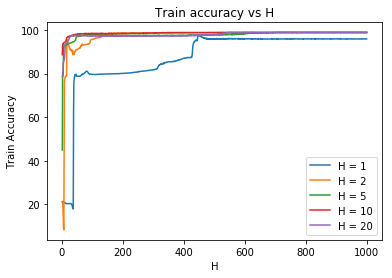

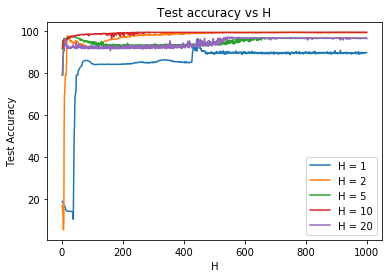

In [15]:
toplot = trainaccuracy
labels = ['H = 1', 'H = 2', 'H = 5', 'H = 10', 'H = 20']
graph(toplot, labels, 'Train accuracy vs H', 'H', 'Train Accuracy')

toplot = testaccuracy
labels = ['H = 1', 'H = 2', 'H = 5', 'H = 10', 'H = 20']
graph(toplot, labels, 'Test accuracy vs H', 'H', 'Test Accuracy')

## Observations

H = 10, H = 2 seems to perform better in terms of Test set performance.

In terms of Train set performance all perform equally well , except for H = 1

## 1c with MSE

In [17]:
log_interval = 100
train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle = True)

model = Net(H = 5)
optim = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0)
criterion = torch.nn.MSELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_sgd = []
testacc_sgd = []

epoch = 0
while epoch != 1000 :

    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_sgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_sgd += [test_acc]
    
    basetrainerror += [base_trainerror]
    basetesterror += [base_testerror]
    
    no_epoch += [epoch]


print ('Train accuracy is {} % \nTest Accuracy is {} %\n'.format(train_acc, test_acc )) 


Train set 1: Average loss: 0.3192, Training Accuracy : 5904/8143 (73%)


Test set 1: Average loss: 0.2850, Test Accuracy : 7703/9752 (79%)


Train set 2: Average loss: 0.2875, Training Accuracy : 6414/8143 (79%)


Test set 2: Average loss: 0.2547, Test Accuracy : 7703/9752 (79%)


Train set 3: Average loss: 0.2703, Training Accuracy : 6414/8143 (79%)


Test set 3: Average loss: 0.2364, Test Accuracy : 7703/9752 (79%)


Train set 4: Average loss: 0.2573, Training Accuracy : 6414/8143 (79%)


Test set 4: Average loss: 0.2250, Test Accuracy : 7703/9752 (79%)


Train set 5: Average loss: 0.2475, Training Accuracy : 6414/8143 (79%)


Test set 5: Average loss: 0.2177, Test Accuracy : 7703/9752 (79%)


Train set 6: Average loss: 0.2400, Training Accuracy : 6414/8143 (79%)


Test set 6: Average loss: 0.2129, Test Accuracy : 7703/9752 (79%)


Train set 7: Average loss: 0.2344, Training Accuracy : 6414/8143 (79%)


Test set 7: Average loss: 0.2095, Test Accuracy : 7703/9752 (79%)


Train set 8:


Test set 59: Average loss: 0.0425, Test Accuracy : 9224/9752 (95%)


Train set 60: Average loss: 0.0848, Training Accuracy : 7460/8143 (92%)


Test set 60: Average loss: 0.0417, Test Accuracy : 9234/9752 (95%)


Train set 61: Average loss: 0.0846, Training Accuracy : 7462/8143 (92%)


Test set 61: Average loss: 0.0424, Test Accuracy : 9226/9752 (95%)


Train set 62: Average loss: 0.0843, Training Accuracy : 7464/8143 (92%)


Test set 62: Average loss: 0.0417, Test Accuracy : 9241/9752 (95%)


Train set 63: Average loss: 0.0841, Training Accuracy : 7472/8143 (92%)


Test set 63: Average loss: 0.0421, Test Accuracy : 9230/9752 (95%)


Train set 64: Average loss: 0.0839, Training Accuracy : 7474/8143 (92%)


Test set 64: Average loss: 0.0426, Test Accuracy : 9239/9752 (95%)


Train set 65: Average loss: 0.0837, Training Accuracy : 7469/8143 (92%)


Test set 65: Average loss: 0.0417, Test Accuracy : 9238/9752 (95%)


Train set 66: Average loss: 0.0835, Training Accuracy : 7474/8143 (92%)



Test set 117: Average loss: 0.0406, Test Accuracy : 9267/9752 (95%)


Train set 118: Average loss: 0.0789, Training Accuracy : 7494/8143 (92%)


Test set 118: Average loss: 0.0406, Test Accuracy : 9266/9752 (95%)


Train set 119: Average loss: 0.0789, Training Accuracy : 7494/8143 (92%)


Test set 119: Average loss: 0.0405, Test Accuracy : 9267/9752 (95%)


Train set 120: Average loss: 0.0789, Training Accuracy : 7495/8143 (92%)


Test set 120: Average loss: 0.0403, Test Accuracy : 9272/9752 (95%)


Train set 121: Average loss: 0.0788, Training Accuracy : 7495/8143 (92%)


Test set 121: Average loss: 0.0404, Test Accuracy : 9268/9752 (95%)


Train set 122: Average loss: 0.0788, Training Accuracy : 7492/8143 (92%)


Test set 122: Average loss: 0.0404, Test Accuracy : 9268/9752 (95%)


Train set 123: Average loss: 0.0787, Training Accuracy : 7494/8143 (92%)


Test set 123: Average loss: 0.0404, Test Accuracy : 9269/9752 (95%)


Train set 124: Average loss: 0.0787, Training Accuracy : 74


Train set 176: Average loss: 0.0763, Training Accuracy : 7497/8143 (92%)


Test set 176: Average loss: 0.0402, Test Accuracy : 9279/9752 (95%)


Train set 177: Average loss: 0.0762, Training Accuracy : 7498/8143 (92%)


Test set 177: Average loss: 0.0402, Test Accuracy : 9279/9752 (95%)


Train set 178: Average loss: 0.0761, Training Accuracy : 7496/8143 (92%)


Test set 178: Average loss: 0.0402, Test Accuracy : 9276/9752 (95%)


Train set 179: Average loss: 0.0760, Training Accuracy : 7495/8143 (92%)


Test set 179: Average loss: 0.0400, Test Accuracy : 9276/9752 (95%)


Train set 180: Average loss: 0.0759, Training Accuracy : 7498/8143 (92%)


Test set 180: Average loss: 0.0403, Test Accuracy : 9289/9752 (95%)


Train set 181: Average loss: 0.0758, Training Accuracy : 7496/8143 (92%)


Test set 181: Average loss: 0.0402, Test Accuracy : 9278/9752 (95%)


Train set 182: Average loss: 0.0757, Training Accuracy : 7495/8143 (92%)


Test set 182: Average loss: 0.0401, Test Accuracy : 92


Train set 233: Average loss: 0.0725, Training Accuracy : 7496/8143 (92%)


Test set 233: Average loss: 0.0415, Test Accuracy : 9311/9752 (95%)


Train set 234: Average loss: 0.0725, Training Accuracy : 7495/8143 (92%)


Test set 234: Average loss: 0.0415, Test Accuracy : 9312/9752 (95%)


Train set 235: Average loss: 0.0724, Training Accuracy : 7492/8143 (92%)


Test set 235: Average loss: 0.0411, Test Accuracy : 9320/9752 (96%)


Train set 236: Average loss: 0.0724, Training Accuracy : 7497/8143 (92%)


Test set 236: Average loss: 0.0413, Test Accuracy : 9318/9752 (96%)


Train set 237: Average loss: 0.0724, Training Accuracy : 7497/8143 (92%)


Test set 237: Average loss: 0.0414, Test Accuracy : 9312/9752 (95%)


Train set 238: Average loss: 0.0723, Training Accuracy : 7496/8143 (92%)


Test set 238: Average loss: 0.0415, Test Accuracy : 9308/9752 (95%)


Train set 239: Average loss: 0.0723, Training Accuracy : 7494/8143 (92%)


Test set 239: Average loss: 0.0415, Test Accuracy : 93


Train set 291: Average loss: 0.0701, Training Accuracy : 7552/8143 (93%)


Test set 291: Average loss: 0.0492, Test Accuracy : 9274/9752 (95%)


Train set 292: Average loss: 0.0697, Training Accuracy : 7579/8143 (93%)


Test set 292: Average loss: 0.0498, Test Accuracy : 9273/9752 (95%)


Train set 293: Average loss: 0.0696, Training Accuracy : 7580/8143 (93%)


Test set 293: Average loss: 0.0495, Test Accuracy : 9274/9752 (95%)


Train set 294: Average loss: 0.0696, Training Accuracy : 7585/8143 (93%)


Test set 294: Average loss: 0.0496, Test Accuracy : 9274/9752 (95%)


Train set 295: Average loss: 0.0695, Training Accuracy : 7584/8143 (93%)


Test set 295: Average loss: 0.0494, Test Accuracy : 9274/9752 (95%)


Train set 296: Average loss: 0.0695, Training Accuracy : 7585/8143 (93%)


Test set 296: Average loss: 0.0493, Test Accuracy : 9274/9752 (95%)


Train set 297: Average loss: 0.0694, Training Accuracy : 7587/8143 (93%)


Test set 297: Average loss: 0.0496, Test Accuracy : 92


Test set 347: Average loss: 0.0502, Test Accuracy : 9271/9752 (95%)


Train set 348: Average loss: 0.0670, Training Accuracy : 7625/8143 (94%)


Test set 348: Average loss: 0.0501, Test Accuracy : 9271/9752 (95%)


Train set 349: Average loss: 0.0670, Training Accuracy : 7623/8143 (94%)


Test set 349: Average loss: 0.0504, Test Accuracy : 9271/9752 (95%)


Train set 350: Average loss: 0.0669, Training Accuracy : 7623/8143 (94%)


Test set 350: Average loss: 0.0495, Test Accuracy : 9273/9752 (95%)


Train set 351: Average loss: 0.0669, Training Accuracy : 7623/8143 (94%)


Test set 351: Average loss: 0.0499, Test Accuracy : 9271/9752 (95%)


Train set 352: Average loss: 0.0669, Training Accuracy : 7627/8143 (94%)


Test set 352: Average loss: 0.0496, Test Accuracy : 9273/9752 (95%)


Train set 353: Average loss: 0.0668, Training Accuracy : 7627/8143 (94%)


Test set 353: Average loss: 0.0491, Test Accuracy : 9275/9752 (95%)


Train set 354: Average loss: 0.0668, Training Accuracy : 76


Train set 406: Average loss: 0.0651, Training Accuracy : 7630/8143 (94%)


Test set 406: Average loss: 0.0485, Test Accuracy : 9277/9752 (95%)


Train set 407: Average loss: 0.0651, Training Accuracy : 7629/8143 (94%)


Test set 407: Average loss: 0.0487, Test Accuracy : 9277/9752 (95%)


Train set 408: Average loss: 0.0651, Training Accuracy : 7628/8143 (94%)


Test set 408: Average loss: 0.0484, Test Accuracy : 9277/9752 (95%)


Train set 409: Average loss: 0.0650, Training Accuracy : 7629/8143 (94%)


Test set 409: Average loss: 0.0488, Test Accuracy : 9276/9752 (95%)


Train set 410: Average loss: 0.0650, Training Accuracy : 7630/8143 (94%)


Test set 410: Average loss: 0.0487, Test Accuracy : 9277/9752 (95%)


Train set 411: Average loss: 0.0650, Training Accuracy : 7628/8143 (94%)


Test set 411: Average loss: 0.0487, Test Accuracy : 9277/9752 (95%)


Train set 412: Average loss: 0.0649, Training Accuracy : 7630/8143 (94%)


Test set 412: Average loss: 0.0489, Test Accuracy : 92


Train set 463: Average loss: 0.0633, Training Accuracy : 7636/8143 (94%)


Test set 463: Average loss: 0.0467, Test Accuracy : 9285/9752 (95%)


Train set 464: Average loss: 0.0632, Training Accuracy : 7636/8143 (94%)


Test set 464: Average loss: 0.0460, Test Accuracy : 9291/9752 (95%)


Train set 465: Average loss: 0.0632, Training Accuracy : 7637/8143 (94%)


Test set 465: Average loss: 0.0465, Test Accuracy : 9287/9752 (95%)


Train set 466: Average loss: 0.0632, Training Accuracy : 7637/8143 (94%)


Test set 466: Average loss: 0.0469, Test Accuracy : 9284/9752 (95%)


Train set 467: Average loss: 0.0631, Training Accuracy : 7638/8143 (94%)


Test set 467: Average loss: 0.0464, Test Accuracy : 9287/9752 (95%)


Train set 468: Average loss: 0.0631, Training Accuracy : 7636/8143 (94%)


Test set 468: Average loss: 0.0473, Test Accuracy : 9280/9752 (95%)


Train set 469: Average loss: 0.0631, Training Accuracy : 7636/8143 (94%)


Test set 469: Average loss: 0.0461, Test Accuracy : 92


Test set 519: Average loss: 0.0452, Test Accuracy : 9292/9752 (95%)


Train set 520: Average loss: 0.0611, Training Accuracy : 7653/8143 (94%)


Test set 520: Average loss: 0.0441, Test Accuracy : 9302/9752 (95%)


Train set 521: Average loss: 0.0610, Training Accuracy : 7658/8143 (94%)


Test set 521: Average loss: 0.0440, Test Accuracy : 9302/9752 (95%)


Train set 522: Average loss: 0.0609, Training Accuracy : 7657/8143 (94%)


Test set 522: Average loss: 0.0444, Test Accuracy : 9299/9752 (95%)


Train set 523: Average loss: 0.0609, Training Accuracy : 7657/8143 (94%)


Test set 523: Average loss: 0.0435, Test Accuracy : 9305/9752 (95%)


Train set 524: Average loss: 0.0608, Training Accuracy : 7661/8143 (94%)


Test set 524: Average loss: 0.0446, Test Accuracy : 9297/9752 (95%)


Train set 525: Average loss: 0.0608, Training Accuracy : 7662/8143 (94%)


Test set 525: Average loss: 0.0443, Test Accuracy : 9299/9752 (95%)


Train set 526: Average loss: 0.0607, Training Accuracy : 76


Train set 578: Average loss: 0.0559, Training Accuracy : 7710/8143 (95%)


Test set 578: Average loss: 0.0357, Test Accuracy : 9358/9752 (96%)


Train set 579: Average loss: 0.0556, Training Accuracy : 7712/8143 (95%)


Test set 579: Average loss: 0.0336, Test Accuracy : 9375/9752 (96%)


Train set 580: Average loss: 0.0554, Training Accuracy : 7714/8143 (95%)


Test set 580: Average loss: 0.0334, Test Accuracy : 9377/9752 (96%)


Train set 581: Average loss: 0.0552, Training Accuracy : 7716/8143 (95%)


Test set 581: Average loss: 0.0347, Test Accuracy : 9365/9752 (96%)


Train set 582: Average loss: 0.0549, Training Accuracy : 7719/8143 (95%)


Test set 582: Average loss: 0.0336, Test Accuracy : 9375/9752 (96%)


Train set 583: Average loss: 0.0546, Training Accuracy : 7725/8143 (95%)


Test set 583: Average loss: 0.0335, Test Accuracy : 9374/9752 (96%)


Train set 584: Average loss: 0.0542, Training Accuracy : 7728/8143 (95%)


Test set 584: Average loss: 0.0331, Test Accuracy : 93


Test set 634: Average loss: 0.0408, Test Accuracy : 9328/9752 (96%)


Train set 635: Average loss: 0.0375, Training Accuracy : 7825/8143 (96%)


Test set 635: Average loss: 0.0422, Test Accuracy : 9330/9752 (96%)


Train set 636: Average loss: 0.0375, Training Accuracy : 7826/8143 (96%)


Test set 636: Average loss: 0.0415, Test Accuracy : 9323/9752 (96%)


Train set 637: Average loss: 0.0374, Training Accuracy : 7828/8143 (96%)


Test set 637: Average loss: 0.0423, Test Accuracy : 9329/9752 (96%)


Train set 638: Average loss: 0.0372, Training Accuracy : 7830/8143 (96%)


Test set 638: Average loss: 0.0456, Test Accuracy : 9250/9752 (95%)


Train set 639: Average loss: 0.0372, Training Accuracy : 7826/8143 (96%)


Test set 639: Average loss: 0.0438, Test Accuracy : 9268/9752 (95%)


Train set 640: Average loss: 0.0371, Training Accuracy : 7822/8143 (96%)


Test set 640: Average loss: 0.0452, Test Accuracy : 9250/9752 (95%)


Train set 641: Average loss: 0.0370, Training Accuracy : 78


Train set 692: Average loss: 0.0341, Training Accuracy : 7845/8143 (96%)


Test set 692: Average loss: 0.0425, Test Accuracy : 9273/9752 (95%)


Train set 693: Average loss: 0.0340, Training Accuracy : 7846/8143 (96%)


Test set 693: Average loss: 0.0426, Test Accuracy : 9269/9752 (95%)


Train set 694: Average loss: 0.0340, Training Accuracy : 7849/8143 (96%)


Test set 694: Average loss: 0.0434, Test Accuracy : 9233/9752 (95%)


Train set 695: Average loss: 0.0339, Training Accuracy : 7850/8143 (96%)


Test set 695: Average loss: 0.0426, Test Accuracy : 9262/9752 (95%)


Train set 696: Average loss: 0.0339, Training Accuracy : 7848/8143 (96%)


Test set 696: Average loss: 0.0425, Test Accuracy : 9262/9752 (95%)


Train set 697: Average loss: 0.0338, Training Accuracy : 7847/8143 (96%)


Test set 697: Average loss: 0.0430, Test Accuracy : 9239/9752 (95%)


Train set 698: Average loss: 0.0337, Training Accuracy : 7845/8143 (96%)


Test set 698: Average loss: 0.0434, Test Accuracy : 92


Train set 749: Average loss: 0.0320, Training Accuracy : 7867/8143 (97%)


Test set 749: Average loss: 0.0421, Test Accuracy : 9239/9752 (95%)


Train set 750: Average loss: 0.0319, Training Accuracy : 7867/8143 (97%)


Test set 750: Average loss: 0.0437, Test Accuracy : 9175/9752 (94%)


Train set 751: Average loss: 0.0319, Training Accuracy : 7873/8143 (97%)


Test set 751: Average loss: 0.0417, Test Accuracy : 9252/9752 (95%)


Train set 752: Average loss: 0.0319, Training Accuracy : 7863/8143 (97%)


Test set 752: Average loss: 0.0417, Test Accuracy : 9252/9752 (95%)


Train set 753: Average loss: 0.0319, Training Accuracy : 7868/8143 (97%)


Test set 753: Average loss: 0.0426, Test Accuracy : 9224/9752 (95%)


Train set 754: Average loss: 0.0318, Training Accuracy : 7870/8143 (97%)


Test set 754: Average loss: 0.0432, Test Accuracy : 9204/9752 (94%)


Train set 755: Average loss: 0.0318, Training Accuracy : 7870/8143 (97%)


Test set 755: Average loss: 0.0426, Test Accuracy : 92


Test set 805: Average loss: 0.0407, Test Accuracy : 9272/9752 (95%)


Train set 806: Average loss: 0.0307, Training Accuracy : 7885/8143 (97%)


Test set 806: Average loss: 0.0416, Test Accuracy : 9228/9752 (95%)


Train set 807: Average loss: 0.0306, Training Accuracy : 7886/8143 (97%)


Test set 807: Average loss: 0.0417, Test Accuracy : 9229/9752 (95%)


Train set 808: Average loss: 0.0306, Training Accuracy : 7882/8143 (97%)


Test set 808: Average loss: 0.0413, Test Accuracy : 9235/9752 (95%)


Train set 809: Average loss: 0.0306, Training Accuracy : 7885/8143 (97%)


Test set 809: Average loss: 0.0424, Test Accuracy : 9191/9752 (94%)


Train set 810: Average loss: 0.0306, Training Accuracy : 7880/8143 (97%)


Test set 810: Average loss: 0.0415, Test Accuracy : 9229/9752 (95%)


Train set 811: Average loss: 0.0305, Training Accuracy : 7885/8143 (97%)


Test set 811: Average loss: 0.0411, Test Accuracy : 9239/9752 (95%)


Train set 812: Average loss: 0.0305, Training Accuracy : 78


Train set 864: Average loss: 0.0296, Training Accuracy : 7898/8143 (97%)


Test set 864: Average loss: 0.0409, Test Accuracy : 9237/9752 (95%)


Train set 865: Average loss: 0.0296, Training Accuracy : 7892/8143 (97%)


Test set 865: Average loss: 0.0416, Test Accuracy : 9199/9752 (94%)


Train set 866: Average loss: 0.0296, Training Accuracy : 7895/8143 (97%)


Test set 866: Average loss: 0.0410, Test Accuracy : 9236/9752 (95%)


Train set 867: Average loss: 0.0297, Training Accuracy : 7894/8143 (97%)


Test set 867: Average loss: 0.0413, Test Accuracy : 9210/9752 (94%)


Train set 868: Average loss: 0.0296, Training Accuracy : 7894/8143 (97%)


Test set 868: Average loss: 0.0411, Test Accuracy : 9231/9752 (95%)


Train set 869: Average loss: 0.0296, Training Accuracy : 7894/8143 (97%)


Test set 869: Average loss: 0.0404, Test Accuracy : 9240/9752 (95%)


Train set 870: Average loss: 0.0296, Training Accuracy : 7894/8143 (97%)


Test set 870: Average loss: 0.0416, Test Accuracy : 91


Train set 921: Average loss: 0.0289, Training Accuracy : 7904/8143 (97%)


Test set 921: Average loss: 0.0408, Test Accuracy : 9203/9752 (94%)


Train set 922: Average loss: 0.0288, Training Accuracy : 7904/8143 (97%)


Test set 922: Average loss: 0.0407, Test Accuracy : 9208/9752 (94%)


Train set 923: Average loss: 0.0289, Training Accuracy : 7900/8143 (97%)


Test set 923: Average loss: 0.0402, Test Accuracy : 9239/9752 (95%)


Train set 924: Average loss: 0.0288, Training Accuracy : 7903/8143 (97%)


Test set 924: Average loss: 0.0402, Test Accuracy : 9244/9752 (95%)


Train set 925: Average loss: 0.0289, Training Accuracy : 7899/8143 (97%)


Test set 925: Average loss: 0.0404, Test Accuracy : 9228/9752 (95%)


Train set 926: Average loss: 0.0288, Training Accuracy : 7896/8143 (97%)


Test set 926: Average loss: 0.0409, Test Accuracy : 9197/9752 (94%)


Train set 927: Average loss: 0.0288, Training Accuracy : 7902/8143 (97%)


Test set 927: Average loss: 0.0399, Test Accuracy : 92


Train set 978: Average loss: 0.0283, Training Accuracy : 7906/8143 (97%)


Test set 978: Average loss: 0.0391, Test Accuracy : 9254/9752 (95%)


Train set 979: Average loss: 0.0283, Training Accuracy : 7908/8143 (97%)


Test set 979: Average loss: 0.0394, Test Accuracy : 9249/9752 (95%)


Train set 980: Average loss: 0.0282, Training Accuracy : 7913/8143 (97%)


Test set 980: Average loss: 0.0382, Test Accuracy : 9284/9752 (95%)


Train set 981: Average loss: 0.0283, Training Accuracy : 7897/8143 (97%)


Test set 981: Average loss: 0.0400, Test Accuracy : 9210/9752 (94%)


Train set 982: Average loss: 0.0283, Training Accuracy : 7908/8143 (97%)


Test set 982: Average loss: 0.0386, Test Accuracy : 9259/9752 (95%)


Train set 983: Average loss: 0.0283, Training Accuracy : 7910/8143 (97%)


Test set 983: Average loss: 0.0386, Test Accuracy : 9259/9752 (95%)


Train set 984: Average loss: 0.0282, Training Accuracy : 7914/8143 (97%)


Test set 984: Average loss: 0.0385, Test Accuracy : 92

In [18]:
print base_trainerror
print base_testerror

0.494043976068
0.499794900417


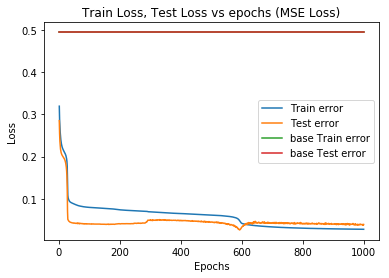

In [19]:
toplot = [trainerror, testerror, basetrainerror, basetrainerror]
labels = ['Train error', 'Test error', 'base Train error', 'base Test error']
graph(toplot, labels, 'Train Loss, Test Loss vs epochs (MSE Loss)', 'Epochs', 'Loss')

## Report 

Learning rate used : 0.0001

Train Accuracy : 97.1%

Test Accuracy : 94.5%

The Accuracies when using MSE Loss is almost similar to when we use BCE Loss

## 1d with MSE

In [19]:
train_loader = data_utils.DataLoader(train_util, batch_size = 8143, shuffle=True)

model = Net(H = 5) # batch gd

optim = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0)
criterion = torch.nn.MSELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_bgd = []
testacc_bgd = []

epoch = 0
while epoch != 1000:

    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_bgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_bgd += [test_acc]

    no_epoch += [epoch]





Train set 1: Average loss: 0.5085, Training Accuracy : 645/8143 (8%)


Test set 1: Average loss: 0.5709, Test Accuracy : 768/9752 (8%)


Train set 2: Average loss: 0.4816, Training Accuracy : 674/8143 (8%)


Test set 2: Average loss: 0.5360, Test Accuracy : 891/9752 (9%)


Train set 3: Average loss: 0.4530, Training Accuracy : 709/8143 (9%)


Test set 3: Average loss: 0.4978, Test Accuracy : 1051/9752 (11%)


Train set 4: Average loss: 0.4235, Training Accuracy : 815/8143 (10%)


Test set 4: Average loss: 0.4574, Test Accuracy : 1233/9752 (13%)


Train set 5: Average loss: 0.3945, Training Accuracy : 954/8143 (12%)


Test set 5: Average loss: 0.4164, Test Accuracy : 1589/9752 (16%)


Train set 6: Average loss: 0.3670, Training Accuracy : 1101/8143 (14%)


Test set 6: Average loss: 0.3790, Test Accuracy : 2852/9752 (29%)


Train set 7: Average loss: 0.3439, Training Accuracy : 2307/8143 (28%)


Test set 7: Average loss: 0.3528, Test Accuracy : 3917/9752 (40%)


Train set 8: Average los


Test set 58: Average loss: 0.2969, Test Accuracy : 7703/9752 (79%)


Train set 59: Average loss: 0.3043, Training Accuracy : 6414/8143 (79%)


Test set 59: Average loss: 0.2963, Test Accuracy : 7703/9752 (79%)


Train set 60: Average loss: 0.3040, Training Accuracy : 6414/8143 (79%)


Test set 60: Average loss: 0.2958, Test Accuracy : 7703/9752 (79%)


Train set 61: Average loss: 0.3037, Training Accuracy : 6414/8143 (79%)


Test set 61: Average loss: 0.2953, Test Accuracy : 7703/9752 (79%)


Train set 62: Average loss: 0.3034, Training Accuracy : 6414/8143 (79%)


Test set 62: Average loss: 0.2947, Test Accuracy : 7703/9752 (79%)


Train set 63: Average loss: 0.3031, Training Accuracy : 6414/8143 (79%)


Test set 63: Average loss: 0.2942, Test Accuracy : 7703/9752 (79%)


Train set 64: Average loss: 0.3028, Training Accuracy : 6414/8143 (79%)


Test set 64: Average loss: 0.2937, Test Accuracy : 7703/9752 (79%)


Train set 65: Average loss: 0.3025, Training Accuracy : 6414/8143 (79%)



Train set 117: Average loss: 0.2886, Training Accuracy : 6414/8143 (79%)


Test set 117: Average loss: 0.2700, Test Accuracy : 7703/9752 (79%)


Train set 118: Average loss: 0.2884, Training Accuracy : 6414/8143 (79%)


Test set 118: Average loss: 0.2696, Test Accuracy : 7703/9752 (79%)


Train set 119: Average loss: 0.2882, Training Accuracy : 6414/8143 (79%)


Test set 119: Average loss: 0.2693, Test Accuracy : 7703/9752 (79%)


Train set 120: Average loss: 0.2879, Training Accuracy : 6414/8143 (79%)


Test set 120: Average loss: 0.2689, Test Accuracy : 7703/9752 (79%)


Train set 121: Average loss: 0.2877, Training Accuracy : 6414/8143 (79%)


Test set 121: Average loss: 0.2685, Test Accuracy : 7703/9752 (79%)


Train set 122: Average loss: 0.2874, Training Accuracy : 6414/8143 (79%)


Test set 122: Average loss: 0.2682, Test Accuracy : 7703/9752 (79%)


Train set 123: Average loss: 0.2872, Training Accuracy : 6414/8143 (79%)


Test set 123: Average loss: 0.2678, Test Accuracy : 77


Train set 174: Average loss: 0.2760, Training Accuracy : 6414/8143 (79%)


Test set 174: Average loss: 0.2518, Test Accuracy : 7703/9752 (79%)


Train set 175: Average loss: 0.2758, Training Accuracy : 6414/8143 (79%)


Test set 175: Average loss: 0.2516, Test Accuracy : 7703/9752 (79%)


Train set 176: Average loss: 0.2756, Training Accuracy : 6414/8143 (79%)


Test set 176: Average loss: 0.2513, Test Accuracy : 7703/9752 (79%)


Train set 177: Average loss: 0.2754, Training Accuracy : 6414/8143 (79%)


Test set 177: Average loss: 0.2510, Test Accuracy : 7703/9752 (79%)


Train set 178: Average loss: 0.2752, Training Accuracy : 6414/8143 (79%)


Test set 178: Average loss: 0.2508, Test Accuracy : 7703/9752 (79%)


Train set 179: Average loss: 0.2750, Training Accuracy : 6414/8143 (79%)


Test set 179: Average loss: 0.2505, Test Accuracy : 7703/9752 (79%)


Train set 180: Average loss: 0.2748, Training Accuracy : 6414/8143 (79%)


Test set 180: Average loss: 0.2503, Test Accuracy : 77


Test set 230: Average loss: 0.2392, Test Accuracy : 7703/9752 (79%)


Train set 231: Average loss: 0.2655, Training Accuracy : 6414/8143 (79%)


Test set 231: Average loss: 0.2390, Test Accuracy : 7703/9752 (79%)


Train set 232: Average loss: 0.2653, Training Accuracy : 6414/8143 (79%)


Test set 232: Average loss: 0.2388, Test Accuracy : 7703/9752 (79%)


Train set 233: Average loss: 0.2652, Training Accuracy : 6414/8143 (79%)


Test set 233: Average loss: 0.2386, Test Accuracy : 7703/9752 (79%)


Train set 234: Average loss: 0.2650, Training Accuracy : 6414/8143 (79%)


Test set 234: Average loss: 0.2384, Test Accuracy : 7703/9752 (79%)


Train set 235: Average loss: 0.2649, Training Accuracy : 6414/8143 (79%)


Test set 235: Average loss: 0.2383, Test Accuracy : 7703/9752 (79%)


Train set 236: Average loss: 0.2647, Training Accuracy : 6414/8143 (79%)


Test set 236: Average loss: 0.2381, Test Accuracy : 7703/9752 (79%)


Train set 237: Average loss: 0.2645, Training Accuracy : 64


Test set 287: Average loss: 0.2300, Test Accuracy : 7703/9752 (79%)


Train set 288: Average loss: 0.2569, Training Accuracy : 6414/8143 (79%)


Test set 288: Average loss: 0.2299, Test Accuracy : 7703/9752 (79%)


Train set 289: Average loss: 0.2568, Training Accuracy : 6414/8143 (79%)


Test set 289: Average loss: 0.2297, Test Accuracy : 7703/9752 (79%)


Train set 290: Average loss: 0.2567, Training Accuracy : 6414/8143 (79%)


Test set 290: Average loss: 0.2296, Test Accuracy : 7703/9752 (79%)


Train set 291: Average loss: 0.2565, Training Accuracy : 6414/8143 (79%)


Test set 291: Average loss: 0.2295, Test Accuracy : 7703/9752 (79%)


Train set 292: Average loss: 0.2564, Training Accuracy : 6414/8143 (79%)


Test set 292: Average loss: 0.2293, Test Accuracy : 7703/9752 (79%)


Train set 293: Average loss: 0.2563, Training Accuracy : 6414/8143 (79%)


Test set 293: Average loss: 0.2292, Test Accuracy : 7703/9752 (79%)


Train set 294: Average loss: 0.2561, Training Accuracy : 64


Test set 344: Average loss: 0.2233, Test Accuracy : 7703/9752 (79%)


Train set 345: Average loss: 0.2499, Training Accuracy : 6414/8143 (79%)


Test set 345: Average loss: 0.2232, Test Accuracy : 7703/9752 (79%)


Train set 346: Average loss: 0.2498, Training Accuracy : 6414/8143 (79%)


Test set 346: Average loss: 0.2231, Test Accuracy : 7703/9752 (79%)


Train set 347: Average loss: 0.2497, Training Accuracy : 6414/8143 (79%)


Test set 347: Average loss: 0.2230, Test Accuracy : 7703/9752 (79%)


Train set 348: Average loss: 0.2496, Training Accuracy : 6414/8143 (79%)


Test set 348: Average loss: 0.2229, Test Accuracy : 7703/9752 (79%)


Train set 349: Average loss: 0.2495, Training Accuracy : 6414/8143 (79%)


Test set 349: Average loss: 0.2228, Test Accuracy : 7703/9752 (79%)


Train set 350: Average loss: 0.2493, Training Accuracy : 6414/8143 (79%)


Test set 350: Average loss: 0.2227, Test Accuracy : 7703/9752 (79%)


Train set 351: Average loss: 0.2492, Training Accuracy : 64


Test set 402: Average loss: 0.2183, Test Accuracy : 7703/9752 (79%)


Train set 403: Average loss: 0.2440, Training Accuracy : 6414/8143 (79%)


Test set 403: Average loss: 0.2182, Test Accuracy : 7703/9752 (79%)


Train set 404: Average loss: 0.2439, Training Accuracy : 6414/8143 (79%)


Test set 404: Average loss: 0.2182, Test Accuracy : 7703/9752 (79%)


Train set 405: Average loss: 0.2438, Training Accuracy : 6414/8143 (79%)


Test set 405: Average loss: 0.2181, Test Accuracy : 7703/9752 (79%)


Train set 406: Average loss: 0.2438, Training Accuracy : 6414/8143 (79%)


Test set 406: Average loss: 0.2180, Test Accuracy : 7703/9752 (79%)


Train set 407: Average loss: 0.2437, Training Accuracy : 6414/8143 (79%)


Test set 407: Average loss: 0.2179, Test Accuracy : 7703/9752 (79%)


Train set 408: Average loss: 0.2436, Training Accuracy : 6414/8143 (79%)


Test set 408: Average loss: 0.2179, Test Accuracy : 7703/9752 (79%)


Train set 409: Average loss: 0.2435, Training Accuracy : 64


Test set 460: Average loss: 0.2146, Test Accuracy : 7703/9752 (79%)


Train set 461: Average loss: 0.2392, Training Accuracy : 6414/8143 (79%)


Test set 461: Average loss: 0.2145, Test Accuracy : 7703/9752 (79%)


Train set 462: Average loss: 0.2391, Training Accuracy : 6414/8143 (79%)


Test set 462: Average loss: 0.2144, Test Accuracy : 7703/9752 (79%)


Train set 463: Average loss: 0.2390, Training Accuracy : 6414/8143 (79%)


Test set 463: Average loss: 0.2144, Test Accuracy : 7703/9752 (79%)


Train set 464: Average loss: 0.2390, Training Accuracy : 6414/8143 (79%)


Test set 464: Average loss: 0.2143, Test Accuracy : 7703/9752 (79%)


Train set 465: Average loss: 0.2389, Training Accuracy : 6414/8143 (79%)


Test set 465: Average loss: 0.2143, Test Accuracy : 7703/9752 (79%)


Train set 466: Average loss: 0.2388, Training Accuracy : 6414/8143 (79%)


Test set 466: Average loss: 0.2142, Test Accuracy : 7703/9752 (79%)


Train set 467: Average loss: 0.2387, Training Accuracy : 64


Test set 518: Average loss: 0.2117, Test Accuracy : 7703/9752 (79%)


Train set 519: Average loss: 0.2352, Training Accuracy : 6414/8143 (79%)


Test set 519: Average loss: 0.2116, Test Accuracy : 7703/9752 (79%)


Train set 520: Average loss: 0.2351, Training Accuracy : 6414/8143 (79%)


Test set 520: Average loss: 0.2116, Test Accuracy : 7703/9752 (79%)


Train set 521: Average loss: 0.2350, Training Accuracy : 6414/8143 (79%)


Test set 521: Average loss: 0.2116, Test Accuracy : 7703/9752 (79%)


Train set 522: Average loss: 0.2350, Training Accuracy : 6414/8143 (79%)


Test set 522: Average loss: 0.2115, Test Accuracy : 7703/9752 (79%)


Train set 523: Average loss: 0.2349, Training Accuracy : 6414/8143 (79%)


Test set 523: Average loss: 0.2115, Test Accuracy : 7703/9752 (79%)


Train set 524: Average loss: 0.2349, Training Accuracy : 6414/8143 (79%)


Test set 524: Average loss: 0.2114, Test Accuracy : 7703/9752 (79%)


Train set 525: Average loss: 0.2348, Training Accuracy : 64


Test set 576: Average loss: 0.2094, Test Accuracy : 7703/9752 (79%)


Train set 577: Average loss: 0.2318, Training Accuracy : 6414/8143 (79%)


Test set 577: Average loss: 0.2094, Test Accuracy : 7703/9752 (79%)


Train set 578: Average loss: 0.2318, Training Accuracy : 6414/8143 (79%)


Test set 578: Average loss: 0.2094, Test Accuracy : 7703/9752 (79%)


Train set 579: Average loss: 0.2317, Training Accuracy : 6414/8143 (79%)


Test set 579: Average loss: 0.2093, Test Accuracy : 7703/9752 (79%)


Train set 580: Average loss: 0.2317, Training Accuracy : 6414/8143 (79%)


Test set 580: Average loss: 0.2093, Test Accuracy : 7703/9752 (79%)


Train set 581: Average loss: 0.2316, Training Accuracy : 6414/8143 (79%)


Test set 581: Average loss: 0.2093, Test Accuracy : 7703/9752 (79%)


Train set 582: Average loss: 0.2315, Training Accuracy : 6414/8143 (79%)


Test set 582: Average loss: 0.2092, Test Accuracy : 7703/9752 (79%)


Train set 583: Average loss: 0.2315, Training Accuracy : 64


Test set 633: Average loss: 0.2077, Test Accuracy : 7703/9752 (79%)


Train set 634: Average loss: 0.2290, Training Accuracy : 6414/8143 (79%)


Test set 634: Average loss: 0.2077, Test Accuracy : 7703/9752 (79%)


Train set 635: Average loss: 0.2290, Training Accuracy : 6414/8143 (79%)


Test set 635: Average loss: 0.2076, Test Accuracy : 7703/9752 (79%)


Train set 636: Average loss: 0.2289, Training Accuracy : 6414/8143 (79%)


Test set 636: Average loss: 0.2076, Test Accuracy : 7703/9752 (79%)


Train set 637: Average loss: 0.2289, Training Accuracy : 6414/8143 (79%)


Test set 637: Average loss: 0.2076, Test Accuracy : 7703/9752 (79%)


Train set 638: Average loss: 0.2288, Training Accuracy : 6414/8143 (79%)


Test set 638: Average loss: 0.2075, Test Accuracy : 7703/9752 (79%)


Train set 639: Average loss: 0.2288, Training Accuracy : 6414/8143 (79%)


Test set 639: Average loss: 0.2075, Test Accuracy : 7703/9752 (79%)


Train set 640: Average loss: 0.2287, Training Accuracy : 64


Test set 691: Average loss: 0.2062, Test Accuracy : 7703/9752 (79%)


Train set 692: Average loss: 0.2266, Training Accuracy : 6414/8143 (79%)


Test set 692: Average loss: 0.2062, Test Accuracy : 7703/9752 (79%)


Train set 693: Average loss: 0.2265, Training Accuracy : 6414/8143 (79%)


Test set 693: Average loss: 0.2062, Test Accuracy : 7703/9752 (79%)


Train set 694: Average loss: 0.2265, Training Accuracy : 6414/8143 (79%)


Test set 694: Average loss: 0.2061, Test Accuracy : 7703/9752 (79%)


Train set 695: Average loss: 0.2265, Training Accuracy : 6414/8143 (79%)


Test set 695: Average loss: 0.2061, Test Accuracy : 7703/9752 (79%)


Train set 696: Average loss: 0.2264, Training Accuracy : 6414/8143 (79%)


Test set 696: Average loss: 0.2061, Test Accuracy : 7703/9752 (79%)


Train set 697: Average loss: 0.2264, Training Accuracy : 6414/8143 (79%)


Test set 697: Average loss: 0.2061, Test Accuracy : 7703/9752 (79%)


Train set 698: Average loss: 0.2264, Training Accuracy : 64


Test set 748: Average loss: 0.2050, Test Accuracy : 7703/9752 (79%)


Train set 749: Average loss: 0.2245, Training Accuracy : 6414/8143 (79%)


Test set 749: Average loss: 0.2050, Test Accuracy : 7703/9752 (79%)


Train set 750: Average loss: 0.2245, Training Accuracy : 6414/8143 (79%)


Test set 750: Average loss: 0.2050, Test Accuracy : 7703/9752 (79%)


Train set 751: Average loss: 0.2245, Training Accuracy : 6414/8143 (79%)


Test set 751: Average loss: 0.2049, Test Accuracy : 7703/9752 (79%)


Train set 752: Average loss: 0.2244, Training Accuracy : 6414/8143 (79%)


Test set 752: Average loss: 0.2049, Test Accuracy : 7703/9752 (79%)


Train set 753: Average loss: 0.2244, Training Accuracy : 6414/8143 (79%)


Test set 753: Average loss: 0.2049, Test Accuracy : 7703/9752 (79%)


Train set 754: Average loss: 0.2244, Training Accuracy : 6414/8143 (79%)


Test set 754: Average loss: 0.2049, Test Accuracy : 7703/9752 (79%)


Train set 755: Average loss: 0.2243, Training Accuracy : 64


Train set 806: Average loss: 0.2227, Training Accuracy : 6414/8143 (79%)


Test set 806: Average loss: 0.2039, Test Accuracy : 7703/9752 (79%)


Train set 807: Average loss: 0.2227, Training Accuracy : 6414/8143 (79%)


Test set 807: Average loss: 0.2039, Test Accuracy : 7703/9752 (79%)


Train set 808: Average loss: 0.2227, Training Accuracy : 6414/8143 (79%)


Test set 808: Average loss: 0.2039, Test Accuracy : 7703/9752 (79%)


Train set 809: Average loss: 0.2226, Training Accuracy : 6414/8143 (79%)


Test set 809: Average loss: 0.2039, Test Accuracy : 7703/9752 (79%)


Train set 810: Average loss: 0.2226, Training Accuracy : 6414/8143 (79%)


Test set 810: Average loss: 0.2039, Test Accuracy : 7703/9752 (79%)


Train set 811: Average loss: 0.2226, Training Accuracy : 6414/8143 (79%)


Test set 811: Average loss: 0.2039, Test Accuracy : 7703/9752 (79%)


Train set 812: Average loss: 0.2225, Training Accuracy : 6414/8143 (79%)


Test set 812: Average loss: 0.2038, Test Accuracy : 77


Test set 863: Average loss: 0.2030, Test Accuracy : 7703/9752 (79%)


Train set 864: Average loss: 0.2211, Training Accuracy : 6414/8143 (79%)


Test set 864: Average loss: 0.2030, Test Accuracy : 7703/9752 (79%)


Train set 865: Average loss: 0.2211, Training Accuracy : 6414/8143 (79%)


Test set 865: Average loss: 0.2030, Test Accuracy : 7703/9752 (79%)


Train set 866: Average loss: 0.2210, Training Accuracy : 6414/8143 (79%)


Test set 866: Average loss: 0.2030, Test Accuracy : 7703/9752 (79%)


Train set 867: Average loss: 0.2210, Training Accuracy : 6414/8143 (79%)


Test set 867: Average loss: 0.2030, Test Accuracy : 7703/9752 (79%)


Train set 868: Average loss: 0.2210, Training Accuracy : 6414/8143 (79%)


Test set 868: Average loss: 0.2029, Test Accuracy : 7703/9752 (79%)


Train set 869: Average loss: 0.2210, Training Accuracy : 6414/8143 (79%)


Test set 869: Average loss: 0.2029, Test Accuracy : 7703/9752 (79%)


Train set 870: Average loss: 0.2209, Training Accuracy : 64


Test set 921: Average loss: 0.2022, Test Accuracy : 7703/9752 (79%)


Train set 922: Average loss: 0.2196, Training Accuracy : 6414/8143 (79%)


Test set 922: Average loss: 0.2022, Test Accuracy : 7703/9752 (79%)


Train set 923: Average loss: 0.2196, Training Accuracy : 6414/8143 (79%)


Test set 923: Average loss: 0.2021, Test Accuracy : 7703/9752 (79%)


Train set 924: Average loss: 0.2196, Training Accuracy : 6414/8143 (79%)


Test set 924: Average loss: 0.2021, Test Accuracy : 7703/9752 (79%)


Train set 925: Average loss: 0.2196, Training Accuracy : 6414/8143 (79%)


Test set 925: Average loss: 0.2021, Test Accuracy : 7703/9752 (79%)


Train set 926: Average loss: 0.2195, Training Accuracy : 6414/8143 (79%)


Test set 926: Average loss: 0.2021, Test Accuracy : 7703/9752 (79%)


Train set 927: Average loss: 0.2195, Training Accuracy : 6414/8143 (79%)


Test set 927: Average loss: 0.2021, Test Accuracy : 7703/9752 (79%)


Train set 928: Average loss: 0.2195, Training Accuracy : 64


Test set 979: Average loss: 0.2014, Test Accuracy : 7703/9752 (79%)


Train set 980: Average loss: 0.2183, Training Accuracy : 6414/8143 (79%)


Test set 980: Average loss: 0.2014, Test Accuracy : 7703/9752 (79%)


Train set 981: Average loss: 0.2183, Training Accuracy : 6414/8143 (79%)


Test set 981: Average loss: 0.2014, Test Accuracy : 7703/9752 (79%)


Train set 982: Average loss: 0.2183, Training Accuracy : 6414/8143 (79%)


Test set 982: Average loss: 0.2013, Test Accuracy : 7703/9752 (79%)


Train set 983: Average loss: 0.2183, Training Accuracy : 6414/8143 (79%)


Test set 983: Average loss: 0.2013, Test Accuracy : 7703/9752 (79%)


Train set 984: Average loss: 0.2182, Training Accuracy : 6414/8143 (79%)


Test set 984: Average loss: 0.2013, Test Accuracy : 7703/9752 (79%)


Train set 985: Average loss: 0.2182, Training Accuracy : 6414/8143 (79%)


Test set 985: Average loss: 0.2013, Test Accuracy : 7703/9752 (79%)


Train set 986: Average loss: 0.2182, Training Accuracy : 64

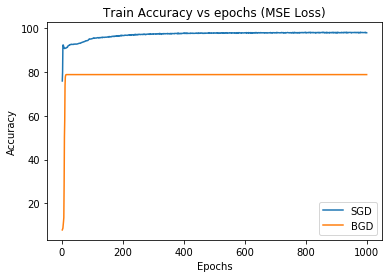

In [20]:
toplot = [trainacc_sgd, trainacc_bgd]
labels = ['SGD', 'BGD']
graph(toplot, labels, 'Train Accuracy vs epochs (MSE Loss)', 'Epochs', 'Accuracy')

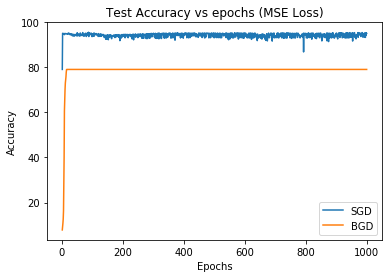

In [21]:
toplot = [testacc_sgd, testacc_bgd]
labels = ['SGD', 'BGD']
graph(toplot, labels, 'Test Accuracy vs epochs (MSE Loss)', 'Epochs', 'Accuracy')

## Report

BGD with BCE loss performs better than with SGD Loss in terms of test accuracy

Here too SGD outperforms BGD

## Observations

Similar observations as that of BCE Loss can be made here too

## 1e with MSE

In [28]:
hidden = [1, 2, 5, 10, 20]

trainaccuracy = []
testaccuracy = []


for H in hidden:
    
    train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle=True)

    model = Net(H) 

    optim = torch.optim.Adam(model.parameters(), lr = 0.0001)
    criterion = torch.nn.MSELoss(size_average = True)

    base_trainerror = baseline(y_train)
    base_testerror = baseline(y_test)
    basetesterror = []
    basetrainerror = []
    trainerror = []
    testerror = []
    no_epoch = []
    trainacc = []
    testacc = []

    epoch = 0

    while epoch != 1000:

        epoch = epoch + 1

        train_error, train_acc = train(epoch) 
        trainerror += [train_error]
        trainacc += [train_acc]

        test_error, test_acc = test(epoch)
        testerror += [test_error]
        testacc += [test_acc]


        no_epoch += [epoch]

    trainaccuracy += [trainacc]
    testaccuracy += [testacc]
    

    




Train set 1: Average loss: 0.7812, Training Accuracy : 1733/8143 (21%)


Test set 1: Average loss: 0.8003, Test Accuracy : 1844/9752 (19%)


Train set 2: Average loss: 0.7787, Training Accuracy : 1733/8143 (21%)


Test set 2: Average loss: 0.8036, Test Accuracy : 1827/9752 (19%)


Train set 3: Average loss: 0.7750, Training Accuracy : 1734/8143 (21%)


Test set 3: Average loss: 0.8065, Test Accuracy : 1788/9752 (18%)


Train set 4: Average loss: 0.7699, Training Accuracy : 1735/8143 (21%)


Test set 4: Average loss: 0.8087, Test Accuracy : 1742/9752 (18%)


Train set 5: Average loss: 0.7628, Training Accuracy : 1728/8143 (21%)


Test set 5: Average loss: 0.8094, Test Accuracy : 1702/9752 (17%)


Train set 6: Average loss: 0.7524, Training Accuracy : 1713/8143 (21%)


Test set 6: Average loss: 0.8070, Test Accuracy : 1662/9752 (17%)


Train set 7: Average loss: 0.7359, Training Accuracy : 1681/8143 (21%)


Test set 7: Average loss: 0.7990, Test Accuracy : 1629/9752 (17%)


Train set 8:


Test set 59: Average loss: 0.1325, Test Accuracy : 9220/9752 (95%)


Train set 60: Average loss: 0.1809, Training Accuracy : 7345/8143 (90%)


Test set 60: Average loss: 0.1284, Test Accuracy : 9227/9752 (95%)


Train set 61: Average loss: 0.1778, Training Accuracy : 7342/8143 (90%)


Test set 61: Average loss: 0.1242, Test Accuracy : 9226/9752 (95%)


Train set 62: Average loss: 0.1746, Training Accuracy : 7342/8143 (90%)


Test set 62: Average loss: 0.1201, Test Accuracy : 9227/9752 (95%)


Train set 63: Average loss: 0.1713, Training Accuracy : 7339/8143 (90%)


Test set 63: Average loss: 0.1161, Test Accuracy : 9226/9752 (95%)


Train set 64: Average loss: 0.1681, Training Accuracy : 7340/8143 (90%)


Test set 64: Average loss: 0.1121, Test Accuracy : 9228/9752 (95%)


Train set 65: Average loss: 0.1649, Training Accuracy : 7338/8143 (90%)


Test set 65: Average loss: 0.1082, Test Accuracy : 9226/9752 (95%)


Train set 66: Average loss: 0.1617, Training Accuracy : 7334/8143 (90%)



Train set 118: Average loss: 0.0850, Training Accuracy : 7507/8143 (92%)


Test set 118: Average loss: 0.0489, Test Accuracy : 9275/9752 (95%)


Train set 119: Average loss: 0.0845, Training Accuracy : 7506/8143 (92%)


Test set 119: Average loss: 0.0486, Test Accuracy : 9275/9752 (95%)


Train set 120: Average loss: 0.0841, Training Accuracy : 7508/8143 (92%)


Test set 120: Average loss: 0.0483, Test Accuracy : 9276/9752 (95%)


Train set 121: Average loss: 0.0836, Training Accuracy : 7509/8143 (92%)


Test set 121: Average loss: 0.0480, Test Accuracy : 9275/9752 (95%)


Train set 122: Average loss: 0.0832, Training Accuracy : 7508/8143 (92%)


Test set 122: Average loss: 0.0478, Test Accuracy : 9277/9752 (95%)


Train set 123: Average loss: 0.0829, Training Accuracy : 7509/8143 (92%)


Test set 123: Average loss: 0.0475, Test Accuracy : 9277/9752 (95%)


Train set 124: Average loss: 0.0825, Training Accuracy : 7511/8143 (92%)


Test set 124: Average loss: 0.0473, Test Accuracy : 92


Train set 175: Average loss: 0.0752, Training Accuracy : 7525/8143 (92%)


Test set 175: Average loss: 0.0426, Test Accuracy : 9298/9752 (95%)


Train set 176: Average loss: 0.0751, Training Accuracy : 7525/8143 (92%)


Test set 176: Average loss: 0.0426, Test Accuracy : 9296/9752 (95%)


Train set 177: Average loss: 0.0751, Training Accuracy : 7525/8143 (92%)


Test set 177: Average loss: 0.0426, Test Accuracy : 9298/9752 (95%)


Train set 178: Average loss: 0.0750, Training Accuracy : 7525/8143 (92%)


Test set 178: Average loss: 0.0426, Test Accuracy : 9296/9752 (95%)


Train set 179: Average loss: 0.0750, Training Accuracy : 7524/8143 (92%)


Test set 179: Average loss: 0.0425, Test Accuracy : 9298/9752 (95%)


Train set 180: Average loss: 0.0749, Training Accuracy : 7526/8143 (92%)


Test set 180: Average loss: 0.0425, Test Accuracy : 9300/9752 (95%)


Train set 181: Average loss: 0.0749, Training Accuracy : 7525/8143 (92%)


Test set 181: Average loss: 0.0424, Test Accuracy : 93


Train set 233: Average loss: 0.0715, Training Accuracy : 7521/8143 (92%)


Test set 233: Average loss: 0.0425, Test Accuracy : 9328/9752 (96%)


Train set 234: Average loss: 0.0714, Training Accuracy : 7521/8143 (92%)


Test set 234: Average loss: 0.0427, Test Accuracy : 9328/9752 (96%)


Train set 235: Average loss: 0.0713, Training Accuracy : 7520/8143 (92%)


Test set 235: Average loss: 0.0427, Test Accuracy : 9328/9752 (96%)


Train set 236: Average loss: 0.0712, Training Accuracy : 7522/8143 (92%)


Test set 236: Average loss: 0.0424, Test Accuracy : 9329/9752 (96%)


Train set 237: Average loss: 0.0711, Training Accuracy : 7521/8143 (92%)


Test set 237: Average loss: 0.0424, Test Accuracy : 9329/9752 (96%)


Train set 238: Average loss: 0.0711, Training Accuracy : 7522/8143 (92%)


Test set 238: Average loss: 0.0423, Test Accuracy : 9329/9752 (96%)


Train set 239: Average loss: 0.0710, Training Accuracy : 7524/8143 (92%)


Test set 239: Average loss: 0.0424, Test Accuracy : 93


Train set 290: Average loss: 0.0606, Training Accuracy : 7655/8143 (94%)


Test set 290: Average loss: 0.0472, Test Accuracy : 9298/9752 (95%)


Train set 291: Average loss: 0.0606, Training Accuracy : 7656/8143 (94%)


Test set 291: Average loss: 0.0473, Test Accuracy : 9298/9752 (95%)


Train set 292: Average loss: 0.0606, Training Accuracy : 7656/8143 (94%)


Test set 292: Average loss: 0.0473, Test Accuracy : 9298/9752 (95%)


Train set 293: Average loss: 0.0606, Training Accuracy : 7656/8143 (94%)


Test set 293: Average loss: 0.0472, Test Accuracy : 9299/9752 (95%)


Train set 294: Average loss: 0.0605, Training Accuracy : 7656/8143 (94%)


Test set 294: Average loss: 0.0471, Test Accuracy : 9300/9752 (95%)


Train set 295: Average loss: 0.0605, Training Accuracy : 7656/8143 (94%)


Test set 295: Average loss: 0.0472, Test Accuracy : 9298/9752 (95%)


Train set 296: Average loss: 0.0605, Training Accuracy : 7656/8143 (94%)


Test set 296: Average loss: 0.0472, Test Accuracy : 92


Train set 347: Average loss: 0.0587, Training Accuracy : 7665/8143 (94%)


Test set 347: Average loss: 0.0455, Test Accuracy : 9315/9752 (96%)


Train set 348: Average loss: 0.0585, Training Accuracy : 7666/8143 (94%)


Test set 348: Average loss: 0.0453, Test Accuracy : 9317/9752 (96%)


Train set 349: Average loss: 0.0585, Training Accuracy : 7661/8143 (94%)


Test set 349: Average loss: 0.0454, Test Accuracy : 9315/9752 (96%)


Train set 350: Average loss: 0.0585, Training Accuracy : 7661/8143 (94%)


Test set 350: Average loss: 0.0455, Test Accuracy : 9314/9752 (96%)


Train set 351: Average loss: 0.0584, Training Accuracy : 7668/8143 (94%)


Test set 351: Average loss: 0.0453, Test Accuracy : 9318/9752 (96%)


Train set 352: Average loss: 0.0582, Training Accuracy : 7668/8143 (94%)


Test set 352: Average loss: 0.0452, Test Accuracy : 9318/9752 (96%)


Train set 353: Average loss: 0.0581, Training Accuracy : 7668/8143 (94%)


Test set 353: Average loss: 0.0452, Test Accuracy : 93


Train set 404: Average loss: 0.0560, Training Accuracy : 7690/8143 (94%)


Test set 404: Average loss: 0.0439, Test Accuracy : 9331/9752 (96%)


Train set 405: Average loss: 0.0559, Training Accuracy : 7690/8143 (94%)


Test set 405: Average loss: 0.0439, Test Accuracy : 9331/9752 (96%)


Train set 406: Average loss: 0.0559, Training Accuracy : 7691/8143 (94%)


Test set 406: Average loss: 0.0438, Test Accuracy : 9331/9752 (96%)


Train set 407: Average loss: 0.0559, Training Accuracy : 7691/8143 (94%)


Test set 407: Average loss: 0.0438, Test Accuracy : 9331/9752 (96%)


Train set 408: Average loss: 0.0559, Training Accuracy : 7691/8143 (94%)


Test set 408: Average loss: 0.0438, Test Accuracy : 9331/9752 (96%)


Train set 409: Average loss: 0.0558, Training Accuracy : 7692/8143 (94%)


Test set 409: Average loss: 0.0438, Test Accuracy : 9331/9752 (96%)


Train set 410: Average loss: 0.0558, Training Accuracy : 7692/8143 (94%)


Test set 410: Average loss: 0.0438, Test Accuracy : 93


Train set 461: Average loss: 0.0535, Training Accuracy : 7710/8143 (95%)


Test set 461: Average loss: 0.0420, Test Accuracy : 9344/9752 (96%)


Train set 462: Average loss: 0.0535, Training Accuracy : 7710/8143 (95%)


Test set 462: Average loss: 0.0417, Test Accuracy : 9346/9752 (96%)


Train set 463: Average loss: 0.0535, Training Accuracy : 7710/8143 (95%)


Test set 463: Average loss: 0.0423, Test Accuracy : 9342/9752 (96%)


Train set 464: Average loss: 0.0535, Training Accuracy : 7710/8143 (95%)


Test set 464: Average loss: 0.0417, Test Accuracy : 9346/9752 (96%)


Train set 465: Average loss: 0.0534, Training Accuracy : 7712/8143 (95%)


Test set 465: Average loss: 0.0416, Test Accuracy : 9346/9752 (96%)


Train set 466: Average loss: 0.0534, Training Accuracy : 7712/8143 (95%)


Test set 466: Average loss: 0.0415, Test Accuracy : 9347/9752 (96%)


Train set 467: Average loss: 0.0534, Training Accuracy : 7712/8143 (95%)


Test set 467: Average loss: 0.0415, Test Accuracy : 93


Train set 518: Average loss: 0.0517, Training Accuracy : 7724/8143 (95%)


Test set 518: Average loss: 0.0385, Test Accuracy : 9381/9752 (96%)


Train set 519: Average loss: 0.0516, Training Accuracy : 7724/8143 (95%)


Test set 519: Average loss: 0.0384, Test Accuracy : 9381/9752 (96%)


Train set 520: Average loss: 0.0516, Training Accuracy : 7724/8143 (95%)


Test set 520: Average loss: 0.0384, Test Accuracy : 9381/9752 (96%)


Train set 521: Average loss: 0.0516, Training Accuracy : 7725/8143 (95%)


Test set 521: Average loss: 0.0382, Test Accuracy : 9383/9752 (96%)


Train set 522: Average loss: 0.0516, Training Accuracy : 7725/8143 (95%)


Test set 522: Average loss: 0.0384, Test Accuracy : 9381/9752 (96%)


Train set 523: Average loss: 0.0515, Training Accuracy : 7726/8143 (95%)


Test set 523: Average loss: 0.0382, Test Accuracy : 9383/9752 (96%)


Train set 524: Average loss: 0.0515, Training Accuracy : 7726/8143 (95%)


Test set 524: Average loss: 0.0383, Test Accuracy : 93


Train set 575: Average loss: 0.0492, Training Accuracy : 7744/8143 (95%)


Test set 575: Average loss: 0.0347, Test Accuracy : 9418/9752 (97%)


Train set 576: Average loss: 0.0492, Training Accuracy : 7744/8143 (95%)


Test set 576: Average loss: 0.0347, Test Accuracy : 9417/9752 (97%)


Train set 577: Average loss: 0.0492, Training Accuracy : 7744/8143 (95%)


Test set 577: Average loss: 0.0346, Test Accuracy : 9418/9752 (97%)


Train set 578: Average loss: 0.0491, Training Accuracy : 7744/8143 (95%)


Test set 578: Average loss: 0.0346, Test Accuracy : 9419/9752 (97%)


Train set 579: Average loss: 0.0491, Training Accuracy : 7745/8143 (95%)


Test set 579: Average loss: 0.0345, Test Accuracy : 9420/9752 (97%)


Train set 580: Average loss: 0.0491, Training Accuracy : 7745/8143 (95%)


Test set 580: Average loss: 0.0344, Test Accuracy : 9420/9752 (97%)


Train set 581: Average loss: 0.0491, Training Accuracy : 7745/8143 (95%)


Test set 581: Average loss: 0.0343, Test Accuracy : 94


Train set 632: Average loss: 0.0462, Training Accuracy : 7768/8143 (95%)


Test set 632: Average loss: 0.0285, Test Accuracy : 9480/9752 (97%)


Train set 633: Average loss: 0.0462, Training Accuracy : 7768/8143 (95%)


Test set 633: Average loss: 0.0285, Test Accuracy : 9480/9752 (97%)


Train set 634: Average loss: 0.0461, Training Accuracy : 7769/8143 (95%)


Test set 634: Average loss: 0.0285, Test Accuracy : 9479/9752 (97%)


Train set 635: Average loss: 0.0460, Training Accuracy : 7769/8143 (95%)


Test set 635: Average loss: 0.0284, Test Accuracy : 9481/9752 (97%)


Train set 636: Average loss: 0.0460, Training Accuracy : 7770/8143 (95%)


Test set 636: Average loss: 0.0285, Test Accuracy : 9480/9752 (97%)


Train set 637: Average loss: 0.0459, Training Accuracy : 7770/8143 (95%)


Test set 637: Average loss: 0.0284, Test Accuracy : 9481/9752 (97%)


Train set 638: Average loss: 0.0459, Training Accuracy : 7770/8143 (95%)


Test set 638: Average loss: 0.0282, Test Accuracy : 94


Test set 689: Average loss: 0.0238, Test Accuracy : 9527/9752 (98%)


Train set 690: Average loss: 0.0436, Training Accuracy : 7788/8143 (96%)


Test set 690: Average loss: 0.0235, Test Accuracy : 9530/9752 (98%)


Train set 691: Average loss: 0.0435, Training Accuracy : 7788/8143 (96%)


Test set 691: Average loss: 0.0230, Test Accuracy : 9536/9752 (98%)


Train set 692: Average loss: 0.0434, Training Accuracy : 7790/8143 (96%)


Test set 692: Average loss: 0.0230, Test Accuracy : 9536/9752 (98%)


Train set 693: Average loss: 0.0434, Training Accuracy : 7791/8143 (96%)


Test set 693: Average loss: 0.0230, Test Accuracy : 9536/9752 (98%)


Train set 694: Average loss: 0.0433, Training Accuracy : 7791/8143 (96%)


Test set 694: Average loss: 0.0227, Test Accuracy : 9538/9752 (98%)


Train set 695: Average loss: 0.0433, Training Accuracy : 7791/8143 (96%)


Test set 695: Average loss: 0.0230, Test Accuracy : 9536/9752 (98%)


Train set 696: Average loss: 0.0433, Training Accuracy : 77


Test set 746: Average loss: 0.0133, Test Accuracy : 9630/9752 (99%)


Train set 747: Average loss: 0.0373, Training Accuracy : 7839/8143 (96%)


Test set 747: Average loss: 0.0126, Test Accuracy : 9634/9752 (99%)


Train set 748: Average loss: 0.0370, Training Accuracy : 7841/8143 (96%)


Test set 748: Average loss: 0.0123, Test Accuracy : 9640/9752 (99%)


Train set 749: Average loss: 0.0368, Training Accuracy : 7842/8143 (96%)


Test set 749: Average loss: 0.0122, Test Accuracy : 9643/9752 (99%)


Train set 750: Average loss: 0.0365, Training Accuracy : 7843/8143 (96%)


Test set 750: Average loss: 0.0120, Test Accuracy : 9645/9752 (99%)


Train set 751: Average loss: 0.0360, Training Accuracy : 7847/8143 (96%)


Test set 751: Average loss: 0.0118, Test Accuracy : 9646/9752 (99%)


Train set 752: Average loss: 0.0357, Training Accuracy : 7851/8143 (96%)


Test set 752: Average loss: 0.0116, Test Accuracy : 9646/9752 (99%)


Train set 753: Average loss: 0.0354, Training Accuracy : 78


Train set 804: Average loss: 0.0188, Training Accuracy : 7956/8143 (98%)


Test set 804: Average loss: 0.0103, Test Accuracy : 9588/9752 (98%)


Train set 805: Average loss: 0.0185, Training Accuracy : 7961/8143 (98%)


Test set 805: Average loss: 0.0113, Test Accuracy : 9564/9752 (98%)


Train set 806: Average loss: 0.0183, Training Accuracy : 7968/8143 (98%)


Test set 806: Average loss: 0.0095, Test Accuracy : 9623/9752 (99%)


Train set 807: Average loss: 0.0184, Training Accuracy : 7961/8143 (98%)


Test set 807: Average loss: 0.0111, Test Accuracy : 9567/9752 (98%)


Train set 808: Average loss: 0.0182, Training Accuracy : 7966/8143 (98%)


Test set 808: Average loss: 0.0111, Test Accuracy : 9566/9752 (98%)


Train set 809: Average loss: 0.0182, Training Accuracy : 7968/8143 (98%)


Test set 809: Average loss: 0.0106, Test Accuracy : 9581/9752 (98%)


Train set 810: Average loss: 0.0182, Training Accuracy : 7965/8143 (98%)


Test set 810: Average loss: 0.0107, Test Accuracy : 95


Test set 861: Average loss: 0.0083, Test Accuracy : 9647/9752 (99%)


Train set 862: Average loss: 0.0168, Training Accuracy : 7992/8143 (98%)


Test set 862: Average loss: 0.0081, Test Accuracy : 9661/9752 (99%)


Train set 863: Average loss: 0.0167, Training Accuracy : 7995/8143 (98%)


Test set 863: Average loss: 0.0084, Test Accuracy : 9647/9752 (99%)


Train set 864: Average loss: 0.0167, Training Accuracy : 7992/8143 (98%)


Test set 864: Average loss: 0.0084, Test Accuracy : 9645/9752 (99%)


Train set 865: Average loss: 0.0167, Training Accuracy : 7996/8143 (98%)


Test set 865: Average loss: 0.0083, Test Accuracy : 9647/9752 (99%)


Train set 866: Average loss: 0.0166, Training Accuracy : 7992/8143 (98%)


Test set 866: Average loss: 0.0084, Test Accuracy : 9646/9752 (99%)


Train set 867: Average loss: 0.0166, Training Accuracy : 7998/8143 (98%)


Test set 867: Average loss: 0.0084, Test Accuracy : 9647/9752 (99%)


Train set 868: Average loss: 0.0165, Training Accuracy : 79


Test set 919: Average loss: 0.0089, Test Accuracy : 9654/9752 (99%)


Train set 920: Average loss: 0.0155, Training Accuracy : 8014/8143 (98%)


Test set 920: Average loss: 0.0089, Test Accuracy : 9655/9752 (99%)


Train set 921: Average loss: 0.0155, Training Accuracy : 8011/8143 (98%)


Test set 921: Average loss: 0.0089, Test Accuracy : 9652/9752 (99%)


Train set 922: Average loss: 0.0155, Training Accuracy : 8012/8143 (98%)


Test set 922: Average loss: 0.0090, Test Accuracy : 9649/9752 (99%)


Train set 923: Average loss: 0.0155, Training Accuracy : 8014/8143 (98%)


Test set 923: Average loss: 0.0090, Test Accuracy : 9646/9752 (99%)


Train set 924: Average loss: 0.0155, Training Accuracy : 8011/8143 (98%)


Test set 924: Average loss: 0.0090, Test Accuracy : 9649/9752 (99%)


Train set 925: Average loss: 0.0154, Training Accuracy : 8017/8143 (98%)


Test set 925: Average loss: 0.0087, Test Accuracy : 9666/9752 (99%)


Train set 926: Average loss: 0.0155, Training Accuracy : 80


Test set 976: Average loss: 0.0092, Test Accuracy : 9663/9752 (99%)


Train set 977: Average loss: 0.0151, Training Accuracy : 8017/8143 (98%)


Test set 977: Average loss: 0.0093, Test Accuracy : 9658/9752 (99%)


Train set 978: Average loss: 0.0150, Training Accuracy : 8020/8143 (98%)


Test set 978: Average loss: 0.0092, Test Accuracy : 9661/9752 (99%)


Train set 979: Average loss: 0.0151, Training Accuracy : 8017/8143 (98%)


Test set 979: Average loss: 0.0093, Test Accuracy : 9660/9752 (99%)


Train set 980: Average loss: 0.0150, Training Accuracy : 8017/8143 (98%)


Test set 980: Average loss: 0.0092, Test Accuracy : 9663/9752 (99%)


Train set 981: Average loss: 0.0151, Training Accuracy : 8018/8143 (98%)


Test set 981: Average loss: 0.0093, Test Accuracy : 9646/9752 (99%)


Train set 982: Average loss: 0.0150, Training Accuracy : 8018/8143 (98%)


Test set 982: Average loss: 0.0092, Test Accuracy : 9663/9752 (99%)


Train set 983: Average loss: 0.0150, Training Accuracy : 80


Train set 35: Average loss: 0.1590, Training Accuracy : 6826/8143 (84%)


Test set 35: Average loss: 0.1209, Test Accuracy : 9591/9752 (98%)


Train set 36: Average loss: 0.1116, Training Accuracy : 7911/8143 (97%)


Test set 36: Average loss: 0.0924, Test Accuracy : 9623/9752 (99%)


Train set 37: Average loss: 0.1017, Training Accuracy : 7823/8143 (96%)


Test set 37: Average loss: 0.0793, Test Accuracy : 9625/9752 (99%)


Train set 38: Average loss: 0.0953, Training Accuracy : 7776/8143 (95%)


Test set 38: Average loss: 0.0698, Test Accuracy : 9564/9752 (98%)


Train set 39: Average loss: 0.0890, Training Accuracy : 7680/8143 (94%)


Test set 39: Average loss: 0.0615, Test Accuracy : 9532/9752 (98%)


Train set 40: Average loss: 0.0844, Training Accuracy : 7671/8143 (94%)


Test set 40: Average loss: 0.0556, Test Accuracy : 9552/9752 (98%)


Train set 41: Average loss: 0.0807, Training Accuracy : 7655/8143 (94%)


Test set 41: Average loss: 0.0510, Test Accuracy : 9509/9752 (98%)



Test set 93: Average loss: 0.0444, Test Accuracy : 9220/9752 (95%)


Train set 94: Average loss: 0.0254, Training Accuracy : 7863/8143 (97%)


Test set 94: Average loss: 0.0430, Test Accuracy : 9239/9752 (95%)


Train set 95: Average loss: 0.0251, Training Accuracy : 7870/8143 (97%)


Test set 95: Average loss: 0.0424, Test Accuracy : 9249/9752 (95%)


Train set 96: Average loss: 0.0248, Training Accuracy : 7871/8143 (97%)


Test set 96: Average loss: 0.0419, Test Accuracy : 9255/9752 (95%)


Train set 97: Average loss: 0.0244, Training Accuracy : 7882/8143 (97%)


Test set 97: Average loss: 0.0418, Test Accuracy : 9260/9752 (95%)


Train set 98: Average loss: 0.0241, Training Accuracy : 7895/8143 (97%)


Test set 98: Average loss: 0.0412, Test Accuracy : 9271/9752 (95%)


Train set 99: Average loss: 0.0238, Training Accuracy : 7895/8143 (97%)


Test set 99: Average loss: 0.0403, Test Accuracy : 9275/9752 (95%)


Train set 100: Average loss: 0.0235, Training Accuracy : 7902/8143 (97%)


Test set 150: Average loss: 0.0239, Test Accuracy : 9427/9752 (97%)


Train set 151: Average loss: 0.0168, Training Accuracy : 7996/8143 (98%)


Test set 151: Average loss: 0.0240, Test Accuracy : 9427/9752 (97%)


Train set 152: Average loss: 0.0168, Training Accuracy : 7998/8143 (98%)


Test set 152: Average loss: 0.0241, Test Accuracy : 9426/9752 (97%)


Train set 153: Average loss: 0.0167, Training Accuracy : 8008/8143 (98%)


Test set 153: Average loss: 0.0241, Test Accuracy : 9426/9752 (97%)


Train set 154: Average loss: 0.0167, Training Accuracy : 8003/8143 (98%)


Test set 154: Average loss: 0.0241, Test Accuracy : 9426/9752 (97%)


Train set 155: Average loss: 0.0166, Training Accuracy : 8010/8143 (98%)


Test set 155: Average loss: 0.0232, Test Accuracy : 9432/9752 (97%)


Train set 156: Average loss: 0.0166, Training Accuracy : 8001/8143 (98%)


Test set 156: Average loss: 0.0235, Test Accuracy : 9427/9752 (97%)


Train set 157: Average loss: 0.0165, Training Accuracy : 80


Test set 208: Average loss: 0.0135, Test Accuracy : 9545/9752 (98%)


Train set 209: Average loss: 0.0142, Training Accuracy : 8039/8143 (99%)


Test set 209: Average loss: 0.0141, Test Accuracy : 9543/9752 (98%)


Train set 210: Average loss: 0.0142, Training Accuracy : 8034/8143 (99%)


Test set 210: Average loss: 0.0137, Test Accuracy : 9543/9752 (98%)


Train set 211: Average loss: 0.0141, Training Accuracy : 8037/8143 (99%)


Test set 211: Average loss: 0.0133, Test Accuracy : 9549/9752 (98%)


Train set 212: Average loss: 0.0141, Training Accuracy : 8037/8143 (99%)


Test set 212: Average loss: 0.0142, Test Accuracy : 9542/9752 (98%)


Train set 213: Average loss: 0.0141, Training Accuracy : 8034/8143 (99%)


Test set 213: Average loss: 0.0139, Test Accuracy : 9542/9752 (98%)


Train set 214: Average loss: 0.0140, Training Accuracy : 8033/8143 (99%)


Test set 214: Average loss: 0.0138, Test Accuracy : 9543/9752 (98%)


Train set 215: Average loss: 0.0140, Training Accuracy : 80


Train set 266: Average loss: 0.0127, Training Accuracy : 8040/8143 (99%)


Test set 266: Average loss: 0.0159, Test Accuracy : 9525/9752 (98%)


Train set 267: Average loss: 0.0127, Training Accuracy : 8041/8143 (99%)


Test set 267: Average loss: 0.0156, Test Accuracy : 9529/9752 (98%)


Train set 268: Average loss: 0.0126, Training Accuracy : 8041/8143 (99%)


Test set 268: Average loss: 0.0155, Test Accuracy : 9527/9752 (98%)


Train set 269: Average loss: 0.0126, Training Accuracy : 8040/8143 (99%)


Test set 269: Average loss: 0.0157, Test Accuracy : 9525/9752 (98%)


Train set 270: Average loss: 0.0126, Training Accuracy : 8038/8143 (99%)


Test set 270: Average loss: 0.0156, Test Accuracy : 9530/9752 (98%)


Train set 271: Average loss: 0.0126, Training Accuracy : 8043/8143 (99%)


Test set 271: Average loss: 0.0155, Test Accuracy : 9530/9752 (98%)


Train set 272: Average loss: 0.0126, Training Accuracy : 8043/8143 (99%)


Test set 272: Average loss: 0.0157, Test Accuracy : 95


Train set 323: Average loss: 0.0117, Training Accuracy : 8052/8143 (99%)


Test set 323: Average loss: 0.0157, Test Accuracy : 9524/9752 (98%)


Train set 324: Average loss: 0.0117, Training Accuracy : 8052/8143 (99%)


Test set 324: Average loss: 0.0156, Test Accuracy : 9527/9752 (98%)


Train set 325: Average loss: 0.0117, Training Accuracy : 8051/8143 (99%)


Test set 325: Average loss: 0.0157, Test Accuracy : 9524/9752 (98%)


Train set 326: Average loss: 0.0117, Training Accuracy : 8051/8143 (99%)


Test set 326: Average loss: 0.0155, Test Accuracy : 9528/9752 (98%)


Train set 327: Average loss: 0.0116, Training Accuracy : 8052/8143 (99%)


Test set 327: Average loss: 0.0158, Test Accuracy : 9523/9752 (98%)


Train set 328: Average loss: 0.0116, Training Accuracy : 8052/8143 (99%)


Test set 328: Average loss: 0.0158, Test Accuracy : 9524/9752 (98%)


Train set 329: Average loss: 0.0116, Training Accuracy : 8052/8143 (99%)


Test set 329: Average loss: 0.0159, Test Accuracy : 95


Test set 379: Average loss: 0.0179, Test Accuracy : 9506/9752 (97%)


Train set 380: Average loss: 0.0111, Training Accuracy : 8052/8143 (99%)


Test set 380: Average loss: 0.0180, Test Accuracy : 9501/9752 (97%)


Train set 381: Average loss: 0.0112, Training Accuracy : 8052/8143 (99%)


Test set 381: Average loss: 0.0180, Test Accuracy : 9502/9752 (97%)


Train set 382: Average loss: 0.0111, Training Accuracy : 8052/8143 (99%)


Test set 382: Average loss: 0.0180, Test Accuracy : 9503/9752 (97%)


Train set 383: Average loss: 0.0111, Training Accuracy : 8052/8143 (99%)


Test set 383: Average loss: 0.0181, Test Accuracy : 9503/9752 (97%)


Train set 384: Average loss: 0.0111, Training Accuracy : 8052/8143 (99%)


Test set 384: Average loss: 0.0178, Test Accuracy : 9503/9752 (97%)


Train set 385: Average loss: 0.0111, Training Accuracy : 8052/8143 (99%)


Test set 385: Average loss: 0.0180, Test Accuracy : 9502/9752 (97%)


Train set 386: Average loss: 0.0111, Training Accuracy : 80


Train set 438: Average loss: 0.0109, Training Accuracy : 8053/8143 (99%)


Test set 438: Average loss: 0.0213, Test Accuracy : 9467/9752 (97%)


Train set 439: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 439: Average loss: 0.0214, Test Accuracy : 9466/9752 (97%)


Train set 440: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 440: Average loss: 0.0215, Test Accuracy : 9466/9752 (97%)


Train set 441: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 441: Average loss: 0.0211, Test Accuracy : 9469/9752 (97%)


Train set 442: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 442: Average loss: 0.0214, Test Accuracy : 9468/9752 (97%)


Train set 443: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 443: Average loss: 0.0211, Test Accuracy : 9469/9752 (97%)


Train set 444: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 444: Average loss: 0.0210, Test Accuracy : 94


Train set 495: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 495: Average loss: 0.0237, Test Accuracy : 9458/9752 (97%)


Train set 496: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 496: Average loss: 0.0233, Test Accuracy : 9455/9752 (97%)


Train set 497: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 497: Average loss: 0.0241, Test Accuracy : 9454/9752 (97%)


Train set 498: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 498: Average loss: 0.0237, Test Accuracy : 9454/9752 (97%)


Train set 499: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 499: Average loss: 0.0240, Test Accuracy : 9453/9752 (97%)


Train set 500: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 500: Average loss: 0.0241, Test Accuracy : 9453/9752 (97%)


Train set 501: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 501: Average loss: 0.0239, Test Accuracy : 94


Train set 553: Average loss: 0.0106, Training Accuracy : 8055/8143 (99%)


Test set 553: Average loss: 0.0269, Test Accuracy : 9429/9752 (97%)


Train set 554: Average loss: 0.0106, Training Accuracy : 8055/8143 (99%)


Test set 554: Average loss: 0.0268, Test Accuracy : 9429/9752 (97%)


Train set 555: Average loss: 0.0106, Training Accuracy : 8055/8143 (99%)


Test set 555: Average loss: 0.0270, Test Accuracy : 9429/9752 (97%)


Train set 556: Average loss: 0.0106, Training Accuracy : 8054/8143 (99%)


Test set 556: Average loss: 0.0269, Test Accuracy : 9434/9752 (97%)


Train set 557: Average loss: 0.0106, Training Accuracy : 8055/8143 (99%)


Test set 557: Average loss: 0.0271, Test Accuracy : 9426/9752 (97%)


Train set 558: Average loss: 0.0106, Training Accuracy : 8055/8143 (99%)


Test set 558: Average loss: 0.0271, Test Accuracy : 9427/9752 (97%)


Train set 559: Average loss: 0.0106, Training Accuracy : 8053/8143 (99%)


Test set 559: Average loss: 0.0273, Test Accuracy : 94


Train set 610: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 610: Average loss: 0.0280, Test Accuracy : 9426/9752 (97%)


Train set 611: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 611: Average loss: 0.0279, Test Accuracy : 9429/9752 (97%)


Train set 612: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 612: Average loss: 0.0278, Test Accuracy : 9425/9752 (97%)


Train set 613: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 613: Average loss: 0.0281, Test Accuracy : 9425/9752 (97%)


Train set 614: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 614: Average loss: 0.0281, Test Accuracy : 9423/9752 (97%)


Train set 615: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 615: Average loss: 0.0284, Test Accuracy : 9427/9752 (97%)


Train set 616: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 616: Average loss: 0.0282, Test Accuracy : 94


Train set 667: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 667: Average loss: 0.0297, Test Accuracy : 9419/9752 (97%)


Train set 668: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 668: Average loss: 0.0300, Test Accuracy : 9418/9752 (97%)


Train set 669: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 669: Average loss: 0.0298, Test Accuracy : 9420/9752 (97%)


Train set 670: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 670: Average loss: 0.0298, Test Accuracy : 9421/9752 (97%)


Train set 671: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 671: Average loss: 0.0300, Test Accuracy : 9417/9752 (97%)


Train set 672: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 672: Average loss: 0.0300, Test Accuracy : 9418/9752 (97%)


Train set 673: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 673: Average loss: 0.0298, Test Accuracy : 94


Train set 725: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 725: Average loss: 0.0303, Test Accuracy : 9416/9752 (97%)


Train set 726: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 726: Average loss: 0.0305, Test Accuracy : 9417/9752 (97%)


Train set 727: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 727: Average loss: 0.0305, Test Accuracy : 9417/9752 (97%)


Train set 728: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 728: Average loss: 0.0309, Test Accuracy : 9414/9752 (97%)


Train set 729: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 729: Average loss: 0.0304, Test Accuracy : 9417/9752 (97%)


Train set 730: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 730: Average loss: 0.0306, Test Accuracy : 9418/9752 (97%)


Train set 731: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 731: Average loss: 0.0305, Test Accuracy : 94


Train set 782: Average loss: 0.0104, Training Accuracy : 8054/8143 (99%)


Test set 782: Average loss: 0.0314, Test Accuracy : 9415/9752 (97%)


Train set 783: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 783: Average loss: 0.0310, Test Accuracy : 9413/9752 (97%)


Train set 784: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 784: Average loss: 0.0309, Test Accuracy : 9412/9752 (97%)


Train set 785: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 785: Average loss: 0.0309, Test Accuracy : 9417/9752 (97%)


Train set 786: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 786: Average loss: 0.0310, Test Accuracy : 9415/9752 (97%)


Train set 787: Average loss: 0.0104, Training Accuracy : 8054/8143 (99%)


Test set 787: Average loss: 0.0312, Test Accuracy : 9414/9752 (97%)


Train set 788: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 788: Average loss: 0.0310, Test Accuracy : 94


Train set 840: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 840: Average loss: 0.0310, Test Accuracy : 9415/9752 (97%)


Train set 841: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 841: Average loss: 0.0310, Test Accuracy : 9412/9752 (97%)


Train set 842: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 842: Average loss: 0.0309, Test Accuracy : 9417/9752 (97%)


Train set 843: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 843: Average loss: 0.0309, Test Accuracy : 9414/9752 (97%)


Train set 844: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 844: Average loss: 0.0311, Test Accuracy : 9416/9752 (97%)


Train set 845: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 845: Average loss: 0.0310, Test Accuracy : 9418/9752 (97%)


Train set 846: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 846: Average loss: 0.0311, Test Accuracy : 94


Train set 897: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 897: Average loss: 0.0314, Test Accuracy : 9415/9752 (97%)


Train set 898: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 898: Average loss: 0.0312, Test Accuracy : 9416/9752 (97%)


Train set 899: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 899: Average loss: 0.0310, Test Accuracy : 9417/9752 (97%)


Train set 900: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 900: Average loss: 0.0314, Test Accuracy : 9415/9752 (97%)


Train set 901: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 901: Average loss: 0.0319, Test Accuracy : 9413/9752 (97%)


Train set 902: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 902: Average loss: 0.0314, Test Accuracy : 9413/9752 (97%)


Train set 903: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 903: Average loss: 0.0315, Test Accuracy : 94


Train set 954: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 954: Average loss: 0.0314, Test Accuracy : 9413/9752 (97%)


Train set 955: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 955: Average loss: 0.0314, Test Accuracy : 9414/9752 (97%)


Train set 956: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 956: Average loss: 0.0316, Test Accuracy : 9414/9752 (97%)


Train set 957: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 957: Average loss: 0.0319, Test Accuracy : 9413/9752 (97%)


Train set 958: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 958: Average loss: 0.0316, Test Accuracy : 9413/9752 (97%)


Train set 959: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 959: Average loss: 0.0314, Test Accuracy : 9412/9752 (97%)


Train set 960: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 960: Average loss: 0.0316, Test Accuracy : 94


Train set 11: Average loss: 0.1027, Training Accuracy : 7539/8143 (93%)


Test set 11: Average loss: 0.0520, Test Accuracy : 9314/9752 (96%)


Train set 12: Average loss: 0.0967, Training Accuracy : 7540/8143 (93%)


Test set 12: Average loss: 0.0479, Test Accuracy : 9319/9752 (96%)


Train set 13: Average loss: 0.0920, Training Accuracy : 7541/8143 (93%)


Test set 13: Average loss: 0.0455, Test Accuracy : 9309/9752 (95%)


Train set 14: Average loss: 0.0880, Training Accuracy : 7546/8143 (93%)


Test set 14: Average loss: 0.0429, Test Accuracy : 9317/9752 (96%)


Train set 15: Average loss: 0.0849, Training Accuracy : 7547/8143 (93%)


Test set 15: Average loss: 0.0407, Test Accuracy : 9327/9752 (96%)


Train set 16: Average loss: 0.0823, Training Accuracy : 7555/8143 (93%)


Test set 16: Average loss: 0.0387, Test Accuracy : 9353/9752 (96%)


Train set 17: Average loss: 0.0803, Training Accuracy : 7557/8143 (93%)


Test set 17: Average loss: 0.0380, Test Accuracy : 9340/9752 (96%)



Train set 70: Average loss: 0.0249, Training Accuracy : 7937/8143 (97%)


Test set 70: Average loss: 0.0347, Test Accuracy : 9331/9752 (96%)


Train set 71: Average loss: 0.0248, Training Accuracy : 7945/8143 (98%)


Test set 71: Average loss: 0.0333, Test Accuracy : 9349/9752 (96%)


Train set 72: Average loss: 0.0246, Training Accuracy : 7940/8143 (98%)


Test set 72: Average loss: 0.0319, Test Accuracy : 9405/9752 (96%)


Train set 73: Average loss: 0.0244, Training Accuracy : 7943/8143 (98%)


Test set 73: Average loss: 0.0361, Test Accuracy : 9301/9752 (95%)


Train set 74: Average loss: 0.0243, Training Accuracy : 7944/8143 (98%)


Test set 74: Average loss: 0.0331, Test Accuracy : 9348/9752 (96%)


Train set 75: Average loss: 0.0242, Training Accuracy : 7941/8143 (98%)


Test set 75: Average loss: 0.0330, Test Accuracy : 9350/9752 (96%)


Train set 76: Average loss: 0.0241, Training Accuracy : 7944/8143 (98%)


Test set 76: Average loss: 0.0343, Test Accuracy : 9327/9752 (96%)



Train set 128: Average loss: 0.0201, Training Accuracy : 7997/8143 (98%)


Test set 128: Average loss: 0.0358, Test Accuracy : 9366/9752 (96%)


Train set 129: Average loss: 0.0202, Training Accuracy : 7996/8143 (98%)


Test set 129: Average loss: 0.0359, Test Accuracy : 9368/9752 (96%)


Train set 130: Average loss: 0.0200, Training Accuracy : 7994/8143 (98%)


Test set 130: Average loss: 0.0348, Test Accuracy : 9383/9752 (96%)


Train set 131: Average loss: 0.0200, Training Accuracy : 7998/8143 (98%)


Test set 131: Average loss: 0.0344, Test Accuracy : 9385/9752 (96%)


Train set 132: Average loss: 0.0200, Training Accuracy : 7992/8143 (98%)


Test set 132: Average loss: 0.0350, Test Accuracy : 9386/9752 (96%)


Train set 133: Average loss: 0.0199, Training Accuracy : 7999/8143 (98%)


Test set 133: Average loss: 0.0359, Test Accuracy : 9364/9752 (96%)


Train set 134: Average loss: 0.0199, Training Accuracy : 8003/8143 (98%)


Test set 134: Average loss: 0.0341, Test Accuracy : 93


Train set 185: Average loss: 0.0178, Training Accuracy : 8026/8143 (99%)


Test set 185: Average loss: 0.0292, Test Accuracy : 9419/9752 (97%)


Train set 186: Average loss: 0.0179, Training Accuracy : 8022/8143 (99%)


Test set 186: Average loss: 0.0297, Test Accuracy : 9418/9752 (97%)


Train set 187: Average loss: 0.0178, Training Accuracy : 8025/8143 (99%)


Test set 187: Average loss: 0.0304, Test Accuracy : 9410/9752 (96%)


Train set 188: Average loss: 0.0178, Training Accuracy : 8025/8143 (99%)


Test set 188: Average loss: 0.0287, Test Accuracy : 9421/9752 (97%)


Train set 189: Average loss: 0.0177, Training Accuracy : 8023/8143 (99%)


Test set 189: Average loss: 0.0308, Test Accuracy : 9399/9752 (96%)


Train set 190: Average loss: 0.0177, Training Accuracy : 8026/8143 (99%)


Test set 190: Average loss: 0.0293, Test Accuracy : 9420/9752 (97%)


Train set 191: Average loss: 0.0177, Training Accuracy : 8027/8143 (99%)


Test set 191: Average loss: 0.0291, Test Accuracy : 94


Test set 242: Average loss: 0.0244, Test Accuracy : 9433/9752 (97%)


Train set 243: Average loss: 0.0161, Training Accuracy : 8041/8143 (99%)


Test set 243: Average loss: 0.0242, Test Accuracy : 9434/9752 (97%)


Train set 244: Average loss: 0.0161, Training Accuracy : 8046/8143 (99%)


Test set 244: Average loss: 0.0242, Test Accuracy : 9434/9752 (97%)


Train set 245: Average loss: 0.0161, Training Accuracy : 8047/8143 (99%)


Test set 245: Average loss: 0.0233, Test Accuracy : 9438/9752 (97%)


Train set 246: Average loss: 0.0161, Training Accuracy : 8047/8143 (99%)


Test set 246: Average loss: 0.0236, Test Accuracy : 9438/9752 (97%)


Train set 247: Average loss: 0.0161, Training Accuracy : 8040/8143 (99%)


Test set 247: Average loss: 0.0239, Test Accuracy : 9436/9752 (97%)


Train set 248: Average loss: 0.0160, Training Accuracy : 8042/8143 (99%)


Test set 248: Average loss: 0.0237, Test Accuracy : 9439/9752 (97%)


Train set 249: Average loss: 0.0160, Training Accuracy : 80


Test set 300: Average loss: 0.0211, Test Accuracy : 9460/9752 (97%)


Train set 301: Average loss: 0.0148, Training Accuracy : 8052/8143 (99%)


Test set 301: Average loss: 0.0203, Test Accuracy : 9469/9752 (97%)


Train set 302: Average loss: 0.0148, Training Accuracy : 8053/8143 (99%)


Test set 302: Average loss: 0.0206, Test Accuracy : 9466/9752 (97%)


Train set 303: Average loss: 0.0147, Training Accuracy : 8053/8143 (99%)


Test set 303: Average loss: 0.0214, Test Accuracy : 9458/9752 (97%)


Train set 304: Average loss: 0.0147, Training Accuracy : 8052/8143 (99%)


Test set 304: Average loss: 0.0197, Test Accuracy : 9476/9752 (97%)


Train set 305: Average loss: 0.0147, Training Accuracy : 8051/8143 (99%)


Test set 305: Average loss: 0.0209, Test Accuracy : 9461/9752 (97%)


Train set 306: Average loss: 0.0147, Training Accuracy : 8053/8143 (99%)


Test set 306: Average loss: 0.0198, Test Accuracy : 9475/9752 (97%)


Train set 307: Average loss: 0.0146, Training Accuracy : 80


Train set 359: Average loss: 0.0138, Training Accuracy : 8052/8143 (99%)


Test set 359: Average loss: 0.0198, Test Accuracy : 9473/9752 (97%)


Train set 360: Average loss: 0.0138, Training Accuracy : 8053/8143 (99%)


Test set 360: Average loss: 0.0205, Test Accuracy : 9468/9752 (97%)


Train set 361: Average loss: 0.0137, Training Accuracy : 8052/8143 (99%)


Test set 361: Average loss: 0.0192, Test Accuracy : 9480/9752 (97%)


Train set 362: Average loss: 0.0138, Training Accuracy : 8053/8143 (99%)


Test set 362: Average loss: 0.0195, Test Accuracy : 9478/9752 (97%)


Train set 363: Average loss: 0.0137, Training Accuracy : 8053/8143 (99%)


Test set 363: Average loss: 0.0188, Test Accuracy : 9488/9752 (97%)


Train set 364: Average loss: 0.0137, Training Accuracy : 8053/8143 (99%)


Test set 364: Average loss: 0.0196, Test Accuracy : 9477/9752 (97%)


Train set 365: Average loss: 0.0137, Training Accuracy : 8053/8143 (99%)


Test set 365: Average loss: 0.0181, Test Accuracy : 94


Train set 416: Average loss: 0.0130, Training Accuracy : 8053/8143 (99%)


Test set 416: Average loss: 0.0186, Test Accuracy : 9483/9752 (97%)


Train set 417: Average loss: 0.0130, Training Accuracy : 8053/8143 (99%)


Test set 417: Average loss: 0.0184, Test Accuracy : 9487/9752 (97%)


Train set 418: Average loss: 0.0130, Training Accuracy : 8054/8143 (99%)


Test set 418: Average loss: 0.0185, Test Accuracy : 9486/9752 (97%)


Train set 419: Average loss: 0.0130, Training Accuracy : 8054/8143 (99%)


Test set 419: Average loss: 0.0188, Test Accuracy : 9483/9752 (97%)


Train set 420: Average loss: 0.0130, Training Accuracy : 8053/8143 (99%)


Test set 420: Average loss: 0.0186, Test Accuracy : 9485/9752 (97%)


Train set 421: Average loss: 0.0129, Training Accuracy : 8054/8143 (99%)


Test set 421: Average loss: 0.0178, Test Accuracy : 9493/9752 (97%)


Train set 422: Average loss: 0.0129, Training Accuracy : 8054/8143 (99%)


Test set 422: Average loss: 0.0182, Test Accuracy : 94


Train set 473: Average loss: 0.0125, Training Accuracy : 8054/8143 (99%)


Test set 473: Average loss: 0.0189, Test Accuracy : 9486/9752 (97%)


Train set 474: Average loss: 0.0125, Training Accuracy : 8053/8143 (99%)


Test set 474: Average loss: 0.0191, Test Accuracy : 9482/9752 (97%)


Train set 475: Average loss: 0.0125, Training Accuracy : 8055/8143 (99%)


Test set 475: Average loss: 0.0181, Test Accuracy : 9492/9752 (97%)


Train set 476: Average loss: 0.0124, Training Accuracy : 8056/8143 (99%)


Test set 476: Average loss: 0.0185, Test Accuracy : 9487/9752 (97%)


Train set 477: Average loss: 0.0124, Training Accuracy : 8055/8143 (99%)


Test set 477: Average loss: 0.0182, Test Accuracy : 9492/9752 (97%)


Train set 478: Average loss: 0.0124, Training Accuracy : 8053/8143 (99%)


Test set 478: Average loss: 0.0188, Test Accuracy : 9485/9752 (97%)


Train set 479: Average loss: 0.0124, Training Accuracy : 8055/8143 (99%)


Test set 479: Average loss: 0.0182, Test Accuracy : 94


Train set 530: Average loss: 0.0120, Training Accuracy : 8055/8143 (99%)


Test set 530: Average loss: 0.0187, Test Accuracy : 9486/9752 (97%)


Train set 531: Average loss: 0.0120, Training Accuracy : 8055/8143 (99%)


Test set 531: Average loss: 0.0184, Test Accuracy : 9490/9752 (97%)


Train set 532: Average loss: 0.0120, Training Accuracy : 8054/8143 (99%)


Test set 532: Average loss: 0.0187, Test Accuracy : 9486/9752 (97%)


Train set 533: Average loss: 0.0120, Training Accuracy : 8054/8143 (99%)


Test set 533: Average loss: 0.0183, Test Accuracy : 9499/9752 (97%)


Train set 534: Average loss: 0.0120, Training Accuracy : 8054/8143 (99%)


Test set 534: Average loss: 0.0197, Test Accuracy : 9477/9752 (97%)


Train set 535: Average loss: 0.0120, Training Accuracy : 8054/8143 (99%)


Test set 535: Average loss: 0.0196, Test Accuracy : 9477/9752 (97%)


Train set 536: Average loss: 0.0120, Training Accuracy : 8056/8143 (99%)


Test set 536: Average loss: 0.0179, Test Accuracy : 95


Train set 587: Average loss: 0.0116, Training Accuracy : 8056/8143 (99%)


Test set 587: Average loss: 0.0172, Test Accuracy : 9512/9752 (98%)


Train set 588: Average loss: 0.0116, Training Accuracy : 8056/8143 (99%)


Test set 588: Average loss: 0.0172, Test Accuracy : 9513/9752 (98%)


Train set 589: Average loss: 0.0117, Training Accuracy : 8056/8143 (99%)


Test set 589: Average loss: 0.0174, Test Accuracy : 9503/9752 (97%)


Train set 590: Average loss: 0.0116, Training Accuracy : 8055/8143 (99%)


Test set 590: Average loss: 0.0177, Test Accuracy : 9499/9752 (97%)


Train set 591: Average loss: 0.0116, Training Accuracy : 8055/8143 (99%)


Test set 591: Average loss: 0.0185, Test Accuracy : 9486/9752 (97%)


Train set 592: Average loss: 0.0116, Training Accuracy : 8054/8143 (99%)


Test set 592: Average loss: 0.0184, Test Accuracy : 9488/9752 (97%)


Train set 593: Average loss: 0.0116, Training Accuracy : 8055/8143 (99%)


Test set 593: Average loss: 0.0195, Test Accuracy : 94


Train set 645: Average loss: 0.0114, Training Accuracy : 8056/8143 (99%)


Test set 645: Average loss: 0.0164, Test Accuracy : 9512/9752 (98%)


Train set 646: Average loss: 0.0114, Training Accuracy : 8056/8143 (99%)


Test set 646: Average loss: 0.0163, Test Accuracy : 9512/9752 (98%)


Train set 647: Average loss: 0.0114, Training Accuracy : 8055/8143 (99%)


Test set 647: Average loss: 0.0149, Test Accuracy : 9542/9752 (98%)


Train set 648: Average loss: 0.0114, Training Accuracy : 8054/8143 (99%)


Test set 648: Average loss: 0.0160, Test Accuracy : 9517/9752 (98%)


Train set 649: Average loss: 0.0114, Training Accuracy : 8054/8143 (99%)


Test set 649: Average loss: 0.0157, Test Accuracy : 9522/9752 (98%)


Train set 650: Average loss: 0.0114, Training Accuracy : 8056/8143 (99%)


Test set 650: Average loss: 0.0165, Test Accuracy : 9509/9752 (98%)


Train set 651: Average loss: 0.0114, Training Accuracy : 8056/8143 (99%)


Test set 651: Average loss: 0.0164, Test Accuracy : 95


Test set 702: Average loss: 0.0148, Test Accuracy : 9531/9752 (98%)


Train set 703: Average loss: 0.0112, Training Accuracy : 8055/8143 (99%)


Test set 703: Average loss: 0.0147, Test Accuracy : 9531/9752 (98%)


Train set 704: Average loss: 0.0112, Training Accuracy : 8055/8143 (99%)


Test set 704: Average loss: 0.0149, Test Accuracy : 9529/9752 (98%)


Train set 705: Average loss: 0.0112, Training Accuracy : 8054/8143 (99%)


Test set 705: Average loss: 0.0157, Test Accuracy : 9515/9752 (98%)


Train set 706: Average loss: 0.0113, Training Accuracy : 8055/8143 (99%)


Test set 706: Average loss: 0.0156, Test Accuracy : 9516/9752 (98%)


Train set 707: Average loss: 0.0112, Training Accuracy : 8056/8143 (99%)


Test set 707: Average loss: 0.0138, Test Accuracy : 9563/9752 (98%)


Train set 708: Average loss: 0.0113, Training Accuracy : 8055/8143 (99%)


Test set 708: Average loss: 0.0150, Test Accuracy : 9525/9752 (98%)


Train set 709: Average loss: 0.0112, Training Accuracy : 80


Test set 760: Average loss: 0.0143, Test Accuracy : 9534/9752 (98%)


Train set 761: Average loss: 0.0111, Training Accuracy : 8056/8143 (99%)


Test set 761: Average loss: 0.0141, Test Accuracy : 9540/9752 (98%)


Train set 762: Average loss: 0.0111, Training Accuracy : 8052/8143 (99%)


Test set 762: Average loss: 0.0141, Test Accuracy : 9541/9752 (98%)


Train set 763: Average loss: 0.0111, Training Accuracy : 8057/8143 (99%)


Test set 763: Average loss: 0.0136, Test Accuracy : 9557/9752 (98%)


Train set 764: Average loss: 0.0111, Training Accuracy : 8054/8143 (99%)


Test set 764: Average loss: 0.0144, Test Accuracy : 9532/9752 (98%)


Train set 765: Average loss: 0.0111, Training Accuracy : 8056/8143 (99%)


Test set 765: Average loss: 0.0132, Test Accuracy : 9569/9752 (98%)


Train set 766: Average loss: 0.0111, Training Accuracy : 8054/8143 (99%)


Test set 766: Average loss: 0.0130, Test Accuracy : 9574/9752 (98%)


Train set 767: Average loss: 0.0111, Training Accuracy : 80


Train set 819: Average loss: 0.0110, Training Accuracy : 8056/8143 (99%)


Test set 819: Average loss: 0.0126, Test Accuracy : 9573/9752 (98%)


Train set 820: Average loss: 0.0110, Training Accuracy : 8056/8143 (99%)


Test set 820: Average loss: 0.0122, Test Accuracy : 9580/9752 (98%)


Train set 821: Average loss: 0.0109, Training Accuracy : 8054/8143 (99%)


Test set 821: Average loss: 0.0150, Test Accuracy : 9521/9752 (98%)


Train set 822: Average loss: 0.0111, Training Accuracy : 8055/8143 (99%)


Test set 822: Average loss: 0.0134, Test Accuracy : 9563/9752 (98%)


Train set 823: Average loss: 0.0110, Training Accuracy : 8057/8143 (99%)


Test set 823: Average loss: 0.0126, Test Accuracy : 9573/9752 (98%)


Train set 824: Average loss: 0.0110, Training Accuracy : 8055/8143 (99%)


Test set 824: Average loss: 0.0135, Test Accuracy : 9558/9752 (98%)


Train set 825: Average loss: 0.0109, Training Accuracy : 8056/8143 (99%)


Test set 825: Average loss: 0.0123, Test Accuracy : 95


Train set 877: Average loss: 0.0109, Training Accuracy : 8056/8143 (99%)


Test set 877: Average loss: 0.0123, Test Accuracy : 9575/9752 (98%)


Train set 878: Average loss: 0.0109, Training Accuracy : 8056/8143 (99%)


Test set 878: Average loss: 0.0131, Test Accuracy : 9566/9752 (98%)


Train set 879: Average loss: 0.0109, Training Accuracy : 8058/8143 (99%)


Test set 879: Average loss: 0.0124, Test Accuracy : 9572/9752 (98%)


Train set 880: Average loss: 0.0109, Training Accuracy : 8055/8143 (99%)


Test set 880: Average loss: 0.0127, Test Accuracy : 9572/9752 (98%)


Train set 881: Average loss: 0.0109, Training Accuracy : 8055/8143 (99%)


Test set 881: Average loss: 0.0134, Test Accuracy : 9558/9752 (98%)


Train set 882: Average loss: 0.0109, Training Accuracy : 8055/8143 (99%)


Test set 882: Average loss: 0.0124, Test Accuracy : 9574/9752 (98%)


Train set 883: Average loss: 0.0109, Training Accuracy : 8053/8143 (99%)


Test set 883: Average loss: 0.0132, Test Accuracy : 95


Train set 934: Average loss: 0.0109, Training Accuracy : 8052/8143 (99%)


Test set 934: Average loss: 0.0131, Test Accuracy : 9570/9752 (98%)


Train set 935: Average loss: 0.0108, Training Accuracy : 8055/8143 (99%)


Test set 935: Average loss: 0.0135, Test Accuracy : 9557/9752 (98%)


Train set 936: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 936: Average loss: 0.0142, Test Accuracy : 9545/9752 (98%)


Train set 937: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 937: Average loss: 0.0133, Test Accuracy : 9569/9752 (98%)


Train set 938: Average loss: 0.0109, Training Accuracy : 8054/8143 (99%)


Test set 938: Average loss: 0.0130, Test Accuracy : 9570/9752 (98%)


Train set 939: Average loss: 0.0108, Training Accuracy : 8055/8143 (99%)


Test set 939: Average loss: 0.0125, Test Accuracy : 9577/9752 (98%)


Train set 940: Average loss: 0.0108, Training Accuracy : 8057/8143 (99%)


Test set 940: Average loss: 0.0124, Test Accuracy : 95


Train set 991: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 991: Average loss: 0.0133, Test Accuracy : 9568/9752 (98%)


Train set 992: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 992: Average loss: 0.0137, Test Accuracy : 9559/9752 (98%)


Train set 993: Average loss: 0.0108, Training Accuracy : 8055/8143 (99%)


Test set 993: Average loss: 0.0132, Test Accuracy : 9570/9752 (98%)


Train set 994: Average loss: 0.0107, Training Accuracy : 8055/8143 (99%)


Test set 994: Average loss: 0.0143, Test Accuracy : 9544/9752 (98%)


Train set 995: Average loss: 0.0108, Training Accuracy : 8056/8143 (99%)


Test set 995: Average loss: 0.0130, Test Accuracy : 9572/9752 (98%)


Train set 996: Average loss: 0.0108, Training Accuracy : 8056/8143 (99%)


Test set 996: Average loss: 0.0130, Test Accuracy : 9569/9752 (98%)


Train set 997: Average loss: 0.0108, Training Accuracy : 8050/8143 (99%)


Test set 997: Average loss: 0.0145, Test Accuracy : 95


Test set 49: Average loss: 0.0213, Test Accuracy : 9591/9752 (98%)


Train set 50: Average loss: 0.0249, Training Accuracy : 7968/8143 (98%)


Test set 50: Average loss: 0.0223, Test Accuracy : 9611/9752 (99%)


Train set 51: Average loss: 0.0249, Training Accuracy : 7980/8143 (98%)


Test set 51: Average loss: 0.0211, Test Accuracy : 9613/9752 (99%)


Train set 52: Average loss: 0.0247, Training Accuracy : 7983/8143 (98%)


Test set 52: Average loss: 0.0211, Test Accuracy : 9613/9752 (99%)


Train set 53: Average loss: 0.0246, Training Accuracy : 7980/8143 (98%)


Test set 53: Average loss: 0.0206, Test Accuracy : 9597/9752 (98%)


Train set 54: Average loss: 0.0245, Training Accuracy : 7983/8143 (98%)


Test set 54: Average loss: 0.0213, Test Accuracy : 9622/9752 (99%)


Train set 55: Average loss: 0.0244, Training Accuracy : 7983/8143 (98%)


Test set 55: Average loss: 0.0204, Test Accuracy : 9601/9752 (98%)


Train set 56: Average loss: 0.0243, Training Accuracy : 7980/8143 (98%)



Train set 108: Average loss: 0.0206, Training Accuracy : 8027/8143 (99%)


Test set 108: Average loss: 0.0142, Test Accuracy : 9687/9752 (99%)


Train set 109: Average loss: 0.0204, Training Accuracy : 8030/8143 (99%)


Test set 109: Average loss: 0.0147, Test Accuracy : 9688/9752 (99%)


Train set 110: Average loss: 0.0204, Training Accuracy : 8035/8143 (99%)


Test set 110: Average loss: 0.0142, Test Accuracy : 9688/9752 (99%)


Train set 111: Average loss: 0.0204, Training Accuracy : 8027/8143 (99%)


Test set 111: Average loss: 0.0141, Test Accuracy : 9688/9752 (99%)


Train set 112: Average loss: 0.0203, Training Accuracy : 8037/8143 (99%)


Test set 112: Average loss: 0.0138, Test Accuracy : 9686/9752 (99%)


Train set 113: Average loss: 0.0202, Training Accuracy : 8038/8143 (99%)


Test set 113: Average loss: 0.0137, Test Accuracy : 9684/9752 (99%)


Train set 114: Average loss: 0.0202, Training Accuracy : 8031/8143 (99%)


Test set 114: Average loss: 0.0140, Test Accuracy : 96


Test set 165: Average loss: 0.0123, Test Accuracy : 9693/9752 (99%)


Train set 166: Average loss: 0.0180, Training Accuracy : 8045/8143 (99%)


Test set 166: Average loss: 0.0113, Test Accuracy : 9688/9752 (99%)


Train set 167: Average loss: 0.0180, Training Accuracy : 8044/8143 (99%)


Test set 167: Average loss: 0.0113, Test Accuracy : 9689/9752 (99%)


Train set 168: Average loss: 0.0179, Training Accuracy : 8046/8143 (99%)


Test set 168: Average loss: 0.0112, Test Accuracy : 9688/9752 (99%)


Train set 169: Average loss: 0.0179, Training Accuracy : 8046/8143 (99%)


Test set 169: Average loss: 0.0117, Test Accuracy : 9691/9752 (99%)


Train set 170: Average loss: 0.0178, Training Accuracy : 8045/8143 (99%)


Test set 170: Average loss: 0.0114, Test Accuracy : 9689/9752 (99%)


Train set 171: Average loss: 0.0178, Training Accuracy : 8044/8143 (99%)


Test set 171: Average loss: 0.0121, Test Accuracy : 9693/9752 (99%)


Train set 172: Average loss: 0.0178, Training Accuracy : 80


Train set 224: Average loss: 0.0163, Training Accuracy : 8045/8143 (99%)


Test set 224: Average loss: 0.0100, Test Accuracy : 9691/9752 (99%)


Train set 225: Average loss: 0.0162, Training Accuracy : 8044/8143 (99%)


Test set 225: Average loss: 0.0099, Test Accuracy : 9690/9752 (99%)


Train set 226: Average loss: 0.0162, Training Accuracy : 8044/8143 (99%)


Test set 226: Average loss: 0.0099, Test Accuracy : 9688/9752 (99%)


Train set 227: Average loss: 0.0163, Training Accuracy : 8044/8143 (99%)


Test set 227: Average loss: 0.0100, Test Accuracy : 9691/9752 (99%)


Train set 228: Average loss: 0.0162, Training Accuracy : 8045/8143 (99%)


Test set 228: Average loss: 0.0099, Test Accuracy : 9690/9752 (99%)


Train set 229: Average loss: 0.0162, Training Accuracy : 8044/8143 (99%)


Test set 229: Average loss: 0.0099, Test Accuracy : 9688/9752 (99%)


Train set 230: Average loss: 0.0161, Training Accuracy : 8045/8143 (99%)


Test set 230: Average loss: 0.0098, Test Accuracy : 96


Train set 281: Average loss: 0.0151, Training Accuracy : 8046/8143 (99%)


Test set 281: Average loss: 0.0095, Test Accuracy : 9689/9752 (99%)


Train set 282: Average loss: 0.0150, Training Accuracy : 8045/8143 (99%)


Test set 282: Average loss: 0.0095, Test Accuracy : 9689/9752 (99%)


Train set 283: Average loss: 0.0150, Training Accuracy : 8046/8143 (99%)


Test set 283: Average loss: 0.0094, Test Accuracy : 9689/9752 (99%)


Train set 284: Average loss: 0.0151, Training Accuracy : 8045/8143 (99%)


Test set 284: Average loss: 0.0095, Test Accuracy : 9689/9752 (99%)


Train set 285: Average loss: 0.0150, Training Accuracy : 8046/8143 (99%)


Test set 285: Average loss: 0.0096, Test Accuracy : 9689/9752 (99%)


Train set 286: Average loss: 0.0150, Training Accuracy : 8046/8143 (99%)


Test set 286: Average loss: 0.0096, Test Accuracy : 9688/9752 (99%)


Train set 287: Average loss: 0.0150, Training Accuracy : 8046/8143 (99%)


Test set 287: Average loss: 0.0095, Test Accuracy : 96


Test set 337: Average loss: 0.0094, Test Accuracy : 9688/9752 (99%)


Train set 338: Average loss: 0.0142, Training Accuracy : 8045/8143 (99%)


Test set 338: Average loss: 0.0094, Test Accuracy : 9689/9752 (99%)


Train set 339: Average loss: 0.0142, Training Accuracy : 8047/8143 (99%)


Test set 339: Average loss: 0.0094, Test Accuracy : 9688/9752 (99%)


Train set 340: Average loss: 0.0142, Training Accuracy : 8047/8143 (99%)


Test set 340: Average loss: 0.0093, Test Accuracy : 9684/9752 (99%)


Train set 341: Average loss: 0.0142, Training Accuracy : 8047/8143 (99%)


Test set 341: Average loss: 0.0093, Test Accuracy : 9686/9752 (99%)


Train set 342: Average loss: 0.0142, Training Accuracy : 8047/8143 (99%)


Test set 342: Average loss: 0.0094, Test Accuracy : 9687/9752 (99%)


Train set 343: Average loss: 0.0142, Training Accuracy : 8047/8143 (99%)


Test set 343: Average loss: 0.0092, Test Accuracy : 9685/9752 (99%)


Train set 344: Average loss: 0.0142, Training Accuracy : 80


Train set 395: Average loss: 0.0136, Training Accuracy : 8047/8143 (99%)


Test set 395: Average loss: 0.0090, Test Accuracy : 9685/9752 (99%)


Train set 396: Average loss: 0.0137, Training Accuracy : 8047/8143 (99%)


Test set 396: Average loss: 0.0092, Test Accuracy : 9685/9752 (99%)


Train set 397: Average loss: 0.0137, Training Accuracy : 8047/8143 (99%)


Test set 397: Average loss: 0.0090, Test Accuracy : 9685/9752 (99%)


Train set 398: Average loss: 0.0136, Training Accuracy : 8047/8143 (99%)


Test set 398: Average loss: 0.0091, Test Accuracy : 9685/9752 (99%)


Train set 399: Average loss: 0.0135, Training Accuracy : 8046/8143 (99%)


Test set 399: Average loss: 0.0092, Test Accuracy : 9688/9752 (99%)


Train set 400: Average loss: 0.0137, Training Accuracy : 8046/8143 (99%)


Test set 400: Average loss: 0.0089, Test Accuracy : 9686/9752 (99%)


Train set 401: Average loss: 0.0136, Training Accuracy : 8047/8143 (99%)


Test set 401: Average loss: 0.0093, Test Accuracy : 96


Train set 453: Average loss: 0.0131, Training Accuracy : 8047/8143 (99%)


Test set 453: Average loss: 0.0091, Test Accuracy : 9685/9752 (99%)


Train set 454: Average loss: 0.0131, Training Accuracy : 8046/8143 (99%)


Test set 454: Average loss: 0.0090, Test Accuracy : 9686/9752 (99%)


Train set 455: Average loss: 0.0131, Training Accuracy : 8047/8143 (99%)


Test set 455: Average loss: 0.0092, Test Accuracy : 9684/9752 (99%)


Train set 456: Average loss: 0.0131, Training Accuracy : 8046/8143 (99%)


Test set 456: Average loss: 0.0094, Test Accuracy : 9682/9752 (99%)


Train set 457: Average loss: 0.0131, Training Accuracy : 8047/8143 (99%)


Test set 457: Average loss: 0.0091, Test Accuracy : 9685/9752 (99%)


Train set 458: Average loss: 0.0131, Training Accuracy : 8047/8143 (99%)


Test set 458: Average loss: 0.0097, Test Accuracy : 9681/9752 (99%)


Train set 459: Average loss: 0.0132, Training Accuracy : 8044/8143 (99%)


Test set 459: Average loss: 0.0094, Test Accuracy : 96


Test set 510: Average loss: 0.0102, Test Accuracy : 9678/9752 (99%)


Train set 511: Average loss: 0.0128, Training Accuracy : 8048/8143 (99%)


Test set 511: Average loss: 0.0093, Test Accuracy : 9682/9752 (99%)


Train set 512: Average loss: 0.0128, Training Accuracy : 8047/8143 (99%)


Test set 512: Average loss: 0.0092, Test Accuracy : 9684/9752 (99%)


Train set 513: Average loss: 0.0127, Training Accuracy : 8047/8143 (99%)


Test set 513: Average loss: 0.0100, Test Accuracy : 9679/9752 (99%)


Train set 514: Average loss: 0.0127, Training Accuracy : 8045/8143 (99%)


Test set 514: Average loss: 0.0091, Test Accuracy : 9684/9752 (99%)


Train set 515: Average loss: 0.0128, Training Accuracy : 8048/8143 (99%)


Test set 515: Average loss: 0.0092, Test Accuracy : 9684/9752 (99%)


Train set 516: Average loss: 0.0127, Training Accuracy : 8047/8143 (99%)


Test set 516: Average loss: 0.0097, Test Accuracy : 9679/9752 (99%)


Train set 517: Average loss: 0.0128, Training Accuracy : 80


Train set 568: Average loss: 0.0125, Training Accuracy : 8048/8143 (99%)


Test set 568: Average loss: 0.0091, Test Accuracy : 9682/9752 (99%)


Train set 569: Average loss: 0.0125, Training Accuracy : 8047/8143 (99%)


Test set 569: Average loss: 0.0098, Test Accuracy : 9678/9752 (99%)


Train set 570: Average loss: 0.0125, Training Accuracy : 8048/8143 (99%)


Test set 570: Average loss: 0.0092, Test Accuracy : 9682/9752 (99%)


Train set 571: Average loss: 0.0125, Training Accuracy : 8046/8143 (99%)


Test set 571: Average loss: 0.0089, Test Accuracy : 9685/9752 (99%)


Train set 572: Average loss: 0.0126, Training Accuracy : 8048/8143 (99%)


Test set 572: Average loss: 0.0089, Test Accuracy : 9684/9752 (99%)


Train set 573: Average loss: 0.0126, Training Accuracy : 8047/8143 (99%)


Test set 573: Average loss: 0.0092, Test Accuracy : 9682/9752 (99%)


Train set 574: Average loss: 0.0125, Training Accuracy : 8047/8143 (99%)


Test set 574: Average loss: 0.0090, Test Accuracy : 96


Train set 625: Average loss: 0.0124, Training Accuracy : 8044/8143 (99%)


Test set 625: Average loss: 0.0100, Test Accuracy : 9676/9752 (99%)


Train set 626: Average loss: 0.0123, Training Accuracy : 8046/8143 (99%)


Test set 626: Average loss: 0.0100, Test Accuracy : 9676/9752 (99%)


Train set 627: Average loss: 0.0123, Training Accuracy : 8048/8143 (99%)


Test set 627: Average loss: 0.0090, Test Accuracy : 9683/9752 (99%)


Train set 628: Average loss: 0.0124, Training Accuracy : 8043/8143 (99%)


Test set 628: Average loss: 0.0094, Test Accuracy : 9680/9752 (99%)


Train set 629: Average loss: 0.0123, Training Accuracy : 8045/8143 (99%)


Test set 629: Average loss: 0.0101, Test Accuracy : 9675/9752 (99%)


Train set 630: Average loss: 0.0123, Training Accuracy : 8047/8143 (99%)


Test set 630: Average loss: 0.0098, Test Accuracy : 9677/9752 (99%)


Train set 631: Average loss: 0.0124, Training Accuracy : 8047/8143 (99%)


Test set 631: Average loss: 0.0096, Test Accuracy : 96


Train set 682: Average loss: 0.0122, Training Accuracy : 8046/8143 (99%)


Test set 682: Average loss: 0.0104, Test Accuracy : 9663/9752 (99%)


Train set 683: Average loss: 0.0122, Training Accuracy : 8044/8143 (99%)


Test set 683: Average loss: 0.0101, Test Accuracy : 9667/9752 (99%)


Train set 684: Average loss: 0.0121, Training Accuracy : 8047/8143 (99%)


Test set 684: Average loss: 0.0097, Test Accuracy : 9679/9752 (99%)


Train set 685: Average loss: 0.0122, Training Accuracy : 8048/8143 (99%)


Test set 685: Average loss: 0.0095, Test Accuracy : 9681/9752 (99%)


Train set 686: Average loss: 0.0122, Training Accuracy : 8045/8143 (99%)


Test set 686: Average loss: 0.0097, Test Accuracy : 9679/9752 (99%)


Train set 687: Average loss: 0.0122, Training Accuracy : 8047/8143 (99%)


Test set 687: Average loss: 0.0093, Test Accuracy : 9681/9752 (99%)


Train set 688: Average loss: 0.0121, Training Accuracy : 8046/8143 (99%)


Test set 688: Average loss: 0.0106, Test Accuracy : 96


Train set 739: Average loss: 0.0120, Training Accuracy : 8047/8143 (99%)


Test set 739: Average loss: 0.0137, Test Accuracy : 9620/9752 (99%)


Train set 740: Average loss: 0.0120, Training Accuracy : 8047/8143 (99%)


Test set 740: Average loss: 0.0101, Test Accuracy : 9666/9752 (99%)


Train set 741: Average loss: 0.0120, Training Accuracy : 8047/8143 (99%)


Test set 741: Average loss: 0.0112, Test Accuracy : 9645/9752 (99%)


Train set 742: Average loss: 0.0120, Training Accuracy : 8045/8143 (99%)


Test set 742: Average loss: 0.0106, Test Accuracy : 9654/9752 (99%)


Train set 743: Average loss: 0.0120, Training Accuracy : 8047/8143 (99%)


Test set 743: Average loss: 0.0094, Test Accuracy : 9682/9752 (99%)


Train set 744: Average loss: 0.0121, Training Accuracy : 8045/8143 (99%)


Test set 744: Average loss: 0.0103, Test Accuracy : 9664/9752 (99%)


Train set 745: Average loss: 0.0120, Training Accuracy : 8047/8143 (99%)


Test set 745: Average loss: 0.0094, Test Accuracy : 96


Train set 796: Average loss: 0.0119, Training Accuracy : 8048/8143 (99%)


Test set 796: Average loss: 0.0131, Test Accuracy : 9628/9752 (99%)


Train set 797: Average loss: 0.0118, Training Accuracy : 8053/8143 (99%)


Test set 797: Average loss: 0.0144, Test Accuracy : 9611/9752 (99%)


Train set 798: Average loss: 0.0120, Training Accuracy : 8043/8143 (99%)


Test set 798: Average loss: 0.0135, Test Accuracy : 9621/9752 (99%)


Train set 799: Average loss: 0.0119, Training Accuracy : 8048/8143 (99%)


Test set 799: Average loss: 0.0130, Test Accuracy : 9628/9752 (99%)


Train set 800: Average loss: 0.0119, Training Accuracy : 8048/8143 (99%)


Test set 800: Average loss: 0.0131, Test Accuracy : 9627/9752 (99%)


Train set 801: Average loss: 0.0119, Training Accuracy : 8045/8143 (99%)


Test set 801: Average loss: 0.0140, Test Accuracy : 9618/9752 (99%)


Train set 802: Average loss: 0.0120, Training Accuracy : 8049/8143 (99%)


Test set 802: Average loss: 0.0130, Test Accuracy : 96


Train set 853: Average loss: 0.0119, Training Accuracy : 8043/8143 (99%)


Test set 853: Average loss: 0.0121, Test Accuracy : 9635/9752 (99%)


Train set 854: Average loss: 0.0119, Training Accuracy : 8045/8143 (99%)


Test set 854: Average loss: 0.0135, Test Accuracy : 9621/9752 (99%)


Train set 855: Average loss: 0.0119, Training Accuracy : 8047/8143 (99%)


Test set 855: Average loss: 0.0131, Test Accuracy : 9627/9752 (99%)


Train set 856: Average loss: 0.0118, Training Accuracy : 8049/8143 (99%)


Test set 856: Average loss: 0.0130, Test Accuracy : 9627/9752 (99%)


Train set 857: Average loss: 0.0118, Training Accuracy : 8045/8143 (99%)


Test set 857: Average loss: 0.0116, Test Accuracy : 9636/9752 (99%)


Train set 858: Average loss: 0.0117, Training Accuracy : 8050/8143 (99%)


Test set 858: Average loss: 0.0123, Test Accuracy : 9635/9752 (99%)


Train set 859: Average loss: 0.0118, Training Accuracy : 8053/8143 (99%)


Test set 859: Average loss: 0.0129, Test Accuracy : 96


Train set 910: Average loss: 0.0117, Training Accuracy : 8047/8143 (99%)


Test set 910: Average loss: 0.0153, Test Accuracy : 9606/9752 (99%)


Train set 911: Average loss: 0.0117, Training Accuracy : 8049/8143 (99%)


Test set 911: Average loss: 0.0141, Test Accuracy : 9615/9752 (99%)


Train set 912: Average loss: 0.0117, Training Accuracy : 8049/8143 (99%)


Test set 912: Average loss: 0.0135, Test Accuracy : 9621/9752 (99%)


Train set 913: Average loss: 0.0117, Training Accuracy : 8047/8143 (99%)


Test set 913: Average loss: 0.0112, Test Accuracy : 9645/9752 (99%)


Train set 914: Average loss: 0.0118, Training Accuracy : 8047/8143 (99%)


Test set 914: Average loss: 0.0134, Test Accuracy : 9624/9752 (99%)


Train set 915: Average loss: 0.0117, Training Accuracy : 8050/8143 (99%)


Test set 915: Average loss: 0.0167, Test Accuracy : 9593/9752 (98%)


Train set 916: Average loss: 0.0117, Training Accuracy : 8047/8143 (99%)


Test set 916: Average loss: 0.0135, Test Accuracy : 96


Train set 968: Average loss: 0.0116, Training Accuracy : 8048/8143 (99%)


Test set 968: Average loss: 0.0135, Test Accuracy : 9624/9752 (99%)


Train set 969: Average loss: 0.0116, Training Accuracy : 8044/8143 (99%)


Test set 969: Average loss: 0.0138, Test Accuracy : 9620/9752 (99%)


Train set 970: Average loss: 0.0117, Training Accuracy : 8043/8143 (99%)


Test set 970: Average loss: 0.0132, Test Accuracy : 9626/9752 (99%)


Train set 971: Average loss: 0.0116, Training Accuracy : 8051/8143 (99%)


Test set 971: Average loss: 0.0153, Test Accuracy : 9608/9752 (99%)


Train set 972: Average loss: 0.0116, Training Accuracy : 8049/8143 (99%)


Test set 972: Average loss: 0.0137, Test Accuracy : 9623/9752 (99%)


Train set 973: Average loss: 0.0115, Training Accuracy : 8054/8143 (99%)


Test set 973: Average loss: 0.0160, Test Accuracy : 9598/9752 (98%)


Train set 974: Average loss: 0.0116, Training Accuracy : 8049/8143 (99%)


Test set 974: Average loss: 0.0151, Test Accuracy : 96


Test set 25: Average loss: 0.0373, Test Accuracy : 9110/9752 (93%)


Train set 26: Average loss: 0.0263, Training Accuracy : 7919/8143 (97%)


Test set 26: Average loss: 0.0379, Test Accuracy : 9052/9752 (93%)


Train set 27: Average loss: 0.0263, Training Accuracy : 7922/8143 (97%)


Test set 27: Average loss: 0.0354, Test Accuracy : 9188/9752 (94%)


Train set 28: Average loss: 0.0258, Training Accuracy : 7928/8143 (97%)


Test set 28: Average loss: 0.0365, Test Accuracy : 9096/9752 (93%)


Train set 29: Average loss: 0.0256, Training Accuracy : 7923/8143 (97%)


Test set 29: Average loss: 0.0376, Test Accuracy : 9046/9752 (93%)


Train set 30: Average loss: 0.0255, Training Accuracy : 7929/8143 (97%)


Test set 30: Average loss: 0.0372, Test Accuracy : 9055/9752 (93%)


Train set 31: Average loss: 0.0252, Training Accuracy : 7928/8143 (97%)


Test set 31: Average loss: 0.0374, Test Accuracy : 9048/9752 (93%)


Train set 32: Average loss: 0.0252, Training Accuracy : 7928/8143 (97%)



Train set 84: Average loss: 0.0202, Training Accuracy : 8003/8143 (98%)


Test set 84: Average loss: 0.0250, Test Accuracy : 9377/9752 (96%)


Train set 85: Average loss: 0.0202, Training Accuracy : 7991/8143 (98%)


Test set 85: Average loss: 0.0281, Test Accuracy : 9355/9752 (96%)


Train set 86: Average loss: 0.0201, Training Accuracy : 8000/8143 (98%)


Test set 86: Average loss: 0.0281, Test Accuracy : 9343/9752 (96%)


Train set 87: Average loss: 0.0200, Training Accuracy : 8000/8143 (98%)


Test set 87: Average loss: 0.0262, Test Accuracy : 9374/9752 (96%)


Train set 88: Average loss: 0.0199, Training Accuracy : 8001/8143 (98%)


Test set 88: Average loss: 0.0259, Test Accuracy : 9376/9752 (96%)


Train set 89: Average loss: 0.0199, Training Accuracy : 8003/8143 (98%)


Test set 89: Average loss: 0.0252, Test Accuracy : 9384/9752 (96%)


Train set 90: Average loss: 0.0198, Training Accuracy : 7997/8143 (98%)


Test set 90: Average loss: 0.0289, Test Accuracy : 9315/9752 (96%)



Train set 142: Average loss: 0.0173, Training Accuracy : 8019/8143 (98%)


Test set 142: Average loss: 0.0247, Test Accuracy : 9399/9752 (96%)


Train set 143: Average loss: 0.0172, Training Accuracy : 8028/8143 (99%)


Test set 143: Average loss: 0.0223, Test Accuracy : 9427/9752 (97%)


Train set 144: Average loss: 0.0172, Training Accuracy : 8028/8143 (99%)


Test set 144: Average loss: 0.0225, Test Accuracy : 9424/9752 (97%)


Train set 145: Average loss: 0.0171, Training Accuracy : 8027/8143 (99%)


Test set 145: Average loss: 0.0213, Test Accuracy : 9432/9752 (97%)


Train set 146: Average loss: 0.0171, Training Accuracy : 8032/8143 (99%)


Test set 146: Average loss: 0.0211, Test Accuracy : 9430/9752 (97%)


Train set 147: Average loss: 0.0170, Training Accuracy : 8029/8143 (99%)


Test set 147: Average loss: 0.0212, Test Accuracy : 9432/9752 (97%)


Train set 148: Average loss: 0.0170, Training Accuracy : 8029/8143 (99%)


Test set 148: Average loss: 0.0213, Test Accuracy : 94


Train set 200: Average loss: 0.0151, Training Accuracy : 8048/8143 (99%)


Test set 200: Average loss: 0.0228, Test Accuracy : 9427/9752 (97%)


Train set 201: Average loss: 0.0151, Training Accuracy : 8052/8143 (99%)


Test set 201: Average loss: 0.0221, Test Accuracy : 9430/9752 (97%)


Train set 202: Average loss: 0.0151, Training Accuracy : 8049/8143 (99%)


Test set 202: Average loss: 0.0231, Test Accuracy : 9426/9752 (97%)


Train set 203: Average loss: 0.0149, Training Accuracy : 8051/8143 (99%)


Test set 203: Average loss: 0.0259, Test Accuracy : 9415/9752 (97%)


Train set 204: Average loss: 0.0149, Training Accuracy : 8051/8143 (99%)


Test set 204: Average loss: 0.0237, Test Accuracy : 9425/9752 (97%)


Train set 205: Average loss: 0.0149, Training Accuracy : 8053/8143 (99%)


Test set 205: Average loss: 0.0255, Test Accuracy : 9420/9752 (97%)


Train set 206: Average loss: 0.0149, Training Accuracy : 8050/8143 (99%)


Test set 206: Average loss: 0.0230, Test Accuracy : 94


Test set 257: Average loss: 0.0259, Test Accuracy : 9423/9752 (97%)


Train set 258: Average loss: 0.0136, Training Accuracy : 8052/8143 (99%)


Test set 258: Average loss: 0.0255, Test Accuracy : 9427/9752 (97%)


Train set 259: Average loss: 0.0135, Training Accuracy : 8053/8143 (99%)


Test set 259: Average loss: 0.0252, Test Accuracy : 9426/9752 (97%)


Train set 260: Average loss: 0.0136, Training Accuracy : 8051/8143 (99%)


Test set 260: Average loss: 0.0258, Test Accuracy : 9423/9752 (97%)


Train set 261: Average loss: 0.0135, Training Accuracy : 8052/8143 (99%)


Test set 261: Average loss: 0.0258, Test Accuracy : 9425/9752 (97%)


Train set 262: Average loss: 0.0136, Training Accuracy : 8053/8143 (99%)


Test set 262: Average loss: 0.0260, Test Accuracy : 9422/9752 (97%)


Train set 263: Average loss: 0.0135, Training Accuracy : 8053/8143 (99%)


Test set 263: Average loss: 0.0255, Test Accuracy : 9425/9752 (97%)


Train set 264: Average loss: 0.0135, Training Accuracy : 80


Train set 316: Average loss: 0.0124, Training Accuracy : 8056/8143 (99%)


Test set 316: Average loss: 0.0298, Test Accuracy : 9416/9752 (97%)


Train set 317: Average loss: 0.0126, Training Accuracy : 8057/8143 (99%)


Test set 317: Average loss: 0.0288, Test Accuracy : 9423/9752 (97%)


Train set 318: Average loss: 0.0124, Training Accuracy : 8057/8143 (99%)


Test set 318: Average loss: 0.0287, Test Accuracy : 9423/9752 (97%)


Train set 319: Average loss: 0.0125, Training Accuracy : 8056/8143 (99%)


Test set 319: Average loss: 0.0289, Test Accuracy : 9421/9752 (97%)


Train set 320: Average loss: 0.0124, Training Accuracy : 8056/8143 (99%)


Test set 320: Average loss: 0.0287, Test Accuracy : 9422/9752 (97%)


Train set 321: Average loss: 0.0124, Training Accuracy : 8058/8143 (99%)


Test set 321: Average loss: 0.0283, Test Accuracy : 9424/9752 (97%)


Train set 322: Average loss: 0.0124, Training Accuracy : 8055/8143 (99%)


Test set 322: Average loss: 0.0288, Test Accuracy : 94


Train set 373: Average loss: 0.0118, Training Accuracy : 8057/8143 (99%)


Test set 373: Average loss: 0.0297, Test Accuracy : 9420/9752 (97%)


Train set 374: Average loss: 0.0118, Training Accuracy : 8056/8143 (99%)


Test set 374: Average loss: 0.0297, Test Accuracy : 9421/9752 (97%)


Train set 375: Average loss: 0.0118, Training Accuracy : 8057/8143 (99%)


Test set 375: Average loss: 0.0299, Test Accuracy : 9419/9752 (97%)


Train set 376: Average loss: 0.0118, Training Accuracy : 8056/8143 (99%)


Test set 376: Average loss: 0.0301, Test Accuracy : 9420/9752 (97%)


Train set 377: Average loss: 0.0118, Training Accuracy : 8057/8143 (99%)


Test set 377: Average loss: 0.0303, Test Accuracy : 9421/9752 (97%)


Train set 378: Average loss: 0.0118, Training Accuracy : 8056/8143 (99%)


Test set 378: Average loss: 0.0298, Test Accuracy : 9421/9752 (97%)


Train set 379: Average loss: 0.0117, Training Accuracy : 8057/8143 (99%)


Test set 379: Average loss: 0.0304, Test Accuracy : 94


Test set 429: Average loss: 0.0307, Test Accuracy : 9419/9752 (97%)


Train set 430: Average loss: 0.0114, Training Accuracy : 8056/8143 (99%)


Test set 430: Average loss: 0.0312, Test Accuracy : 9414/9752 (97%)


Train set 431: Average loss: 0.0113, Training Accuracy : 8058/8143 (99%)


Test set 431: Average loss: 0.0306, Test Accuracy : 9419/9752 (97%)


Train set 432: Average loss: 0.0113, Training Accuracy : 8057/8143 (99%)


Test set 432: Average loss: 0.0309, Test Accuracy : 9418/9752 (97%)


Train set 433: Average loss: 0.0113, Training Accuracy : 8057/8143 (99%)


Test set 433: Average loss: 0.0307, Test Accuracy : 9420/9752 (97%)


Train set 434: Average loss: 0.0114, Training Accuracy : 8057/8143 (99%)


Test set 434: Average loss: 0.0308, Test Accuracy : 9419/9752 (97%)


Train set 435: Average loss: 0.0113, Training Accuracy : 8058/8143 (99%)


Test set 435: Average loss: 0.0307, Test Accuracy : 9421/9752 (97%)


Train set 436: Average loss: 0.0113, Training Accuracy : 80


Train set 488: Average loss: 0.0110, Training Accuracy : 8055/8143 (99%)


Test set 488: Average loss: 0.0318, Test Accuracy : 9415/9752 (97%)


Train set 489: Average loss: 0.0110, Training Accuracy : 8058/8143 (99%)


Test set 489: Average loss: 0.0313, Test Accuracy : 9418/9752 (97%)


Train set 490: Average loss: 0.0110, Training Accuracy : 8057/8143 (99%)


Test set 490: Average loss: 0.0315, Test Accuracy : 9418/9752 (97%)


Train set 491: Average loss: 0.0111, Training Accuracy : 8058/8143 (99%)


Test set 491: Average loss: 0.0314, Test Accuracy : 9423/9752 (97%)


Train set 492: Average loss: 0.0110, Training Accuracy : 8057/8143 (99%)


Test set 492: Average loss: 0.0319, Test Accuracy : 9414/9752 (97%)


Train set 493: Average loss: 0.0110, Training Accuracy : 8055/8143 (99%)


Test set 493: Average loss: 0.0323, Test Accuracy : 9408/9752 (96%)


Train set 494: Average loss: 0.0111, Training Accuracy : 8055/8143 (99%)


Test set 494: Average loss: 0.0320, Test Accuracy : 94


Test set 544: Average loss: 0.0323, Test Accuracy : 9413/9752 (97%)


Train set 545: Average loss: 0.0109, Training Accuracy : 8058/8143 (99%)


Test set 545: Average loss: 0.0319, Test Accuracy : 9417/9752 (97%)


Train set 546: Average loss: 0.0108, Training Accuracy : 8058/8143 (99%)


Test set 546: Average loss: 0.0320, Test Accuracy : 9417/9752 (97%)


Train set 547: Average loss: 0.0109, Training Accuracy : 8056/8143 (99%)


Test set 547: Average loss: 0.0321, Test Accuracy : 9416/9752 (97%)


Train set 548: Average loss: 0.0109, Training Accuracy : 8055/8143 (99%)


Test set 548: Average loss: 0.0326, Test Accuracy : 9411/9752 (97%)


Train set 549: Average loss: 0.0108, Training Accuracy : 8056/8143 (99%)


Test set 549: Average loss: 0.0325, Test Accuracy : 9413/9752 (97%)


Train set 550: Average loss: 0.0108, Training Accuracy : 8058/8143 (99%)


Test set 550: Average loss: 0.0320, Test Accuracy : 9417/9752 (97%)


Train set 551: Average loss: 0.0108, Training Accuracy : 80


Train set 603: Average loss: 0.0107, Training Accuracy : 8055/8143 (99%)


Test set 603: Average loss: 0.0329, Test Accuracy : 9410/9752 (96%)


Train set 604: Average loss: 0.0107, Training Accuracy : 8058/8143 (99%)


Test set 604: Average loss: 0.0324, Test Accuracy : 9418/9752 (97%)


Train set 605: Average loss: 0.0107, Training Accuracy : 8057/8143 (99%)


Test set 605: Average loss: 0.0322, Test Accuracy : 9419/9752 (97%)


Train set 606: Average loss: 0.0107, Training Accuracy : 8055/8143 (99%)


Test set 606: Average loss: 0.0327, Test Accuracy : 9411/9752 (97%)


Train set 607: Average loss: 0.0107, Training Accuracy : 8057/8143 (99%)


Test set 607: Average loss: 0.0326, Test Accuracy : 9412/9752 (97%)


Train set 608: Average loss: 0.0107, Training Accuracy : 8055/8143 (99%)


Test set 608: Average loss: 0.0329, Test Accuracy : 9410/9752 (96%)


Train set 609: Average loss: 0.0107, Training Accuracy : 8055/8143 (99%)


Test set 609: Average loss: 0.0329, Test Accuracy : 94


Train set 660: Average loss: 0.0106, Training Accuracy : 8054/8143 (99%)


Test set 660: Average loss: 0.0332, Test Accuracy : 9409/9752 (96%)


Train set 661: Average loss: 0.0106, Training Accuracy : 8057/8143 (99%)


Test set 661: Average loss: 0.0328, Test Accuracy : 9413/9752 (97%)


Train set 662: Average loss: 0.0107, Training Accuracy : 8056/8143 (99%)


Test set 662: Average loss: 0.0329, Test Accuracy : 9417/9752 (97%)


Train set 663: Average loss: 0.0106, Training Accuracy : 8057/8143 (99%)


Test set 663: Average loss: 0.0328, Test Accuracy : 9417/9752 (97%)


Train set 664: Average loss: 0.0106, Training Accuracy : 8057/8143 (99%)


Test set 664: Average loss: 0.0327, Test Accuracy : 9412/9752 (97%)


Train set 665: Average loss: 0.0106, Training Accuracy : 8055/8143 (99%)


Test set 665: Average loss: 0.0331, Test Accuracy : 9415/9752 (97%)


Train set 666: Average loss: 0.0106, Training Accuracy : 8055/8143 (99%)


Test set 666: Average loss: 0.0331, Test Accuracy : 94


Train set 718: Average loss: 0.0106, Training Accuracy : 8058/8143 (99%)


Test set 718: Average loss: 0.0328, Test Accuracy : 9415/9752 (97%)


Train set 719: Average loss: 0.0105, Training Accuracy : 8057/8143 (99%)


Test set 719: Average loss: 0.0332, Test Accuracy : 9416/9752 (97%)


Train set 720: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 720: Average loss: 0.0339, Test Accuracy : 9404/9752 (96%)


Train set 721: Average loss: 0.0106, Training Accuracy : 8056/8143 (99%)


Test set 721: Average loss: 0.0333, Test Accuracy : 9411/9752 (97%)


Train set 722: Average loss: 0.0105, Training Accuracy : 8058/8143 (99%)


Test set 722: Average loss: 0.0331, Test Accuracy : 9415/9752 (97%)


Train set 723: Average loss: 0.0105, Training Accuracy : 8057/8143 (99%)


Test set 723: Average loss: 0.0335, Test Accuracy : 9414/9752 (97%)


Train set 724: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 724: Average loss: 0.0332, Test Accuracy : 94


Test set 774: Average loss: 0.0338, Test Accuracy : 9409/9752 (96%)


Train set 775: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 775: Average loss: 0.0340, Test Accuracy : 9405/9752 (96%)


Train set 776: Average loss: 0.0105, Training Accuracy : 8058/8143 (99%)


Test set 776: Average loss: 0.0333, Test Accuracy : 9414/9752 (97%)


Train set 777: Average loss: 0.0105, Training Accuracy : 8057/8143 (99%)


Test set 777: Average loss: 0.0332, Test Accuracy : 9415/9752 (97%)


Train set 778: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 778: Average loss: 0.0344, Test Accuracy : 9394/9752 (96%)


Train set 779: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 779: Average loss: 0.0335, Test Accuracy : 9410/9752 (96%)


Train set 780: Average loss: 0.0105, Training Accuracy : 8057/8143 (99%)


Test set 780: Average loss: 0.0338, Test Accuracy : 9406/9752 (96%)


Train set 781: Average loss: 0.0105, Training Accuracy : 80


Train set 833: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 833: Average loss: 0.0343, Test Accuracy : 9406/9752 (96%)


Train set 834: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 834: Average loss: 0.0348, Test Accuracy : 9394/9752 (96%)


Train set 835: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 835: Average loss: 0.0347, Test Accuracy : 9394/9752 (96%)


Train set 836: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 836: Average loss: 0.0341, Test Accuracy : 9404/9752 (96%)


Train set 837: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 837: Average loss: 0.0344, Test Accuracy : 9397/9752 (96%)


Train set 838: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 838: Average loss: 0.0342, Test Accuracy : 9407/9752 (96%)


Train set 839: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 839: Average loss: 0.0344, Test Accuracy : 93


Test set 889: Average loss: 0.0384, Test Accuracy : 9357/9752 (96%)


Train set 890: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 890: Average loss: 0.0369, Test Accuracy : 9362/9752 (96%)


Train set 891: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 891: Average loss: 0.0363, Test Accuracy : 9373/9752 (96%)


Train set 892: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 892: Average loss: 0.0380, Test Accuracy : 9359/9752 (96%)


Train set 893: Average loss: 0.0104, Training Accuracy : 8058/8143 (99%)


Test set 893: Average loss: 0.0369, Test Accuracy : 9365/9752 (96%)


Train set 894: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 894: Average loss: 0.0366, Test Accuracy : 9368/9752 (96%)


Train set 895: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 895: Average loss: 0.0399, Test Accuracy : 9343/9752 (96%)


Train set 896: Average loss: 0.0104, Training Accuracy : 80


Train set 948: Average loss: 0.0103, Training Accuracy : 8057/8143 (99%)


Test set 948: Average loss: 0.0396, Test Accuracy : 9346/9752 (96%)


Train set 949: Average loss: 0.0103, Training Accuracy : 8059/8143 (99%)


Test set 949: Average loss: 0.0388, Test Accuracy : 9356/9752 (96%)


Train set 950: Average loss: 0.0103, Training Accuracy : 8060/8143 (99%)


Test set 950: Average loss: 0.0375, Test Accuracy : 9367/9752 (96%)


Train set 951: Average loss: 0.0103, Training Accuracy : 8058/8143 (99%)


Test set 951: Average loss: 0.0393, Test Accuracy : 9349/9752 (96%)


Train set 952: Average loss: 0.0103, Training Accuracy : 8057/8143 (99%)


Test set 952: Average loss: 0.0388, Test Accuracy : 9354/9752 (96%)


Train set 953: Average loss: 0.0103, Training Accuracy : 8057/8143 (99%)


Test set 953: Average loss: 0.0398, Test Accuracy : 9346/9752 (96%)


Train set 954: Average loss: 0.0103, Training Accuracy : 8055/8143 (99%)


Test set 954: Average loss: 0.0387, Test Accuracy : 93

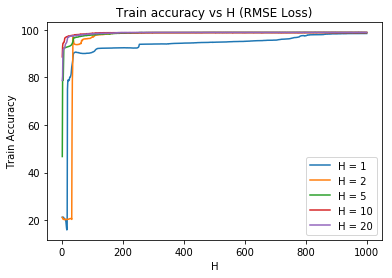

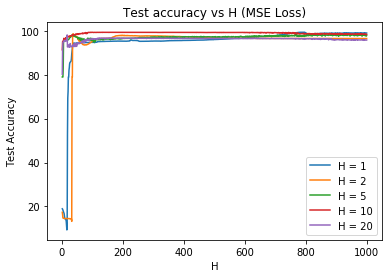

In [29]:
toplot = trainaccuracy
labels = ['H = 1', 'H = 2', 'H = 5', 'H = 10', 'H = 20']
graph(toplot, labels, 'Train accuracy vs H (RMSE Loss)', 'H', 'Train Accuracy')

toplot = testaccuracy
labels = ['H = 1', 'H = 2', 'H = 5', 'H = 10', 'H = 20']
graph(toplot, labels, 'Test accuracy vs H (MSE Loss)', 'H', 'Test Accuracy')

## Report

The net learns equally well for all the values of H.

H = 1, H = 10 perform slightly better in terms of Test Accuracy

## 1g

In [30]:
class Net2(nn.Module):                  # define a neural network with 1 hidden layer with H neurons
    
    def __init__(self, H1, H2):
        seed = 17
        torch.manual_seed(seed)
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(5, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, 1) 
#         nn.init.xavier_uniform(self.linear1.weight)
#         nn.init.xavier_uniform(self.linear2.weight)
        
        
    def forward(self, x):                           # forward method
        x = self.linear1(x)
        n = nn.LeakyReLU(0.2)
        x = n(x)
        x = self.linear2(x)
        x = n(x)
        x = self.linear3(x)
        m = nn.Sigmoid()
        x = m(x)
        return x 



In [31]:
train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle = True)

model = Net2(H1 = 5, H2 = 5)
optim = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0)
criterion = torch.nn.MSELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_sgd = []
testacc_sgd = []

epoch = 0
while epoch != 1000 :
# while epoch == 0 or epoch == 1 or testerror[-1] < testerror[-2]:
    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_sgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_sgd += [test_acc]
    
    basetrainerror += [base_trainerror]
    basetesterror += [base_testerror]
    
    no_epoch += [epoch]
#     print (list(model.parameters()))

print ('Train accuracy is {} % \nTest Accuracy is {} %\n'.format(train_acc, test_acc )) 


Train set 1: Average loss: 0.5687, Training Accuracy : 881/8143 (11%)


Test set 1: Average loss: 0.6575, Test Accuracy : 616/9752 (6%)


Train set 2: Average loss: 0.5032, Training Accuracy : 809/8143 (10%)


Test set 2: Average loss: 0.6178, Test Accuracy : 594/9752 (6%)


Train set 3: Average loss: 0.4720, Training Accuracy : 754/8143 (9%)


Test set 3: Average loss: 0.5780, Test Accuracy : 605/9752 (6%)


Train set 4: Average loss: 0.4431, Training Accuracy : 750/8143 (9%)


Test set 4: Average loss: 0.5373, Test Accuracy : 559/9752 (6%)


Train set 5: Average loss: 0.4167, Training Accuracy : 796/8143 (10%)


Test set 5: Average loss: 0.4973, Test Accuracy : 606/9752 (6%)


Train set 6: Average loss: 0.3935, Training Accuracy : 954/8143 (12%)


Test set 6: Average loss: 0.4595, Test Accuracy : 781/9752 (8%)


Train set 7: Average loss: 0.3739, Training Accuracy : 3888/8143 (48%)


Test set 7: Average loss: 0.4246, Test Accuracy : 3189/9752 (33%)


Train set 8: Average loss: 0.357


Train set 59: Average loss: 0.2126, Training Accuracy : 6414/8143 (79%)


Test set 59: Average loss: 0.2102, Test Accuracy : 7703/9752 (79%)


Train set 60: Average loss: 0.2126, Training Accuracy : 6414/8143 (79%)


Test set 60: Average loss: 0.2102, Test Accuracy : 7703/9752 (79%)


Train set 61: Average loss: 0.2126, Training Accuracy : 6414/8143 (79%)


Test set 61: Average loss: 0.2102, Test Accuracy : 7703/9752 (79%)


Train set 62: Average loss: 0.2126, Training Accuracy : 6414/8143 (79%)


Test set 62: Average loss: 0.2102, Test Accuracy : 7703/9752 (79%)


Train set 63: Average loss: 0.2126, Training Accuracy : 6414/8143 (79%)


Test set 63: Average loss: 0.2102, Test Accuracy : 7703/9752 (79%)


Train set 64: Average loss: 0.2126, Training Accuracy : 6414/8143 (79%)


Test set 64: Average loss: 0.2102, Test Accuracy : 7703/9752 (79%)


Train set 65: Average loss: 0.2126, Training Accuracy : 6414/8143 (79%)


Test set 65: Average loss: 0.2102, Test Accuracy : 7703/9752 (79%)



Test set 117: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 118: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 118: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 119: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 119: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 120: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 120: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 121: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 121: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 122: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 122: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 123: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 123: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 124: Average loss: 0.2124, Training Accuracy : 64


Train set 175: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 175: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 176: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 176: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 177: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 177: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 178: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 178: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 179: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 179: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 180: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 180: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 181: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 181: Average loss: 0.2101, Test Accuracy : 77


Train set 232: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 232: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 233: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 233: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 234: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 234: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 235: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 235: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 236: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 236: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 237: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 237: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 238: Average loss: 0.2124, Training Accuracy : 6414/8143 (79%)


Test set 238: Average loss: 0.2101, Test Accuracy : 77


Train set 289: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 289: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 290: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 290: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 291: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 291: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 292: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 292: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 293: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 293: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 294: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 294: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 295: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 295: Average loss: 0.2101, Test Accuracy : 77


Test set 345: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 346: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 346: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 347: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 347: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 348: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 348: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 349: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 349: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 350: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 350: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 351: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 351: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 352: Average loss: 0.2123, Training Accuracy : 64


Train set 403: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 403: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 404: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 404: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 405: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 405: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 406: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 406: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 407: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 407: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 408: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 408: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 409: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 409: Average loss: 0.2101, Test Accuracy : 77


Train set 460: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 460: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 461: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 461: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 462: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 462: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 463: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 463: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 464: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 464: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 465: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 465: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 466: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 466: Average loss: 0.2101, Test Accuracy : 77


Train set 518: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 518: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 519: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 519: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 520: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 520: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 521: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 521: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 522: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 522: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 523: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 523: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 524: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 524: Average loss: 0.2101, Test Accuracy : 77


Train set 575: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 575: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 576: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 576: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 577: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 577: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 578: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 578: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 579: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 579: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 580: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 580: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 581: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 581: Average loss: 0.2101, Test Accuracy : 77


Test set 632: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 633: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 633: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 634: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 634: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 635: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 635: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 636: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 636: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 637: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 637: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 638: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 638: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 639: Average loss: 0.2123, Training Accuracy : 64


Train set 691: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 691: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 692: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 692: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 693: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 693: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 694: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 694: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 695: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 695: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 696: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 696: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 697: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 697: Average loss: 0.2101, Test Accuracy : 77


Train set 749: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 749: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 750: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 750: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 751: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 751: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 752: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 752: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 753: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 753: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 754: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 754: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 755: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 755: Average loss: 0.2101, Test Accuracy : 77


Test set 805: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 806: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 806: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 807: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 807: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 808: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 808: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 809: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 809: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 810: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 810: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 811: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 811: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 812: Average loss: 0.2123, Training Accuracy : 64


Train set 863: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 863: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 864: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 864: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 865: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 865: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 866: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 866: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 867: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 867: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 868: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 868: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 869: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 869: Average loss: 0.2101, Test Accuracy : 77


Train set 920: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 920: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 921: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 921: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 922: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 922: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 923: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 923: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 924: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 924: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 925: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 925: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 926: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 926: Average loss: 0.2101, Test Accuracy : 77


Train set 978: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 978: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 979: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 979: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 980: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 980: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 981: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 981: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 982: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 982: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 983: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 983: Average loss: 0.2101, Test Accuracy : 7703/9752 (79%)


Train set 984: Average loss: 0.2123, Training Accuracy : 6414/8143 (79%)


Test set 984: Average loss: 0.2101, Test Accuracy : 77

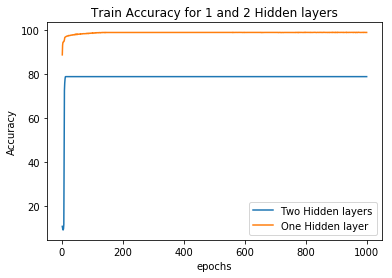

In [32]:
toplot = [trainacc_sgd, trainaccuracy[-2]]
labels = ['Two Hidden layers', 'One Hidden layer']
graph(toplot, labels, 'Train Accuracy for 1 and 2 Hidden layers', 'epochs', 'Accuracy')

In [33]:
train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle = True)

model = Net2(H1 = 10, H2 = 10)
optim = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0)
criterion = torch.nn.MSELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_sgd = []
testacc_sgd = []

epoch = 0
while epoch != 1000 :
# while epoch == 0 or epoch == 1 or testerror[-1] < testerror[-2]:
    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_sgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_sgd += [test_acc]
    
    basetrainerror += [base_trainerror]
    basetesterror += [base_testerror]
    
    no_epoch += [epoch]
#     print (list(model.parameters()))

print ('Train accuracy is {} % \nTest Accuracy is {} %\n'.format(train_acc, test_acc )) 


Train set 1: Average loss: 0.2111, Training Accuracy : 6410/8143 (79%)


Test set 1: Average loss: 0.1899, Test Accuracy : 7842/9752 (80%)


Train set 2: Average loss: 0.2106, Training Accuracy : 6410/8143 (79%)


Test set 2: Average loss: 0.1880, Test Accuracy : 7846/9752 (80%)


Train set 3: Average loss: 0.2099, Training Accuracy : 6410/8143 (79%)


Test set 3: Average loss: 0.1853, Test Accuracy : 7860/9752 (81%)


Train set 4: Average loss: 0.2083, Training Accuracy : 6410/8143 (79%)


Test set 4: Average loss: 0.1806, Test Accuracy : 7902/9752 (81%)


Train set 5: Average loss: 0.2037, Training Accuracy : 6410/8143 (79%)


Test set 5: Average loss: 0.1688, Test Accuracy : 7963/9752 (82%)


Train set 6: Average loss: 0.1774, Training Accuracy : 6453/8143 (79%)


Test set 6: Average loss: 0.1125, Test Accuracy : 8361/9752 (86%)


Train set 7: Average loss: 0.0760, Training Accuracy : 7321/8143 (90%)


Test set 7: Average loss: 0.0254, Test Accuracy : 9411/9752 (97%)


Train set 8:


Train set 59: Average loss: 0.0320, Training Accuracy : 7830/8143 (96%)


Test set 59: Average loss: 0.0324, Test Accuracy : 9383/9752 (96%)


Train set 60: Average loss: 0.0319, Training Accuracy : 7830/8143 (96%)


Test set 60: Average loss: 0.0325, Test Accuracy : 9405/9752 (96%)


Train set 61: Average loss: 0.0319, Training Accuracy : 7837/8143 (96%)


Test set 61: Average loss: 0.0323, Test Accuracy : 9366/9752 (96%)


Train set 62: Average loss: 0.0319, Training Accuracy : 7832/8143 (96%)


Test set 62: Average loss: 0.0324, Test Accuracy : 9403/9752 (96%)


Train set 63: Average loss: 0.0318, Training Accuracy : 7835/8143 (96%)


Test set 63: Average loss: 0.0324, Test Accuracy : 9415/9752 (97%)


Train set 64: Average loss: 0.0318, Training Accuracy : 7833/8143 (96%)


Test set 64: Average loss: 0.0322, Test Accuracy : 9368/9752 (96%)


Train set 65: Average loss: 0.0317, Training Accuracy : 7833/8143 (96%)


Test set 65: Average loss: 0.0323, Test Accuracy : 9387/9752 (96%)



Train set 117: Average loss: 0.0281, Training Accuracy : 7826/8143 (96%)


Test set 117: Average loss: 0.0282, Test Accuracy : 9473/9752 (97%)


Train set 118: Average loss: 0.0281, Training Accuracy : 7833/8143 (96%)


Test set 118: Average loss: 0.0283, Test Accuracy : 9481/9752 (97%)


Train set 119: Average loss: 0.0281, Training Accuracy : 7833/8143 (96%)


Test set 119: Average loss: 0.0284, Test Accuracy : 9487/9752 (97%)


Train set 120: Average loss: 0.0281, Training Accuracy : 7828/8143 (96%)


Test set 120: Average loss: 0.0282, Test Accuracy : 9482/9752 (97%)


Train set 121: Average loss: 0.0281, Training Accuracy : 7827/8143 (96%)


Test set 121: Average loss: 0.0284, Test Accuracy : 9494/9752 (97%)


Train set 122: Average loss: 0.0280, Training Accuracy : 7835/8143 (96%)


Test set 122: Average loss: 0.0280, Test Accuracy : 9471/9752 (97%)


Train set 123: Average loss: 0.0280, Training Accuracy : 7833/8143 (96%)


Test set 123: Average loss: 0.0281, Test Accuracy : 94


Train set 174: Average loss: 0.0271, Training Accuracy : 7831/8143 (96%)


Test set 174: Average loss: 0.0276, Test Accuracy : 9484/9752 (97%)


Train set 175: Average loss: 0.0271, Training Accuracy : 7838/8143 (96%)


Test set 175: Average loss: 0.0275, Test Accuracy : 9478/9752 (97%)


Train set 176: Average loss: 0.0270, Training Accuracy : 7834/8143 (96%)


Test set 176: Average loss: 0.0275, Test Accuracy : 9482/9752 (97%)


Train set 177: Average loss: 0.0270, Training Accuracy : 7841/8143 (96%)


Test set 177: Average loss: 0.0273, Test Accuracy : 9476/9752 (97%)


Train set 178: Average loss: 0.0270, Training Accuracy : 7829/8143 (96%)


Test set 178: Average loss: 0.0275, Test Accuracy : 9484/9752 (97%)


Train set 179: Average loss: 0.0270, Training Accuracy : 7840/8143 (96%)


Test set 179: Average loss: 0.0274, Test Accuracy : 9478/9752 (97%)


Train set 180: Average loss: 0.0270, Training Accuracy : 7841/8143 (96%)


Test set 180: Average loss: 0.0271, Test Accuracy : 94


Train set 232: Average loss: 0.0261, Training Accuracy : 7853/8143 (96%)


Test set 232: Average loss: 0.0263, Test Accuracy : 9476/9752 (97%)


Train set 233: Average loss: 0.0261, Training Accuracy : 7849/8143 (96%)


Test set 233: Average loss: 0.0265, Test Accuracy : 9478/9752 (97%)


Train set 234: Average loss: 0.0261, Training Accuracy : 7857/8143 (96%)


Test set 234: Average loss: 0.0262, Test Accuracy : 9465/9752 (97%)


Train set 235: Average loss: 0.0261, Training Accuracy : 7855/8143 (96%)


Test set 235: Average loss: 0.0262, Test Accuracy : 9468/9752 (97%)


Train set 236: Average loss: 0.0261, Training Accuracy : 7850/8143 (96%)


Test set 236: Average loss: 0.0264, Test Accuracy : 9479/9752 (97%)


Train set 237: Average loss: 0.0261, Training Accuracy : 7855/8143 (96%)


Test set 237: Average loss: 0.0261, Test Accuracy : 9465/9752 (97%)


Train set 238: Average loss: 0.0260, Training Accuracy : 7852/8143 (96%)


Test set 238: Average loss: 0.0264, Test Accuracy : 94


Train set 290: Average loss: 0.0254, Training Accuracy : 7867/8143 (97%)


Test set 290: Average loss: 0.0257, Test Accuracy : 9480/9752 (97%)


Train set 291: Average loss: 0.0253, Training Accuracy : 7865/8143 (97%)


Test set 291: Average loss: 0.0260, Test Accuracy : 9489/9752 (97%)


Train set 292: Average loss: 0.0253, Training Accuracy : 7870/8143 (97%)


Test set 292: Average loss: 0.0259, Test Accuracy : 9484/9752 (97%)


Train set 293: Average loss: 0.0253, Training Accuracy : 7878/8143 (97%)


Test set 293: Average loss: 0.0256, Test Accuracy : 9478/9752 (97%)


Train set 294: Average loss: 0.0253, Training Accuracy : 7868/8143 (97%)


Test set 294: Average loss: 0.0255, Test Accuracy : 9479/9752 (97%)


Train set 295: Average loss: 0.0253, Training Accuracy : 7868/8143 (97%)


Test set 295: Average loss: 0.0256, Test Accuracy : 9484/9752 (97%)


Train set 296: Average loss: 0.0252, Training Accuracy : 7871/8143 (97%)


Test set 296: Average loss: 0.0254, Test Accuracy : 94


Train set 347: Average loss: 0.0246, Training Accuracy : 7893/8143 (97%)


Test set 347: Average loss: 0.0247, Test Accuracy : 9474/9752 (97%)


Train set 348: Average loss: 0.0247, Training Accuracy : 7881/8143 (97%)


Test set 348: Average loss: 0.0249, Test Accuracy : 9487/9752 (97%)


Train set 349: Average loss: 0.0246, Training Accuracy : 7888/8143 (97%)


Test set 349: Average loss: 0.0247, Test Accuracy : 9477/9752 (97%)


Train set 350: Average loss: 0.0246, Training Accuracy : 7880/8143 (97%)


Test set 350: Average loss: 0.0247, Test Accuracy : 9486/9752 (97%)


Train set 351: Average loss: 0.0246, Training Accuracy : 7878/8143 (97%)


Test set 351: Average loss: 0.0249, Test Accuracy : 9487/9752 (97%)


Train set 352: Average loss: 0.0246, Training Accuracy : 7886/8143 (97%)


Test set 352: Average loss: 0.0250, Test Accuracy : 9495/9752 (97%)


Train set 353: Average loss: 0.0246, Training Accuracy : 7889/8143 (97%)


Test set 353: Average loss: 0.0247, Test Accuracy : 94


Train set 405: Average loss: 0.0241, Training Accuracy : 7901/8143 (97%)


Test set 405: Average loss: 0.0243, Test Accuracy : 9496/9752 (97%)


Train set 406: Average loss: 0.0240, Training Accuracy : 7886/8143 (97%)


Test set 406: Average loss: 0.0248, Test Accuracy : 9522/9752 (98%)


Train set 407: Average loss: 0.0241, Training Accuracy : 7898/8143 (97%)


Test set 407: Average loss: 0.0244, Test Accuracy : 9506/9752 (97%)


Train set 408: Average loss: 0.0240, Training Accuracy : 7909/8143 (97%)


Test set 408: Average loss: 0.0242, Test Accuracy : 9504/9752 (97%)


Train set 409: Average loss: 0.0240, Training Accuracy : 7897/8143 (97%)


Test set 409: Average loss: 0.0246, Test Accuracy : 9518/9752 (98%)


Train set 410: Average loss: 0.0240, Training Accuracy : 7894/8143 (97%)


Test set 410: Average loss: 0.0247, Test Accuracy : 9522/9752 (98%)


Train set 411: Average loss: 0.0240, Training Accuracy : 7902/8143 (97%)


Test set 411: Average loss: 0.0243, Test Accuracy : 95


Train set 463: Average loss: 0.0235, Training Accuracy : 7910/8143 (97%)


Test set 463: Average loss: 0.0238, Test Accuracy : 9518/9752 (98%)


Train set 464: Average loss: 0.0235, Training Accuracy : 7909/8143 (97%)


Test set 464: Average loss: 0.0241, Test Accuracy : 9531/9752 (98%)


Train set 465: Average loss: 0.0235, Training Accuracy : 7898/8143 (97%)


Test set 465: Average loss: 0.0238, Test Accuracy : 9520/9752 (98%)


Train set 466: Average loss: 0.0235, Training Accuracy : 7904/8143 (97%)


Test set 466: Average loss: 0.0240, Test Accuracy : 9531/9752 (98%)


Train set 467: Average loss: 0.0235, Training Accuracy : 7911/8143 (97%)


Test set 467: Average loss: 0.0236, Test Accuracy : 9512/9752 (98%)


Train set 468: Average loss: 0.0235, Training Accuracy : 7908/8143 (97%)


Test set 468: Average loss: 0.0241, Test Accuracy : 9531/9752 (98%)


Train set 469: Average loss: 0.0235, Training Accuracy : 7909/8143 (97%)


Test set 469: Average loss: 0.0239, Test Accuracy : 95


Train set 521: Average loss: 0.0230, Training Accuracy : 7915/8143 (97%)


Test set 521: Average loss: 0.0231, Test Accuracy : 9520/9752 (98%)


Train set 522: Average loss: 0.0230, Training Accuracy : 7911/8143 (97%)


Test set 522: Average loss: 0.0233, Test Accuracy : 9529/9752 (98%)


Train set 523: Average loss: 0.0230, Training Accuracy : 7911/8143 (97%)


Test set 523: Average loss: 0.0233, Test Accuracy : 9530/9752 (98%)


Train set 524: Average loss: 0.0230, Training Accuracy : 7910/8143 (97%)


Test set 524: Average loss: 0.0231, Test Accuracy : 9522/9752 (98%)


Train set 525: Average loss: 0.0230, Training Accuracy : 7902/8143 (97%)


Test set 525: Average loss: 0.0240, Test Accuracy : 9500/9752 (97%)


Train set 526: Average loss: 0.0230, Training Accuracy : 7922/8143 (97%)


Test set 526: Average loss: 0.0234, Test Accuracy : 9530/9752 (98%)


Train set 527: Average loss: 0.0230, Training Accuracy : 7921/8143 (97%)


Test set 527: Average loss: 0.0231, Test Accuracy : 95


Train set 579: Average loss: 0.0226, Training Accuracy : 7915/8143 (97%)


Test set 579: Average loss: 0.0231, Test Accuracy : 9540/9752 (98%)


Train set 580: Average loss: 0.0226, Training Accuracy : 7918/8143 (97%)


Test set 580: Average loss: 0.0238, Test Accuracy : 9489/9752 (97%)


Train set 581: Average loss: 0.0226, Training Accuracy : 7928/8143 (97%)


Test set 581: Average loss: 0.0230, Test Accuracy : 9541/9752 (98%)


Train set 582: Average loss: 0.0226, Training Accuracy : 7919/8143 (97%)


Test set 582: Average loss: 0.0233, Test Accuracy : 9529/9752 (98%)


Train set 583: Average loss: 0.0225, Training Accuracy : 7923/8143 (97%)


Test set 583: Average loss: 0.0231, Test Accuracy : 9539/9752 (98%)


Train set 584: Average loss: 0.0226, Training Accuracy : 7914/8143 (97%)


Test set 584: Average loss: 0.0231, Test Accuracy : 9540/9752 (98%)


Train set 585: Average loss: 0.0226, Training Accuracy : 7918/8143 (97%)


Test set 585: Average loss: 0.0231, Test Accuracy : 95


Train set 637: Average loss: 0.0222, Training Accuracy : 7925/8143 (97%)


Test set 637: Average loss: 0.0227, Test Accuracy : 9549/9752 (98%)


Train set 638: Average loss: 0.0222, Training Accuracy : 7929/8143 (97%)


Test set 638: Average loss: 0.0223, Test Accuracy : 9542/9752 (98%)


Train set 639: Average loss: 0.0221, Training Accuracy : 7926/8143 (97%)


Test set 639: Average loss: 0.0222, Test Accuracy : 9537/9752 (98%)


Train set 640: Average loss: 0.0222, Training Accuracy : 7924/8143 (97%)


Test set 640: Average loss: 0.0225, Test Accuracy : 9550/9752 (98%)


Train set 641: Average loss: 0.0222, Training Accuracy : 7925/8143 (97%)


Test set 641: Average loss: 0.0223, Test Accuracy : 9542/9752 (98%)


Train set 642: Average loss: 0.0222, Training Accuracy : 7914/8143 (97%)


Test set 642: Average loss: 0.0226, Test Accuracy : 9547/9752 (98%)


Train set 643: Average loss: 0.0222, Training Accuracy : 7921/8143 (97%)


Test set 643: Average loss: 0.0223, Test Accuracy : 95


Train set 694: Average loss: 0.0218, Training Accuracy : 7932/8143 (97%)


Test set 694: Average loss: 0.0219, Test Accuracy : 9545/9752 (98%)


Train set 695: Average loss: 0.0218, Training Accuracy : 7928/8143 (97%)


Test set 695: Average loss: 0.0220, Test Accuracy : 9549/9752 (98%)


Train set 696: Average loss: 0.0218, Training Accuracy : 7935/8143 (97%)


Test set 696: Average loss: 0.0224, Test Accuracy : 9541/9752 (98%)


Train set 697: Average loss: 0.0218, Training Accuracy : 7936/8143 (97%)


Test set 697: Average loss: 0.0218, Test Accuracy : 9543/9752 (98%)


Train set 698: Average loss: 0.0218, Training Accuracy : 7926/8143 (97%)


Test set 698: Average loss: 0.0222, Test Accuracy : 9552/9752 (98%)


Train set 699: Average loss: 0.0218, Training Accuracy : 7938/8143 (97%)


Test set 699: Average loss: 0.0221, Test Accuracy : 9553/9752 (98%)


Train set 700: Average loss: 0.0218, Training Accuracy : 7926/8143 (97%)


Test set 700: Average loss: 0.0220, Test Accuracy : 95


Train set 751: Average loss: 0.0215, Training Accuracy : 7939/8143 (97%)


Test set 751: Average loss: 0.0222, Test Accuracy : 9535/9752 (98%)


Train set 752: Average loss: 0.0215, Training Accuracy : 7935/8143 (97%)


Test set 752: Average loss: 0.0244, Test Accuracy : 9463/9752 (97%)


Train set 753: Average loss: 0.0215, Training Accuracy : 7943/8143 (98%)


Test set 753: Average loss: 0.0223, Test Accuracy : 9517/9752 (98%)


Train set 754: Average loss: 0.0215, Training Accuracy : 7939/8143 (97%)


Test set 754: Average loss: 0.0218, Test Accuracy : 9554/9752 (98%)


Train set 755: Average loss: 0.0215, Training Accuracy : 7936/8143 (97%)


Test set 755: Average loss: 0.0223, Test Accuracy : 9516/9752 (98%)


Train set 756: Average loss: 0.0215, Training Accuracy : 7939/8143 (97%)


Test set 756: Average loss: 0.0216, Test Accuracy : 9547/9752 (98%)


Train set 757: Average loss: 0.0215, Training Accuracy : 7944/8143 (98%)


Test set 757: Average loss: 0.0214, Test Accuracy : 95


Train set 809: Average loss: 0.0212, Training Accuracy : 7941/8143 (98%)


Test set 809: Average loss: 0.0222, Test Accuracy : 9494/9752 (97%)


Train set 810: Average loss: 0.0212, Training Accuracy : 7946/8143 (98%)


Test set 810: Average loss: 0.0217, Test Accuracy : 9546/9752 (98%)


Train set 811: Average loss: 0.0212, Training Accuracy : 7943/8143 (98%)


Test set 811: Average loss: 0.0218, Test Accuracy : 9535/9752 (98%)


Train set 812: Average loss: 0.0212, Training Accuracy : 7946/8143 (98%)


Test set 812: Average loss: 0.0213, Test Accuracy : 9552/9752 (98%)


Train set 813: Average loss: 0.0212, Training Accuracy : 7941/8143 (98%)


Test set 813: Average loss: 0.0222, Test Accuracy : 9488/9752 (97%)


Train set 814: Average loss: 0.0212, Training Accuracy : 7948/8143 (98%)


Test set 814: Average loss: 0.0220, Test Accuracy : 9519/9752 (98%)


Train set 815: Average loss: 0.0212, Training Accuracy : 7950/8143 (98%)


Test set 815: Average loss: 0.0216, Test Accuracy : 95


Train set 867: Average loss: 0.0209, Training Accuracy : 7945/8143 (98%)


Test set 867: Average loss: 0.0217, Test Accuracy : 9528/9752 (98%)


Train set 868: Average loss: 0.0209, Training Accuracy : 7946/8143 (98%)


Test set 868: Average loss: 0.0219, Test Accuracy : 9503/9752 (97%)


Train set 869: Average loss: 0.0209, Training Accuracy : 7953/8143 (98%)


Test set 869: Average loss: 0.0211, Test Accuracy : 9553/9752 (98%)


Train set 870: Average loss: 0.0209, Training Accuracy : 7949/8143 (98%)


Test set 870: Average loss: 0.0213, Test Accuracy : 9555/9752 (98%)


Train set 871: Average loss: 0.0209, Training Accuracy : 7955/8143 (98%)


Test set 871: Average loss: 0.0211, Test Accuracy : 9555/9752 (98%)


Train set 872: Average loss: 0.0209, Training Accuracy : 7956/8143 (98%)


Test set 872: Average loss: 0.0209, Test Accuracy : 9546/9752 (98%)


Train set 873: Average loss: 0.0209, Training Accuracy : 7948/8143 (98%)


Test set 873: Average loss: 0.0210, Test Accuracy : 95


Train set 924: Average loss: 0.0207, Training Accuracy : 7955/8143 (98%)


Test set 924: Average loss: 0.0214, Test Accuracy : 9524/9752 (98%)


Train set 925: Average loss: 0.0207, Training Accuracy : 7963/8143 (98%)


Test set 925: Average loss: 0.0208, Test Accuracy : 9553/9752 (98%)


Train set 926: Average loss: 0.0207, Training Accuracy : 7959/8143 (98%)


Test set 926: Average loss: 0.0207, Test Accuracy : 9554/9752 (98%)


Train set 927: Average loss: 0.0207, Training Accuracy : 7957/8143 (98%)


Test set 927: Average loss: 0.0208, Test Accuracy : 9556/9752 (98%)


Train set 928: Average loss: 0.0207, Training Accuracy : 7954/8143 (98%)


Test set 928: Average loss: 0.0213, Test Accuracy : 9541/9752 (98%)


Train set 929: Average loss: 0.0207, Training Accuracy : 7953/8143 (98%)


Test set 929: Average loss: 0.0213, Test Accuracy : 9536/9752 (98%)


Train set 930: Average loss: 0.0207, Training Accuracy : 7954/8143 (98%)


Test set 930: Average loss: 0.0216, Test Accuracy : 94


Train set 981: Average loss: 0.0205, Training Accuracy : 7958/8143 (98%)


Test set 981: Average loss: 0.0207, Test Accuracy : 9564/9752 (98%)


Train set 982: Average loss: 0.0205, Training Accuracy : 7962/8143 (98%)


Test set 982: Average loss: 0.0212, Test Accuracy : 9521/9752 (98%)


Train set 983: Average loss: 0.0205, Training Accuracy : 7963/8143 (98%)


Test set 983: Average loss: 0.0209, Test Accuracy : 9550/9752 (98%)


Train set 984: Average loss: 0.0204, Training Accuracy : 7966/8143 (98%)


Test set 984: Average loss: 0.0205, Test Accuracy : 9554/9752 (98%)


Train set 985: Average loss: 0.0205, Training Accuracy : 7962/8143 (98%)


Test set 985: Average loss: 0.0212, Test Accuracy : 9525/9752 (98%)


Train set 986: Average loss: 0.0204, Training Accuracy : 7962/8143 (98%)


Test set 986: Average loss: 0.0212, Test Accuracy : 9514/9752 (98%)


Train set 987: Average loss: 0.0204, Training Accuracy : 7958/8143 (98%)


Test set 987: Average loss: 0.0211, Test Accuracy : 95

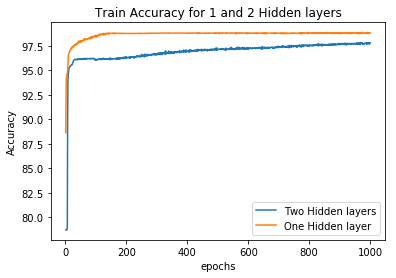

In [34]:
toplot = [trainacc_sgd, trainaccuracy[-2]]
labels = ['Two Hidden layers', 'One Hidden layer']
graph(toplot, labels, 'Train Accuracy for 1 and 2 Hidden layers', 'epochs', 'Accuracy')

In [35]:
train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle = True)

model = Net2(H1 = 10, H2 = 5)
optim = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0)
criterion = torch.nn.MSELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_sgd = []
testacc_sgd = []

epoch = 0
while epoch != 1000 :
# while epoch == 0 or epoch == 1 or testerror[-1] < testerror[-2]:
    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_sgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_sgd += [test_acc]
    
    basetrainerror += [base_trainerror]
    basetesterror += [base_testerror]
    
    no_epoch += [epoch]
#     print (list(model.parameters()))

print ('Train accuracy is {} % \nTest Accuracy is {} %\n'.format(train_acc, test_acc )) 


Train set 1: Average loss: 0.5686, Training Accuracy : 2396/8143 (29%)


Test set 1: Average loss: 0.1558, Test Accuracy : 8361/9752 (86%)


Train set 2: Average loss: 0.1176, Training Accuracy : 7246/8143 (89%)


Test set 2: Average loss: 0.0851, Test Accuracy : 8822/9752 (90%)


Train set 3: Average loss: 0.0877, Training Accuracy : 7420/8143 (91%)


Test set 3: Average loss: 0.0744, Test Accuracy : 8965/9752 (92%)


Train set 4: Average loss: 0.0809, Training Accuracy : 7458/8143 (92%)


Test set 4: Average loss: 0.0688, Test Accuracy : 9028/9752 (93%)


Train set 5: Average loss: 0.0774, Training Accuracy : 7473/8143 (92%)


Test set 5: Average loss: 0.0652, Test Accuracy : 9074/9752 (93%)


Train set 6: Average loss: 0.0750, Training Accuracy : 7493/8143 (92%)


Test set 6: Average loss: 0.0625, Test Accuracy : 9100/9752 (93%)


Train set 7: Average loss: 0.0733, Training Accuracy : 7512/8143 (92%)


Test set 7: Average loss: 0.0605, Test Accuracy : 9124/9752 (94%)


Train set 8:


Train set 60: Average loss: 0.0712, Training Accuracy : 7532/8143 (92%)


Test set 60: Average loss: 0.0576, Test Accuracy : 9149/9752 (94%)


Train set 61: Average loss: 0.0712, Training Accuracy : 7533/8143 (93%)


Test set 61: Average loss: 0.0576, Test Accuracy : 9149/9752 (94%)


Train set 62: Average loss: 0.0712, Training Accuracy : 7532/8143 (92%)


Test set 62: Average loss: 0.0577, Test Accuracy : 9147/9752 (94%)


Train set 63: Average loss: 0.0712, Training Accuracy : 7533/8143 (93%)


Test set 63: Average loss: 0.0577, Test Accuracy : 9148/9752 (94%)


Train set 64: Average loss: 0.0712, Training Accuracy : 7533/8143 (93%)


Test set 64: Average loss: 0.0577, Test Accuracy : 9148/9752 (94%)


Train set 65: Average loss: 0.0712, Training Accuracy : 7533/8143 (93%)


Test set 65: Average loss: 0.0578, Test Accuracy : 9147/9752 (94%)


Train set 66: Average loss: 0.0712, Training Accuracy : 7533/8143 (93%)


Test set 66: Average loss: 0.0577, Test Accuracy : 9147/9752 (94%)



Train set 118: Average loss: 0.0708, Training Accuracy : 7538/8143 (93%)


Test set 118: Average loss: 0.0572, Test Accuracy : 9149/9752 (94%)


Train set 119: Average loss: 0.0707, Training Accuracy : 7540/8143 (93%)


Test set 119: Average loss: 0.0573, Test Accuracy : 9149/9752 (94%)


Train set 120: Average loss: 0.0707, Training Accuracy : 7539/8143 (93%)


Test set 120: Average loss: 0.0573, Test Accuracy : 9149/9752 (94%)


Train set 121: Average loss: 0.0707, Training Accuracy : 7538/8143 (93%)


Test set 121: Average loss: 0.0574, Test Accuracy : 9149/9752 (94%)


Train set 122: Average loss: 0.0707, Training Accuracy : 7538/8143 (93%)


Test set 122: Average loss: 0.0573, Test Accuracy : 9149/9752 (94%)


Train set 123: Average loss: 0.0707, Training Accuracy : 7539/8143 (93%)


Test set 123: Average loss: 0.0572, Test Accuracy : 9149/9752 (94%)


Train set 124: Average loss: 0.0707, Training Accuracy : 7538/8143 (93%)


Test set 124: Average loss: 0.0572, Test Accuracy : 91


Test set 174: Average loss: 0.0568, Test Accuracy : 9152/9752 (94%)


Train set 175: Average loss: 0.0703, Training Accuracy : 7542/8143 (93%)


Test set 175: Average loss: 0.0568, Test Accuracy : 9152/9752 (94%)


Train set 176: Average loss: 0.0703, Training Accuracy : 7542/8143 (93%)


Test set 176: Average loss: 0.0568, Test Accuracy : 9152/9752 (94%)


Train set 177: Average loss: 0.0703, Training Accuracy : 7542/8143 (93%)


Test set 177: Average loss: 0.0568, Test Accuracy : 9152/9752 (94%)


Train set 178: Average loss: 0.0703, Training Accuracy : 7542/8143 (93%)


Test set 178: Average loss: 0.0568, Test Accuracy : 9152/9752 (94%)


Train set 179: Average loss: 0.0703, Training Accuracy : 7542/8143 (93%)


Test set 179: Average loss: 0.0568, Test Accuracy : 9152/9752 (94%)


Train set 180: Average loss: 0.0703, Training Accuracy : 7542/8143 (93%)


Test set 180: Average loss: 0.0567, Test Accuracy : 9152/9752 (94%)


Train set 181: Average loss: 0.0703, Training Accuracy : 75


Train set 233: Average loss: 0.0699, Training Accuracy : 7544/8143 (93%)


Test set 233: Average loss: 0.0563, Test Accuracy : 9157/9752 (94%)


Train set 234: Average loss: 0.0699, Training Accuracy : 7544/8143 (93%)


Test set 234: Average loss: 0.0563, Test Accuracy : 9158/9752 (94%)


Train set 235: Average loss: 0.0699, Training Accuracy : 7544/8143 (93%)


Test set 235: Average loss: 0.0563, Test Accuracy : 9158/9752 (94%)


Train set 236: Average loss: 0.0699, Training Accuracy : 7544/8143 (93%)


Test set 236: Average loss: 0.0562, Test Accuracy : 9158/9752 (94%)


Train set 237: Average loss: 0.0698, Training Accuracy : 7544/8143 (93%)


Test set 237: Average loss: 0.0562, Test Accuracy : 9158/9752 (94%)


Train set 238: Average loss: 0.0698, Training Accuracy : 7544/8143 (93%)


Test set 238: Average loss: 0.0562, Test Accuracy : 9159/9752 (94%)


Train set 239: Average loss: 0.0698, Training Accuracy : 7544/8143 (93%)


Test set 239: Average loss: 0.0562, Test Accuracy : 91


Test set 290: Average loss: 0.0558, Test Accuracy : 9160/9752 (94%)


Train set 291: Average loss: 0.0694, Training Accuracy : 7550/8143 (93%)


Test set 291: Average loss: 0.0558, Test Accuracy : 9160/9752 (94%)


Train set 292: Average loss: 0.0694, Training Accuracy : 7549/8143 (93%)


Test set 292: Average loss: 0.0558, Test Accuracy : 9160/9752 (94%)


Train set 293: Average loss: 0.0694, Training Accuracy : 7548/8143 (93%)


Test set 293: Average loss: 0.0557, Test Accuracy : 9160/9752 (94%)


Train set 294: Average loss: 0.0694, Training Accuracy : 7549/8143 (93%)


Test set 294: Average loss: 0.0558, Test Accuracy : 9160/9752 (94%)


Train set 295: Average loss: 0.0694, Training Accuracy : 7552/8143 (93%)


Test set 295: Average loss: 0.0558, Test Accuracy : 9160/9752 (94%)


Train set 296: Average loss: 0.0694, Training Accuracy : 7550/8143 (93%)


Test set 296: Average loss: 0.0558, Test Accuracy : 9160/9752 (94%)


Train set 297: Average loss: 0.0694, Training Accuracy : 75


Train set 349: Average loss: 0.0689, Training Accuracy : 7554/8143 (93%)


Test set 349: Average loss: 0.0552, Test Accuracy : 9161/9752 (94%)


Train set 350: Average loss: 0.0689, Training Accuracy : 7554/8143 (93%)


Test set 350: Average loss: 0.0552, Test Accuracy : 9161/9752 (94%)


Train set 351: Average loss: 0.0689, Training Accuracy : 7554/8143 (93%)


Test set 351: Average loss: 0.0552, Test Accuracy : 9161/9752 (94%)


Train set 352: Average loss: 0.0689, Training Accuracy : 7554/8143 (93%)


Test set 352: Average loss: 0.0552, Test Accuracy : 9162/9752 (94%)


Train set 353: Average loss: 0.0689, Training Accuracy : 7554/8143 (93%)


Test set 353: Average loss: 0.0552, Test Accuracy : 9161/9752 (94%)


Train set 354: Average loss: 0.0689, Training Accuracy : 7554/8143 (93%)


Test set 354: Average loss: 0.0552, Test Accuracy : 9161/9752 (94%)


Train set 355: Average loss: 0.0689, Training Accuracy : 7554/8143 (93%)


Test set 355: Average loss: 0.0552, Test Accuracy : 91


Train set 406: Average loss: 0.0684, Training Accuracy : 7555/8143 (93%)


Test set 406: Average loss: 0.0546, Test Accuracy : 9168/9752 (94%)


Train set 407: Average loss: 0.0684, Training Accuracy : 7555/8143 (93%)


Test set 407: Average loss: 0.0546, Test Accuracy : 9168/9752 (94%)


Train set 408: Average loss: 0.0684, Training Accuracy : 7554/8143 (93%)


Test set 408: Average loss: 0.0546, Test Accuracy : 9168/9752 (94%)


Train set 409: Average loss: 0.0684, Training Accuracy : 7556/8143 (93%)


Test set 409: Average loss: 0.0547, Test Accuracy : 9167/9752 (94%)


Train set 410: Average loss: 0.0684, Training Accuracy : 7555/8143 (93%)


Test set 410: Average loss: 0.0546, Test Accuracy : 9167/9752 (94%)


Train set 411: Average loss: 0.0684, Training Accuracy : 7555/8143 (93%)


Test set 411: Average loss: 0.0546, Test Accuracy : 9168/9752 (94%)


Train set 412: Average loss: 0.0684, Training Accuracy : 7556/8143 (93%)


Test set 412: Average loss: 0.0546, Test Accuracy : 91


Train set 464: Average loss: 0.0678, Training Accuracy : 7556/8143 (93%)


Test set 464: Average loss: 0.0540, Test Accuracy : 9171/9752 (94%)


Train set 465: Average loss: 0.0678, Training Accuracy : 7556/8143 (93%)


Test set 465: Average loss: 0.0540, Test Accuracy : 9171/9752 (94%)


Train set 466: Average loss: 0.0678, Training Accuracy : 7556/8143 (93%)


Test set 466: Average loss: 0.0539, Test Accuracy : 9171/9752 (94%)


Train set 467: Average loss: 0.0678, Training Accuracy : 7556/8143 (93%)


Test set 467: Average loss: 0.0539, Test Accuracy : 9171/9752 (94%)


Train set 468: Average loss: 0.0678, Training Accuracy : 7556/8143 (93%)


Test set 468: Average loss: 0.0539, Test Accuracy : 9171/9752 (94%)


Train set 469: Average loss: 0.0678, Training Accuracy : 7557/8143 (93%)


Test set 469: Average loss: 0.0538, Test Accuracy : 9171/9752 (94%)


Train set 470: Average loss: 0.0678, Training Accuracy : 7556/8143 (93%)


Test set 470: Average loss: 0.0538, Test Accuracy : 91


Train set 521: Average loss: 0.0671, Training Accuracy : 7566/8143 (93%)


Test set 521: Average loss: 0.0532, Test Accuracy : 9175/9752 (94%)


Train set 522: Average loss: 0.0671, Training Accuracy : 7566/8143 (93%)


Test set 522: Average loss: 0.0531, Test Accuracy : 9176/9752 (94%)


Train set 523: Average loss: 0.0671, Training Accuracy : 7566/8143 (93%)


Test set 523: Average loss: 0.0531, Test Accuracy : 9175/9752 (94%)


Train set 524: Average loss: 0.0671, Training Accuracy : 7566/8143 (93%)


Test set 524: Average loss: 0.0531, Test Accuracy : 9175/9752 (94%)


Train set 525: Average loss: 0.0671, Training Accuracy : 7566/8143 (93%)


Test set 525: Average loss: 0.0531, Test Accuracy : 9175/9752 (94%)


Train set 526: Average loss: 0.0671, Training Accuracy : 7565/8143 (93%)


Test set 526: Average loss: 0.0529, Test Accuracy : 9176/9752 (94%)


Train set 527: Average loss: 0.0671, Training Accuracy : 7566/8143 (93%)


Test set 527: Average loss: 0.0530, Test Accuracy : 91



Train set 578: Average loss: 0.0663, Training Accuracy : 7573/8143 (93%)


Test set 578: Average loss: 0.0521, Test Accuracy : 9185/9752 (94%)


Train set 579: Average loss: 0.0663, Training Accuracy : 7572/8143 (93%)


Test set 579: Average loss: 0.0520, Test Accuracy : 9185/9752 (94%)


Train set 580: Average loss: 0.0663, Training Accuracy : 7573/8143 (93%)


Test set 580: Average loss: 0.0519, Test Accuracy : 9186/9752 (94%)


Train set 581: Average loss: 0.0663, Training Accuracy : 7573/8143 (93%)


Test set 581: Average loss: 0.0520, Test Accuracy : 9185/9752 (94%)


Train set 582: Average loss: 0.0662, Training Accuracy : 7573/8143 (93%)


Test set 582: Average loss: 0.0520, Test Accuracy : 9185/9752 (94%)


Train set 583: Average loss: 0.0662, Training Accuracy : 7573/8143 (93%)


Test set 583: Average loss: 0.0519, Test Accuracy : 9186/9752 (94%)


Train set 584: Average loss: 0.0662, Training Accuracy : 7573/8143 (93%)


Test set 584: Average loss: 0.0520, Test Accuracy : 9


Train set 635: Average loss: 0.0651, Training Accuracy : 7580/8143 (93%)


Test set 635: Average loss: 0.0505, Test Accuracy : 9194/9752 (94%)


Train set 636: Average loss: 0.0651, Training Accuracy : 7583/8143 (93%)


Test set 636: Average loss: 0.0505, Test Accuracy : 9192/9752 (94%)


Train set 637: Average loss: 0.0650, Training Accuracy : 7582/8143 (93%)


Test set 637: Average loss: 0.0506, Test Accuracy : 9192/9752 (94%)


Train set 638: Average loss: 0.0650, Training Accuracy : 7582/8143 (93%)


Test set 638: Average loss: 0.0505, Test Accuracy : 9192/9752 (94%)


Train set 639: Average loss: 0.0650, Training Accuracy : 7583/8143 (93%)


Test set 639: Average loss: 0.0504, Test Accuracy : 9194/9752 (94%)


Train set 640: Average loss: 0.0649, Training Accuracy : 7584/8143 (93%)


Test set 640: Average loss: 0.0503, Test Accuracy : 9194/9752 (94%)


Train set 641: Average loss: 0.0649, Training Accuracy : 7581/8143 (93%)


Test set 641: Average loss: 0.0501, Test Accuracy : 91


Train set 692: Average loss: 0.0622, Training Accuracy : 7592/8143 (93%)


Test set 692: Average loss: 0.0469, Test Accuracy : 9211/9752 (94%)


Train set 693: Average loss: 0.0621, Training Accuracy : 7592/8143 (93%)


Test set 693: Average loss: 0.0468, Test Accuracy : 9211/9752 (94%)


Train set 694: Average loss: 0.0620, Training Accuracy : 7592/8143 (93%)


Test set 694: Average loss: 0.0468, Test Accuracy : 9211/9752 (94%)


Train set 695: Average loss: 0.0620, Training Accuracy : 7592/8143 (93%)


Test set 695: Average loss: 0.0466, Test Accuracy : 9211/9752 (94%)


Train set 696: Average loss: 0.0619, Training Accuracy : 7592/8143 (93%)


Test set 696: Average loss: 0.0466, Test Accuracy : 9211/9752 (94%)


Train set 697: Average loss: 0.0618, Training Accuracy : 7592/8143 (93%)


Test set 697: Average loss: 0.0464, Test Accuracy : 9213/9752 (94%)


Train set 698: Average loss: 0.0617, Training Accuracy : 7592/8143 (93%)


Test set 698: Average loss: 0.0464, Test Accuracy : 92


Train set 750: Average loss: 0.0385, Training Accuracy : 7659/8143 (94%)


Test set 750: Average loss: 0.0316, Test Accuracy : 9287/9752 (95%)


Train set 751: Average loss: 0.0382, Training Accuracy : 7659/8143 (94%)


Test set 751: Average loss: 0.0318, Test Accuracy : 9287/9752 (95%)


Train set 752: Average loss: 0.0379, Training Accuracy : 7660/8143 (94%)


Test set 752: Average loss: 0.0320, Test Accuracy : 9288/9752 (95%)


Train set 753: Average loss: 0.0377, Training Accuracy : 7662/8143 (94%)


Test set 753: Average loss: 0.0323, Test Accuracy : 9283/9752 (95%)


Train set 754: Average loss: 0.0374, Training Accuracy : 7664/8143 (94%)


Test set 754: Average loss: 0.0325, Test Accuracy : 9279/9752 (95%)


Train set 755: Average loss: 0.0373, Training Accuracy : 7654/8143 (94%)


Test set 755: Average loss: 0.0326, Test Accuracy : 9285/9752 (95%)


Train set 756: Average loss: 0.0371, Training Accuracy : 7659/8143 (94%)


Test set 756: Average loss: 0.0328, Test Accuracy : 92


Train set 807: Average loss: 0.0353, Training Accuracy : 7659/8143 (94%)


Test set 807: Average loss: 0.0339, Test Accuracy : 9277/9752 (95%)


Train set 808: Average loss: 0.0353, Training Accuracy : 7667/8143 (94%)


Test set 808: Average loss: 0.0339, Test Accuracy : 9277/9752 (95%)


Train set 809: Average loss: 0.0353, Training Accuracy : 7661/8143 (94%)


Test set 809: Average loss: 0.0339, Test Accuracy : 9277/9752 (95%)


Train set 810: Average loss: 0.0353, Training Accuracy : 7668/8143 (94%)


Test set 810: Average loss: 0.0339, Test Accuracy : 9278/9752 (95%)


Train set 811: Average loss: 0.0352, Training Accuracy : 7673/8143 (94%)


Test set 811: Average loss: 0.0339, Test Accuracy : 9276/9752 (95%)


Train set 812: Average loss: 0.0352, Training Accuracy : 7662/8143 (94%)


Test set 812: Average loss: 0.0339, Test Accuracy : 9287/9752 (95%)


Train set 813: Average loss: 0.0352, Training Accuracy : 7672/8143 (94%)


Test set 813: Average loss: 0.0339, Test Accuracy : 92


Train set 864: Average loss: 0.0341, Training Accuracy : 7748/8143 (95%)


Test set 864: Average loss: 0.0333, Test Accuracy : 9308/9752 (95%)


Train set 865: Average loss: 0.0340, Training Accuracy : 7749/8143 (95%)


Test set 865: Average loss: 0.0332, Test Accuracy : 9298/9752 (95%)


Train set 866: Average loss: 0.0340, Training Accuracy : 7748/8143 (95%)


Test set 866: Average loss: 0.0332, Test Accuracy : 9300/9752 (95%)


Train set 867: Average loss: 0.0340, Training Accuracy : 7747/8143 (95%)


Test set 867: Average loss: 0.0332, Test Accuracy : 9308/9752 (95%)


Train set 868: Average loss: 0.0340, Training Accuracy : 7749/8143 (95%)


Test set 868: Average loss: 0.0332, Test Accuracy : 9298/9752 (95%)


Train set 869: Average loss: 0.0340, Training Accuracy : 7745/8143 (95%)


Test set 869: Average loss: 0.0332, Test Accuracy : 9308/9752 (95%)


Train set 870: Average loss: 0.0339, Training Accuracy : 7749/8143 (95%)


Test set 870: Average loss: 0.0332, Test Accuracy : 93


Test set 920: Average loss: 0.0326, Test Accuracy : 9320/9752 (96%)


Train set 921: Average loss: 0.0329, Training Accuracy : 7746/8143 (95%)


Test set 921: Average loss: 0.0325, Test Accuracy : 9316/9752 (96%)


Train set 922: Average loss: 0.0328, Training Accuracy : 7749/8143 (95%)


Test set 922: Average loss: 0.0326, Test Accuracy : 9324/9752 (96%)


Train set 923: Average loss: 0.0328, Training Accuracy : 7746/8143 (95%)


Test set 923: Average loss: 0.0325, Test Accuracy : 9317/9752 (96%)


Train set 924: Average loss: 0.0328, Training Accuracy : 7749/8143 (95%)


Test set 924: Average loss: 0.0325, Test Accuracy : 9318/9752 (96%)


Train set 925: Average loss: 0.0327, Training Accuracy : 7749/8143 (95%)


Test set 925: Average loss: 0.0325, Test Accuracy : 9317/9752 (96%)


Train set 926: Average loss: 0.0327, Training Accuracy : 7747/8143 (95%)


Test set 926: Average loss: 0.0324, Test Accuracy : 9317/9752 (96%)


Train set 927: Average loss: 0.0326, Training Accuracy : 77


Train set 978: Average loss: 0.0296, Training Accuracy : 7759/8143 (95%)


Test set 978: Average loss: 0.0317, Test Accuracy : 9347/9752 (96%)


Train set 979: Average loss: 0.0296, Training Accuracy : 7757/8143 (95%)


Test set 979: Average loss: 0.0314, Test Accuracy : 9352/9752 (96%)


Train set 980: Average loss: 0.0296, Training Accuracy : 7755/8143 (95%)


Test set 980: Average loss: 0.0315, Test Accuracy : 9355/9752 (96%)


Train set 981: Average loss: 0.0296, Training Accuracy : 7755/8143 (95%)


Test set 981: Average loss: 0.0317, Test Accuracy : 9352/9752 (96%)


Train set 982: Average loss: 0.0296, Training Accuracy : 7761/8143 (95%)


Test set 982: Average loss: 0.0316, Test Accuracy : 9349/9752 (96%)


Train set 983: Average loss: 0.0295, Training Accuracy : 7761/8143 (95%)


Test set 983: Average loss: 0.0313, Test Accuracy : 9350/9752 (96%)


Train set 984: Average loss: 0.0295, Training Accuracy : 7764/8143 (95%)


Test set 984: Average loss: 0.0315, Test Accuracy : 93

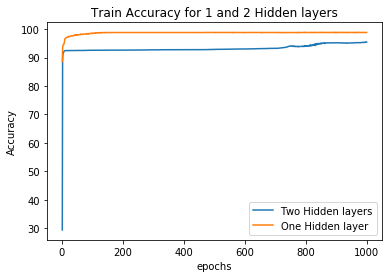

In [36]:
toplot = [trainacc_sgd, trainaccuracy[-2]]
labels = ['Two Hidden layers', 'One Hidden layer']
graph(toplot, labels, 'Train Accuracy for 1 and 2 Hidden layers', 'epochs', 'Accuracy')

In [37]:
train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle = True)

model = Net2(H1 = 10, H2 = 5)
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = torch.nn.MSELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_sgd = []
testacc_sgd = []

epoch = 0
while epoch != 1000 :
# while epoch == 0 or epoch == 1 or testerror[-1] < testerror[-2]:
    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_sgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_sgd += [test_acc]
    
    basetrainerror += [base_trainerror]
    basetesterror += [base_testerror]
    
    no_epoch += [epoch]
#     print (list(model.parameters()))

print ('Train accuracy is {} % \nTest Accuracy is {} %\n'.format(train_acc, test_acc )) 


Train set 1: Average loss: 0.5796, Training Accuracy : 1837/8143 (23%)


Test set 1: Average loss: 0.2427, Test Accuracy : 6406/9752 (66%)


Train set 2: Average loss: 0.1551, Training Accuracy : 6956/8143 (85%)


Test set 2: Average loss: 0.0939, Test Accuracy : 8745/9752 (90%)


Train set 3: Average loss: 0.0934, Training Accuracy : 7383/8143 (91%)


Test set 3: Average loss: 0.0764, Test Accuracy : 8930/9752 (92%)


Train set 4: Average loss: 0.0812, Training Accuracy : 7459/8143 (92%)


Test set 4: Average loss: 0.0668, Test Accuracy : 9044/9752 (93%)


Train set 5: Average loss: 0.0744, Training Accuracy : 7489/8143 (92%)


Test set 5: Average loss: 0.0598, Test Accuracy : 9124/9752 (94%)


Train set 6: Average loss: 0.0714, Training Accuracy : 7521/8143 (92%)


Test set 6: Average loss: 0.0577, Test Accuracy : 9137/9752 (94%)


Train set 7: Average loss: 0.0711, Training Accuracy : 7523/8143 (92%)


Test set 7: Average loss: 0.0573, Test Accuracy : 9142/9752 (94%)


Train set 8:


Test set 59: Average loss: 0.0237, Test Accuracy : 9528/9752 (98%)


Train set 60: Average loss: 0.0206, Training Accuracy : 8016/8143 (98%)


Test set 60: Average loss: 0.0230, Test Accuracy : 9534/9752 (98%)


Train set 61: Average loss: 0.0205, Training Accuracy : 7996/8143 (98%)


Test set 61: Average loss: 0.0254, Test Accuracy : 9424/9752 (97%)


Train set 62: Average loss: 0.0203, Training Accuracy : 8008/8143 (98%)


Test set 62: Average loss: 0.0228, Test Accuracy : 9530/9752 (98%)


Train set 63: Average loss: 0.0202, Training Accuracy : 8014/8143 (98%)


Test set 63: Average loss: 0.0260, Test Accuracy : 9373/9752 (96%)


Train set 64: Average loss: 0.0201, Training Accuracy : 8012/8143 (98%)


Test set 64: Average loss: 0.0229, Test Accuracy : 9533/9752 (98%)


Train set 65: Average loss: 0.0200, Training Accuracy : 8012/8143 (98%)


Test set 65: Average loss: 0.0227, Test Accuracy : 9531/9752 (98%)


Train set 66: Average loss: 0.0198, Training Accuracy : 8012/8143 (98%)



Train set 118: Average loss: 0.0160, Training Accuracy : 8033/8143 (99%)


Test set 118: Average loss: 0.0173, Test Accuracy : 9549/9752 (98%)


Train set 119: Average loss: 0.0158, Training Accuracy : 8037/8143 (99%)


Test set 119: Average loss: 0.0175, Test Accuracy : 9594/9752 (98%)


Train set 120: Average loss: 0.0158, Training Accuracy : 8030/8143 (99%)


Test set 120: Average loss: 0.0187, Test Accuracy : 9583/9752 (98%)


Train set 121: Average loss: 0.0158, Training Accuracy : 8023/8143 (99%)


Test set 121: Average loss: 0.0177, Test Accuracy : 9612/9752 (99%)


Train set 122: Average loss: 0.0157, Training Accuracy : 8031/8143 (99%)


Test set 122: Average loss: 0.0176, Test Accuracy : 9605/9752 (98%)


Train set 123: Average loss: 0.0158, Training Accuracy : 8029/8143 (99%)


Test set 123: Average loss: 0.0173, Test Accuracy : 9608/9752 (99%)


Train set 124: Average loss: 0.0156, Training Accuracy : 8028/8143 (99%)


Test set 124: Average loss: 0.0172, Test Accuracy : 95


Test set 175: Average loss: 0.0150, Test Accuracy : 9551/9752 (98%)


Train set 176: Average loss: 0.0137, Training Accuracy : 8042/8143 (99%)


Test set 176: Average loss: 0.0137, Test Accuracy : 9598/9752 (98%)


Train set 177: Average loss: 0.0137, Training Accuracy : 8043/8143 (99%)


Test set 177: Average loss: 0.0144, Test Accuracy : 9617/9752 (99%)


Train set 178: Average loss: 0.0135, Training Accuracy : 8042/8143 (99%)


Test set 178: Average loss: 0.0136, Test Accuracy : 9612/9752 (99%)


Train set 179: Average loss: 0.0134, Training Accuracy : 8048/8143 (99%)


Test set 179: Average loss: 0.0135, Test Accuracy : 9611/9752 (99%)


Train set 180: Average loss: 0.0135, Training Accuracy : 8043/8143 (99%)


Test set 180: Average loss: 0.0140, Test Accuracy : 9575/9752 (98%)


Train set 181: Average loss: 0.0134, Training Accuracy : 8049/8143 (99%)


Test set 181: Average loss: 0.0134, Test Accuracy : 9600/9752 (98%)


Train set 182: Average loss: 0.0133, Training Accuracy : 80


Train set 233: Average loss: 0.0118, Training Accuracy : 8053/8143 (99%)


Test set 233: Average loss: 0.0118, Test Accuracy : 9614/9752 (99%)


Train set 234: Average loss: 0.0117, Training Accuracy : 8054/8143 (99%)


Test set 234: Average loss: 0.0125, Test Accuracy : 9606/9752 (99%)


Train set 235: Average loss: 0.0118, Training Accuracy : 8051/8143 (99%)


Test set 235: Average loss: 0.0116, Test Accuracy : 9617/9752 (99%)


Train set 236: Average loss: 0.0117, Training Accuracy : 8051/8143 (99%)


Test set 236: Average loss: 0.0116, Test Accuracy : 9616/9752 (99%)


Train set 237: Average loss: 0.0117, Training Accuracy : 8050/8143 (99%)


Test set 237: Average loss: 0.0119, Test Accuracy : 9610/9752 (99%)


Train set 238: Average loss: 0.0117, Training Accuracy : 8049/8143 (99%)


Test set 238: Average loss: 0.0113, Test Accuracy : 9619/9752 (99%)


Train set 239: Average loss: 0.0117, Training Accuracy : 8052/8143 (99%)


Test set 239: Average loss: 0.0116, Test Accuracy : 96


Test set 290: Average loss: 0.0139, Test Accuracy : 9577/9752 (98%)


Train set 291: Average loss: 0.0110, Training Accuracy : 8054/8143 (99%)


Test set 291: Average loss: 0.0124, Test Accuracy : 9605/9752 (98%)


Train set 292: Average loss: 0.0109, Training Accuracy : 8053/8143 (99%)


Test set 292: Average loss: 0.0123, Test Accuracy : 9606/9752 (99%)


Train set 293: Average loss: 0.0110, Training Accuracy : 8055/8143 (99%)


Test set 293: Average loss: 0.0128, Test Accuracy : 9600/9752 (98%)


Train set 294: Average loss: 0.0109, Training Accuracy : 8054/8143 (99%)


Test set 294: Average loss: 0.0122, Test Accuracy : 9604/9752 (98%)


Train set 295: Average loss: 0.0109, Training Accuracy : 8055/8143 (99%)


Test set 295: Average loss: 0.0128, Test Accuracy : 9600/9752 (98%)


Train set 296: Average loss: 0.0110, Training Accuracy : 8054/8143 (99%)


Test set 296: Average loss: 0.0135, Test Accuracy : 9586/9752 (98%)


Train set 297: Average loss: 0.0109, Training Accuracy : 80


Test set 347: Average loss: 0.0151, Test Accuracy : 9564/9752 (98%)


Train set 348: Average loss: 0.0106, Training Accuracy : 8054/8143 (99%)


Test set 348: Average loss: 0.0138, Test Accuracy : 9586/9752 (98%)


Train set 349: Average loss: 0.0108, Training Accuracy : 8054/8143 (99%)


Test set 349: Average loss: 0.0145, Test Accuracy : 9576/9752 (98%)


Train set 350: Average loss: 0.0106, Training Accuracy : 8056/8143 (99%)


Test set 350: Average loss: 0.0188, Test Accuracy : 9510/9752 (98%)


Train set 351: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 351: Average loss: 0.0157, Test Accuracy : 9549/9752 (98%)


Train set 352: Average loss: 0.0106, Training Accuracy : 8056/8143 (99%)


Test set 352: Average loss: 0.0162, Test Accuracy : 9543/9752 (98%)


Train set 353: Average loss: 0.0106, Training Accuracy : 8055/8143 (99%)


Test set 353: Average loss: 0.0164, Test Accuracy : 9541/9752 (98%)


Train set 354: Average loss: 0.0106, Training Accuracy : 80


Train set 405: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 405: Average loss: 0.0175, Test Accuracy : 9509/9752 (98%)


Train set 406: Average loss: 0.0106, Training Accuracy : 8058/8143 (99%)


Test set 406: Average loss: 0.0191, Test Accuracy : 9510/9752 (98%)


Train set 407: Average loss: 0.0106, Training Accuracy : 8052/8143 (99%)


Test set 407: Average loss: 0.0174, Test Accuracy : 9532/9752 (98%)


Train set 408: Average loss: 0.0106, Training Accuracy : 8056/8143 (99%)


Test set 408: Average loss: 0.0175, Test Accuracy : 9530/9752 (98%)


Train set 409: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 409: Average loss: 0.0196, Test Accuracy : 9506/9752 (97%)


Train set 410: Average loss: 0.0106, Training Accuracy : 8054/8143 (99%)


Test set 410: Average loss: 0.0179, Test Accuracy : 9524/9752 (98%)


Train set 411: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 411: Average loss: 0.0191, Test Accuracy : 95


Train set 463: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 463: Average loss: 0.0206, Test Accuracy : 9490/9752 (97%)


Train set 464: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 464: Average loss: 0.0194, Test Accuracy : 9492/9752 (97%)


Train set 465: Average loss: 0.0107, Training Accuracy : 8051/8143 (99%)


Test set 465: Average loss: 0.0198, Test Accuracy : 9506/9752 (97%)


Train set 466: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 466: Average loss: 0.0205, Test Accuracy : 9486/9752 (97%)


Train set 467: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 467: Average loss: 0.0196, Test Accuracy : 9507/9752 (97%)


Train set 468: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 468: Average loss: 0.0195, Test Accuracy : 9490/9752 (97%)


Train set 469: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 469: Average loss: 0.0213, Test Accuracy : 94


Train set 520: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 520: Average loss: 0.0251, Test Accuracy : 9418/9752 (97%)


Train set 521: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 521: Average loss: 0.0231, Test Accuracy : 9435/9752 (97%)


Train set 522: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 522: Average loss: 0.0250, Test Accuracy : 9434/9752 (97%)


Train set 523: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 523: Average loss: 0.0226, Test Accuracy : 9447/9752 (97%)


Train set 524: Average loss: 0.0105, Training Accuracy : 8056/8143 (99%)


Test set 524: Average loss: 0.0226, Test Accuracy : 9441/9752 (97%)


Train set 525: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 525: Average loss: 0.0233, Test Accuracy : 9439/9752 (97%)


Train set 526: Average loss: 0.0105, Training Accuracy : 8055/8143 (99%)


Test set 526: Average loss: 0.0225, Test Accuracy : 94


Train set 577: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 577: Average loss: 0.0260, Test Accuracy : 9410/9752 (96%)


Train set 578: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 578: Average loss: 0.0252, Test Accuracy : 9425/9752 (97%)


Train set 579: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 579: Average loss: 0.0248, Test Accuracy : 9414/9752 (97%)


Train set 580: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 580: Average loss: 0.0258, Test Accuracy : 9406/9752 (96%)


Train set 581: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 581: Average loss: 0.0261, Test Accuracy : 9403/9752 (96%)


Train set 582: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 582: Average loss: 0.0262, Test Accuracy : 9413/9752 (97%)


Train set 583: Average loss: 0.0104, Training Accuracy : 8054/8143 (99%)


Test set 583: Average loss: 0.0255, Test Accuracy : 94


Train set 634: Average loss: 0.0104, Training Accuracy : 8054/8143 (99%)


Test set 634: Average loss: 0.0273, Test Accuracy : 9392/9752 (96%)


Train set 635: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 635: Average loss: 0.0279, Test Accuracy : 9378/9752 (96%)


Train set 636: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 636: Average loss: 0.0284, Test Accuracy : 9377/9752 (96%)


Train set 637: Average loss: 0.0104, Training Accuracy : 8054/8143 (99%)


Test set 637: Average loss: 0.0291, Test Accuracy : 9369/9752 (96%)


Train set 638: Average loss: 0.0103, Training Accuracy : 8056/8143 (99%)


Test set 638: Average loss: 0.0293, Test Accuracy : 9372/9752 (96%)


Train set 639: Average loss: 0.0105, Training Accuracy : 8054/8143 (99%)


Test set 639: Average loss: 0.0287, Test Accuracy : 9376/9752 (96%)


Train set 640: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 640: Average loss: 0.0283, Test Accuracy : 93


Train set 692: Average loss: 0.0104, Training Accuracy : 8054/8143 (99%)


Test set 692: Average loss: 0.0310, Test Accuracy : 9358/9752 (96%)


Train set 693: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 693: Average loss: 0.0290, Test Accuracy : 9374/9752 (96%)


Train set 694: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 694: Average loss: 0.0297, Test Accuracy : 9363/9752 (96%)


Train set 695: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 695: Average loss: 0.0317, Test Accuracy : 9351/9752 (96%)


Train set 696: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 696: Average loss: 0.0299, Test Accuracy : 9378/9752 (96%)


Train set 697: Average loss: 0.0104, Training Accuracy : 8054/8143 (99%)


Test set 697: Average loss: 0.0309, Test Accuracy : 9357/9752 (96%)


Train set 698: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 698: Average loss: 0.0311, Test Accuracy : 93


Train set 750: Average loss: 0.0104, Training Accuracy : 8053/8143 (99%)


Test set 750: Average loss: 0.0329, Test Accuracy : 9343/9752 (96%)


Train set 751: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 751: Average loss: 0.0322, Test Accuracy : 9354/9752 (96%)


Train set 752: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 752: Average loss: 0.0315, Test Accuracy : 9353/9752 (96%)


Train set 753: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 753: Average loss: 0.0314, Test Accuracy : 9348/9752 (96%)


Train set 754: Average loss: 0.0104, Training Accuracy : 8058/8143 (99%)


Test set 754: Average loss: 0.0320, Test Accuracy : 9352/9752 (96%)


Train set 755: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 755: Average loss: 0.0334, Test Accuracy : 9330/9752 (96%)


Train set 756: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 756: Average loss: 0.0335, Test Accuracy : 93


Train set 807: Average loss: 0.0103, Training Accuracy : 8058/8143 (99%)


Test set 807: Average loss: 0.0339, Test Accuracy : 9344/9752 (96%)


Train set 808: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 808: Average loss: 0.0344, Test Accuracy : 9341/9752 (96%)


Train set 809: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 809: Average loss: 0.0346, Test Accuracy : 9322/9752 (96%)


Train set 810: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 810: Average loss: 0.0340, Test Accuracy : 9335/9752 (96%)


Train set 811: Average loss: 0.0104, Training Accuracy : 8052/8143 (99%)


Test set 811: Average loss: 0.0335, Test Accuracy : 9352/9752 (96%)


Train set 812: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 812: Average loss: 0.0331, Test Accuracy : 9340/9752 (96%)


Train set 813: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 813: Average loss: 0.0342, Test Accuracy : 93


Train set 865: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 865: Average loss: 0.0361, Test Accuracy : 9318/9752 (96%)


Train set 866: Average loss: 0.0103, Training Accuracy : 8055/8143 (99%)


Test set 866: Average loss: 0.0368, Test Accuracy : 9306/9752 (95%)


Train set 867: Average loss: 0.0103, Training Accuracy : 8056/8143 (99%)


Test set 867: Average loss: 0.0379, Test Accuracy : 9298/9752 (95%)


Train set 868: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 868: Average loss: 0.0378, Test Accuracy : 9302/9752 (95%)


Train set 869: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 869: Average loss: 0.0364, Test Accuracy : 9315/9752 (96%)


Train set 870: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 870: Average loss: 0.0369, Test Accuracy : 9303/9752 (95%)


Train set 871: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 871: Average loss: 0.0368, Test Accuracy : 93


Test set 921: Average loss: 0.0385, Test Accuracy : 9294/9752 (95%)


Train set 922: Average loss: 0.0103, Training Accuracy : 8056/8143 (99%)


Test set 922: Average loss: 0.0377, Test Accuracy : 9307/9752 (95%)


Train set 923: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 923: Average loss: 0.0386, Test Accuracy : 9297/9752 (95%)


Train set 924: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 924: Average loss: 0.0388, Test Accuracy : 9298/9752 (95%)


Train set 925: Average loss: 0.0103, Training Accuracy : 8056/8143 (99%)


Test set 925: Average loss: 0.0377, Test Accuracy : 9299/9752 (95%)


Train set 926: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 926: Average loss: 0.0371, Test Accuracy : 9314/9752 (96%)


Train set 927: Average loss: 0.0104, Training Accuracy : 8056/8143 (99%)


Test set 927: Average loss: 0.0370, Test Accuracy : 9314/9752 (96%)


Train set 928: Average loss: 0.0104, Training Accuracy : 80


Train set 979: Average loss: 0.0103, Training Accuracy : 8055/8143 (99%)


Test set 979: Average loss: 0.0387, Test Accuracy : 9300/9752 (95%)


Train set 980: Average loss: 0.0103, Training Accuracy : 8056/8143 (99%)


Test set 980: Average loss: 0.0392, Test Accuracy : 9291/9752 (95%)


Train set 981: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 981: Average loss: 0.0405, Test Accuracy : 9284/9752 (95%)


Train set 982: Average loss: 0.0104, Training Accuracy : 8057/8143 (99%)


Test set 982: Average loss: 0.0408, Test Accuracy : 9274/9752 (95%)


Train set 983: Average loss: 0.0103, Training Accuracy : 8057/8143 (99%)


Test set 983: Average loss: 0.0395, Test Accuracy : 9296/9752 (95%)


Train set 984: Average loss: 0.0104, Training Accuracy : 8055/8143 (99%)


Test set 984: Average loss: 0.0388, Test Accuracy : 9297/9752 (95%)


Train set 985: Average loss: 0.0104, Training Accuracy : 8054/8143 (99%)


Test set 985: Average loss: 0.0413, Test Accuracy : 92

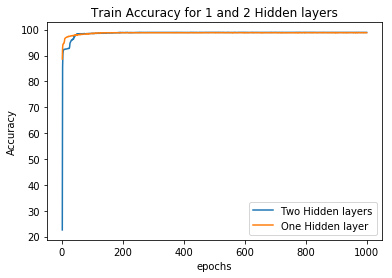

In [38]:
toplot = [trainacc_sgd, trainaccuracy[-2]]
labels = ['Two Hidden layers', 'One Hidden layer']
graph(toplot, labels, 'Train Accuracy for 1 and 2 Hidden layers', 'epochs', 'Accuracy')

In [39]:
train_loader = data_utils.DataLoader(train_util, batch_size = 100, shuffle = True)

model = Net2(H1 = 10, H2 = 10)
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = torch.nn.MSELoss(size_average = True)

base_trainerror = baseline(y_train)
base_testerror = baseline(y_test)
basetesterror = []
basetrainerror = []
trainerror = []
testerror = []
no_epoch = []
trainacc_sgd = []
testacc_sgd = []

epoch = 0
while epoch != 1000 :
# while epoch == 0 or epoch == 1 or testerror[-1] < testerror[-2]:
    epoch = epoch + 1
    
    train_error, train_acc = train(epoch) 
    trainerror += [train_error]
    trainacc_sgd += [train_acc]
    
    test_error, test_acc = test(epoch)
    testerror += [test_error]
    testacc_sgd += [test_acc]
    
    basetrainerror += [base_trainerror]
    basetesterror += [base_testerror]
    
    no_epoch += [epoch]
#     print (list(model.parameters()))

print ('Train accuracy is {} % \nTest Accuracy is {} %\n'.format(train_acc, test_acc )) 


Train set 1: Average loss: 0.1498, Training Accuracy : 6736/8143 (83%)


Test set 1: Average loss: 0.0319, Test Accuracy : 9277/9752 (95%)


Train set 2: Average loss: 0.0432, Training Accuracy : 7735/8143 (95%)


Test set 2: Average loss: 0.0291, Test Accuracy : 9339/9752 (96%)


Train set 3: Average loss: 0.0365, Training Accuracy : 7789/8143 (96%)


Test set 3: Average loss: 0.0313, Test Accuracy : 9326/9752 (96%)


Train set 4: Average loss: 0.0338, Training Accuracy : 7786/8143 (96%)


Test set 4: Average loss: 0.0323, Test Accuracy : 9310/9752 (95%)


Train set 5: Average loss: 0.0326, Training Accuracy : 7781/8143 (96%)


Test set 5: Average loss: 0.0319, Test Accuracy : 9312/9752 (95%)


Train set 6: Average loss: 0.0315, Training Accuracy : 7793/8143 (96%)


Test set 6: Average loss: 0.0321, Test Accuracy : 9319/9752 (96%)


Train set 7: Average loss: 0.0309, Training Accuracy : 7791/8143 (96%)


Test set 7: Average loss: 0.0316, Test Accuracy : 9339/9752 (96%)


Train set 8:


Train set 60: Average loss: 0.0172, Training Accuracy : 8014/8143 (98%)


Test set 60: Average loss: 0.0183, Test Accuracy : 9572/9752 (98%)


Train set 61: Average loss: 0.0171, Training Accuracy : 8011/8143 (98%)


Test set 61: Average loss: 0.0178, Test Accuracy : 9577/9752 (98%)


Train set 62: Average loss: 0.0170, Training Accuracy : 8013/8143 (98%)


Test set 62: Average loss: 0.0179, Test Accuracy : 9578/9752 (98%)


Train set 63: Average loss: 0.0170, Training Accuracy : 8015/8143 (98%)


Test set 63: Average loss: 0.0174, Test Accuracy : 9580/9752 (98%)


Train set 64: Average loss: 0.0169, Training Accuracy : 8015/8143 (98%)


Test set 64: Average loss: 0.0172, Test Accuracy : 9586/9752 (98%)


Train set 65: Average loss: 0.0170, Training Accuracy : 8008/8143 (98%)


Test set 65: Average loss: 0.0172, Test Accuracy : 9588/9752 (98%)


Train set 66: Average loss: 0.0167, Training Accuracy : 8018/8143 (98%)


Test set 66: Average loss: 0.0172, Test Accuracy : 9587/9752 (98%)



Test set 118: Average loss: 0.0137, Test Accuracy : 9607/9752 (99%)


Train set 119: Average loss: 0.0137, Training Accuracy : 8045/8143 (99%)


Test set 119: Average loss: 0.0137, Test Accuracy : 9608/9752 (99%)


Train set 120: Average loss: 0.0135, Training Accuracy : 8049/8143 (99%)


Test set 120: Average loss: 0.0130, Test Accuracy : 9628/9752 (99%)


Train set 121: Average loss: 0.0135, Training Accuracy : 8046/8143 (99%)


Test set 121: Average loss: 0.0133, Test Accuracy : 9613/9752 (99%)


Train set 122: Average loss: 0.0134, Training Accuracy : 8047/8143 (99%)


Test set 122: Average loss: 0.0127, Test Accuracy : 9635/9752 (99%)


Train set 123: Average loss: 0.0134, Training Accuracy : 8048/8143 (99%)


Test set 123: Average loss: 0.0131, Test Accuracy : 9621/9752 (99%)


Train set 124: Average loss: 0.0133, Training Accuracy : 8049/8143 (99%)


Test set 124: Average loss: 0.0126, Test Accuracy : 9636/9752 (99%)


Train set 125: Average loss: 0.0132, Training Accuracy : 80


Train set 176: Average loss: 0.0118, Training Accuracy : 8049/8143 (99%)


Test set 176: Average loss: 0.0151, Test Accuracy : 9568/9752 (98%)


Train set 177: Average loss: 0.0117, Training Accuracy : 8049/8143 (99%)


Test set 177: Average loss: 0.0150, Test Accuracy : 9568/9752 (98%)


Train set 178: Average loss: 0.0117, Training Accuracy : 8048/8143 (99%)


Test set 178: Average loss: 0.0136, Test Accuracy : 9589/9752 (98%)


Train set 179: Average loss: 0.0118, Training Accuracy : 8049/8143 (99%)


Test set 179: Average loss: 0.0145, Test Accuracy : 9574/9752 (98%)


Train set 180: Average loss: 0.0118, Training Accuracy : 8047/8143 (99%)


Test set 180: Average loss: 0.0153, Test Accuracy : 9560/9752 (98%)


Train set 181: Average loss: 0.0117, Training Accuracy : 8049/8143 (99%)


Test set 181: Average loss: 0.0140, Test Accuracy : 9580/9752 (98%)


Train set 182: Average loss: 0.0117, Training Accuracy : 8049/8143 (99%)


Test set 182: Average loss: 0.0152, Test Accuracy : 95


Train set 233: Average loss: 0.0113, Training Accuracy : 8049/8143 (99%)


Test set 233: Average loss: 0.0147, Test Accuracy : 9573/9752 (98%)


Train set 234: Average loss: 0.0113, Training Accuracy : 8048/8143 (99%)


Test set 234: Average loss: 0.0154, Test Accuracy : 9562/9752 (98%)


Train set 235: Average loss: 0.0113, Training Accuracy : 8049/8143 (99%)


Test set 235: Average loss: 0.0140, Test Accuracy : 9583/9752 (98%)


Train set 236: Average loss: 0.0113, Training Accuracy : 8049/8143 (99%)


Test set 236: Average loss: 0.0181, Test Accuracy : 9516/9752 (98%)


Train set 237: Average loss: 0.0113, Training Accuracy : 8049/8143 (99%)


Test set 237: Average loss: 0.0176, Test Accuracy : 9523/9752 (98%)


Train set 238: Average loss: 0.0113, Training Accuracy : 8049/8143 (99%)


Test set 238: Average loss: 0.0190, Test Accuracy : 9502/9752 (97%)


Train set 239: Average loss: 0.0114, Training Accuracy : 8048/8143 (99%)


Test set 239: Average loss: 0.0172, Test Accuracy : 95


Test set 290: Average loss: 0.0179, Test Accuracy : 9524/9752 (98%)


Train set 291: Average loss: 0.0111, Training Accuracy : 8048/8143 (99%)


Test set 291: Average loss: 0.0172, Test Accuracy : 9534/9752 (98%)


Train set 292: Average loss: 0.0112, Training Accuracy : 8049/8143 (99%)


Test set 292: Average loss: 0.0159, Test Accuracy : 9557/9752 (98%)


Train set 293: Average loss: 0.0111, Training Accuracy : 8050/8143 (99%)


Test set 293: Average loss: 0.0215, Test Accuracy : 9465/9752 (97%)


Train set 294: Average loss: 0.0111, Training Accuracy : 8049/8143 (99%)


Test set 294: Average loss: 0.0234, Test Accuracy : 9444/9752 (97%)


Train set 295: Average loss: 0.0112, Training Accuracy : 8047/8143 (99%)


Test set 295: Average loss: 0.0249, Test Accuracy : 9431/9752 (97%)


Train set 296: Average loss: 0.0112, Training Accuracy : 8052/8143 (99%)


Test set 296: Average loss: 0.0161, Test Accuracy : 9551/9752 (98%)


Train set 297: Average loss: 0.0111, Training Accuracy : 80


Test set 347: Average loss: 0.0179, Test Accuracy : 9527/9752 (98%)


Train set 348: Average loss: 0.0110, Training Accuracy : 8048/8143 (99%)


Test set 348: Average loss: 0.0176, Test Accuracy : 9533/9752 (98%)


Train set 349: Average loss: 0.0110, Training Accuracy : 8050/8143 (99%)


Test set 349: Average loss: 0.0170, Test Accuracy : 9542/9752 (98%)


Train set 350: Average loss: 0.0110, Training Accuracy : 8050/8143 (99%)


Test set 350: Average loss: 0.0246, Test Accuracy : 9436/9752 (97%)


Train set 351: Average loss: 0.0111, Training Accuracy : 8049/8143 (99%)


Test set 351: Average loss: 0.0176, Test Accuracy : 9532/9752 (98%)


Train set 352: Average loss: 0.0111, Training Accuracy : 8048/8143 (99%)


Test set 352: Average loss: 0.0181, Test Accuracy : 9522/9752 (98%)


Train set 353: Average loss: 0.0111, Training Accuracy : 8048/8143 (99%)


Test set 353: Average loss: 0.0231, Test Accuracy : 9449/9752 (97%)


Train set 354: Average loss: 0.0110, Training Accuracy : 80


Train set 405: Average loss: 0.0109, Training Accuracy : 8051/8143 (99%)


Test set 405: Average loss: 0.0163, Test Accuracy : 9562/9752 (98%)


Train set 406: Average loss: 0.0111, Training Accuracy : 8053/8143 (99%)


Test set 406: Average loss: 0.0182, Test Accuracy : 9526/9752 (98%)


Train set 407: Average loss: 0.0109, Training Accuracy : 8054/8143 (99%)


Test set 407: Average loss: 0.0205, Test Accuracy : 9492/9752 (97%)


Train set 408: Average loss: 0.0110, Training Accuracy : 8051/8143 (99%)


Test set 408: Average loss: 0.0243, Test Accuracy : 9444/9752 (97%)


Train set 409: Average loss: 0.0110, Training Accuracy : 8049/8143 (99%)


Test set 409: Average loss: 0.0216, Test Accuracy : 9480/9752 (97%)


Train set 410: Average loss: 0.0109, Training Accuracy : 8050/8143 (99%)


Test set 410: Average loss: 0.0177, Test Accuracy : 9539/9752 (98%)


Train set 411: Average loss: 0.0109, Training Accuracy : 8047/8143 (99%)


Test set 411: Average loss: 0.0197, Test Accuracy : 95


Train set 462: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 462: Average loss: 0.0176, Test Accuracy : 9542/9752 (98%)


Train set 463: Average loss: 0.0109, Training Accuracy : 8051/8143 (99%)


Test set 463: Average loss: 0.0248, Test Accuracy : 9444/9752 (97%)


Train set 464: Average loss: 0.0109, Training Accuracy : 8051/8143 (99%)


Test set 464: Average loss: 0.0227, Test Accuracy : 9469/9752 (97%)


Train set 465: Average loss: 0.0108, Training Accuracy : 8051/8143 (99%)


Test set 465: Average loss: 0.0200, Test Accuracy : 9502/9752 (97%)


Train set 466: Average loss: 0.0109, Training Accuracy : 8051/8143 (99%)


Test set 466: Average loss: 0.0195, Test Accuracy : 9513/9752 (98%)


Train set 467: Average loss: 0.0108, Training Accuracy : 8051/8143 (99%)


Test set 467: Average loss: 0.0214, Test Accuracy : 9485/9752 (97%)


Train set 468: Average loss: 0.0108, Training Accuracy : 8051/8143 (99%)


Test set 468: Average loss: 0.0204, Test Accuracy : 94


Test set 518: Average loss: 0.0233, Test Accuracy : 9466/9752 (97%)


Train set 519: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 519: Average loss: 0.0228, Test Accuracy : 9472/9752 (97%)


Train set 520: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 520: Average loss: 0.0240, Test Accuracy : 9455/9752 (97%)


Train set 521: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 521: Average loss: 0.0236, Test Accuracy : 9463/9752 (97%)


Train set 522: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 522: Average loss: 0.0262, Test Accuracy : 9435/9752 (97%)


Train set 523: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 523: Average loss: 0.0180, Test Accuracy : 9538/9752 (98%)


Train set 524: Average loss: 0.0108, Training Accuracy : 8050/8143 (99%)


Test set 524: Average loss: 0.0226, Test Accuracy : 9475/9752 (97%)


Train set 525: Average loss: 0.0108, Training Accuracy : 80


Test set 576: Average loss: 0.0282, Test Accuracy : 9414/9752 (97%)


Train set 577: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 577: Average loss: 0.0257, Test Accuracy : 9444/9752 (97%)


Train set 578: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 578: Average loss: 0.0214, Test Accuracy : 9491/9752 (97%)


Train set 579: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 579: Average loss: 0.0257, Test Accuracy : 9445/9752 (97%)


Train set 580: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 580: Average loss: 0.0267, Test Accuracy : 9432/9752 (97%)


Train set 581: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 581: Average loss: 0.0246, Test Accuracy : 9452/9752 (97%)


Train set 582: Average loss: 0.0107, Training Accuracy : 8051/8143 (99%)


Test set 582: Average loss: 0.0243, Test Accuracy : 9457/9752 (97%)


Train set 583: Average loss: 0.0107, Training Accuracy : 80


Test set 634: Average loss: 0.0277, Test Accuracy : 9419/9752 (97%)


Train set 635: Average loss: 0.0108, Training Accuracy : 8054/8143 (99%)


Test set 635: Average loss: 0.0233, Test Accuracy : 9469/9752 (97%)


Train set 636: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 636: Average loss: 0.0252, Test Accuracy : 9452/9752 (97%)


Train set 637: Average loss: 0.0107, Training Accuracy : 8051/8143 (99%)


Test set 637: Average loss: 0.0248, Test Accuracy : 9455/9752 (97%)


Train set 638: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 638: Average loss: 0.0260, Test Accuracy : 9442/9752 (97%)


Train set 639: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 639: Average loss: 0.0261, Test Accuracy : 9442/9752 (97%)


Train set 640: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 640: Average loss: 0.0235, Test Accuracy : 9467/9752 (97%)


Train set 641: Average loss: 0.0108, Training Accuracy : 80


Test set 692: Average loss: 0.0251, Test Accuracy : 9455/9752 (97%)


Train set 693: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 693: Average loss: 0.0238, Test Accuracy : 9465/9752 (97%)


Train set 694: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 694: Average loss: 0.0226, Test Accuracy : 9474/9752 (97%)


Train set 695: Average loss: 0.0107, Training Accuracy : 8051/8143 (99%)


Test set 695: Average loss: 0.0206, Test Accuracy : 9496/9752 (97%)


Train set 696: Average loss: 0.0108, Training Accuracy : 8054/8143 (99%)


Test set 696: Average loss: 0.0247, Test Accuracy : 9458/9752 (97%)


Train set 697: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 697: Average loss: 0.0200, Test Accuracy : 9510/9752 (98%)


Train set 698: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 698: Average loss: 0.0225, Test Accuracy : 9478/9752 (97%)


Train set 699: Average loss: 0.0107, Training Accuracy : 80


Train set 750: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 750: Average loss: 0.0271, Test Accuracy : 9440/9752 (97%)


Train set 751: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 751: Average loss: 0.0292, Test Accuracy : 9413/9752 (97%)


Train set 752: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 752: Average loss: 0.0213, Test Accuracy : 9485/9752 (97%)


Train set 753: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 753: Average loss: 0.0227, Test Accuracy : 9466/9752 (97%)


Train set 754: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 754: Average loss: 0.0249, Test Accuracy : 9455/9752 (97%)


Train set 755: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 755: Average loss: 0.0269, Test Accuracy : 9442/9752 (97%)


Train set 756: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 756: Average loss: 0.0274, Test Accuracy : 94


Test set 806: Average loss: 0.0211, Test Accuracy : 9483/9752 (97%)


Train set 807: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 807: Average loss: 0.0270, Test Accuracy : 9437/9752 (97%)


Train set 808: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 808: Average loss: 0.0268, Test Accuracy : 9436/9752 (97%)


Train set 809: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 809: Average loss: 0.0253, Test Accuracy : 9449/9752 (97%)


Train set 810: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 810: Average loss: 0.0254, Test Accuracy : 9451/9752 (97%)


Train set 811: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 811: Average loss: 0.0292, Test Accuracy : 9415/9752 (97%)


Train set 812: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 812: Average loss: 0.0240, Test Accuracy : 9456/9752 (97%)


Train set 813: Average loss: 0.0107, Training Accuracy : 80


Train set 865: Average loss: 0.0108, Training Accuracy : 8050/8143 (99%)


Test set 865: Average loss: 0.0273, Test Accuracy : 9433/9752 (97%)


Train set 866: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 866: Average loss: 0.0266, Test Accuracy : 9432/9752 (97%)


Train set 867: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 867: Average loss: 0.0275, Test Accuracy : 9431/9752 (97%)


Train set 868: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 868: Average loss: 0.0277, Test Accuracy : 9429/9752 (97%)


Train set 869: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 869: Average loss: 0.0270, Test Accuracy : 9431/9752 (97%)


Train set 870: Average loss: 0.0107, Training Accuracy : 8055/8143 (99%)


Test set 870: Average loss: 0.0261, Test Accuracy : 9439/9752 (97%)


Train set 871: Average loss: 0.0108, Training Accuracy : 8051/8143 (99%)


Test set 871: Average loss: 0.0290, Test Accuracy : 94


Test set 921: Average loss: 0.0266, Test Accuracy : 9436/9752 (97%)


Train set 922: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 922: Average loss: 0.0298, Test Accuracy : 9408/9752 (96%)


Train set 923: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 923: Average loss: 0.0313, Test Accuracy : 9398/9752 (96%)


Train set 924: Average loss: 0.0108, Training Accuracy : 8053/8143 (99%)


Test set 924: Average loss: 0.0292, Test Accuracy : 9415/9752 (97%)


Train set 925: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 925: Average loss: 0.0278, Test Accuracy : 9430/9752 (97%)


Train set 926: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 926: Average loss: 0.0251, Test Accuracy : 9454/9752 (97%)


Train set 927: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 927: Average loss: 0.0269, Test Accuracy : 9433/9752 (97%)


Train set 928: Average loss: 0.0107, Training Accuracy : 80


Test set 978: Average loss: 0.0308, Test Accuracy : 9400/9752 (96%)


Train set 979: Average loss: 0.0107, Training Accuracy : 8052/8143 (99%)


Test set 979: Average loss: 0.0267, Test Accuracy : 9435/9752 (97%)


Train set 980: Average loss: 0.0108, Training Accuracy : 8052/8143 (99%)


Test set 980: Average loss: 0.0304, Test Accuracy : 9404/9752 (96%)


Train set 981: Average loss: 0.0107, Training Accuracy : 8054/8143 (99%)


Test set 981: Average loss: 0.0281, Test Accuracy : 9420/9752 (97%)


Train set 982: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 982: Average loss: 0.0286, Test Accuracy : 9415/9752 (97%)


Train set 983: Average loss: 0.0107, Training Accuracy : 8053/8143 (99%)


Test set 983: Average loss: 0.0325, Test Accuracy : 9395/9752 (96%)


Train set 984: Average loss: 0.0107, Training Accuracy : 8049/8143 (99%)


Test set 984: Average loss: 0.0302, Test Accuracy : 9408/9752 (96%)


Train set 985: Average loss: 0.0107, Training Accuracy : 80

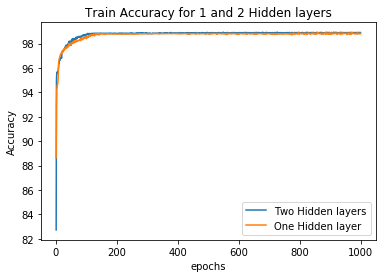

In [40]:
toplot = [trainacc_sgd, trainaccuracy[-2]]
labels = ['Two Hidden layers', 'One Hidden layer']
graph(toplot, labels, 'Train Accuracy for 1 and 2 Hidden layers', 'epochs', 'Accuracy')

## Report

I have tried training with a few model architectures as can be seen above.

Adam optimizer seems to perform better than SGD.

